# Notebook Setup

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import math
import seaborn as sns

from utils.utils import *
from utils.res_utils import *

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')

from scipy.stats import gmean, hmean
from identify_zero_class import identify_zero_class
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import wilcoxon, ttest_rel, shapiro, levene, friedmanchisquare
from statsmodels.stats.multitest import multipletests
from functools import lru_cache


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot setup

In [2]:
fig_width = 24
fig_height = 6

base_font_size = 36
title_font_size = base_font_size + 2
label_font_size = base_font_size - 2
annotation_font_size = base_font_size - 4
legend_font_size = base_font_size - 6
barwidth = 0.7

plot_average_bar = False

matplotlib.rc('xtick', labelsize=label_font_size) 
matplotlib.rc('ytick', labelsize=label_font_size)

ticklabelsize = 12
title_font_size = 20
matplotlib.rc('xtick', labelsize = ticklabelsize) 
matplotlib.rc('ytick', labelsize = ticklabelsize)

# Faithfulness evaluation of univariate time series
---

In [4]:
# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Load faithfulness evaluation results data
experimental_results_file = 'results/quality metrics.csv' # This file contains the computed faithfulness metrics for each Dataset, Model, Seed, AM, PM, region size combination, namely AUPC_MoRF, AUPC_LeRF, DS, DDS, PES - NOT INCLUDED IN REPOSITORY DUE TO VERY LARGE SIZE! 
results_df = pd.read_csv(experimental_results_file)
results_df.info()

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Define output results directory
# All results that THIS notebook generates (plots, csvs, etc.) will be stored in this directory
results_dir = 'results_from_notebook' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242000 entries, 0 to 1241999
Data columns (total 44 columns):
 #   Column                                     Non-Null Count    Dtype  
---  ------                                     --------------    -----  
 0   Unnamed: 0                                 1242000 non-null  int64  
 1   Dataset                                    1242000 non-null  object 
 2   Model                                      1242000 non-null  object 
 3   Seed                                       1242000 non-null  int64  
 4   Attribution Method                         1242000 non-null  object 
 5   Perturbation Method                        1242000 non-null  object 
 6   Region Size                                1242000 non-null  int64  
 7   Class name                                 1242000 non-null  object 
 8   is_zero_class                              1242000 non-null  bool   
 9   #Samples                                   1242000 non-null  int64  

## PM focused results analysis
---

### Comparison of PM effect on AM ranking for individual combinations of dataset, model, seed and region size

#### Utility functions

In [5]:
rank_by_metric = 'cmi-mean'

# @lru_cache(maxsize=None)
def rank_ams_by_cmi(dataset=None, model=None, region_size='smaller', seed_idx=None, pm=None, detailed_output = False, class_name = 'all classes', res_df=None):
    """
    For a given dataset, model, region size and seed index, provides the ranking of AMs according to CMI

    Args:
        dataset (string): Name of dataset - if not specified, all datasets are used
        model (string): Name of model - if not specified, all models are used
        region_size (string): "smaller" or "larger" - if not specified, both region sizes are used
        seed_idx (int): idx of model seed [0-4] - if not specified, all seeds are used
        pm (string): Name of perturbation method - if not specified, all PMs are used
        detailed_output (bool): should a detailed output be printed
        class_name (string): specifies if the ranking should be obtained for a specific class (e.g.: "0", "1"), over all classes ()"all classes"), or exclude the zero-class ("all classes - no zero class")
        res_df (DataFrame): if provided will be used for computing the cmi based ranking - otherwise the global dataframe will be used

    Returns:
        list of dictionaries representing the ranking of results.
    """

    if res_df is not None:
        dataset_df = res_df.copy()
    else:    
        dataset_df = results_df.copy() # use global results dataframe
    dataset_df = dataset_df.loc[dataset_df['Class name'] == class_name]

    if dataset is not None:
        dataset_df = dataset_df.loc[(dataset_df['Dataset'] == dataset)]
    if model is not None:
        dataset_df = dataset_df.loc[(dataset_df['Model'] == model)]

    region_sizes = list(dataset_df['Region Size'].unique())

    if region_size == 'smaller':
        dataset_df = dataset_df.loc[dataset_df['Region Size'] == region_sizes[0]]
    elif region_size == 'larger':
        dataset_df = dataset_df.loc[dataset_df['Region Size'] == region_sizes[1]]

    attribution_methods = list(dataset_df['Attribution Method'].unique())
    seeds = list(dataset_df['Seed'].unique())

    if seed_idx is not None:
        dataset_df = dataset_df.loc[dataset_df['Seed'] == seeds[seed_idx]]

    if pm is not None:
        dataset_df = dataset_df.loc[dataset_df['Perturbation Method'] == pm]

    results = []
    for am in attribution_methods:
        df = dataset_df.loc[(dataset_df['Attribution Method'] == am)]
        num_samples = df['#Samples'].to_numpy()
        dds_mean_values = df['DDS - mean'].to_numpy()
        dds_std_values = df['DDS - std'].to_numpy()
        pes_values = df['PES'].to_numpy()

        combined_dds_mean = combined_mean(dds_mean_values, num_samples)
        combine_dds_std = combined_stddev(dds_std_values, num_samples)

        pes_mean = pes_values.mean()
        pes_std = pes_values.std()

        cmis = []
        for i in range(len(pes_values)):
            cmis.append(CMI(dds_mean_values[i], pes_values[i]))
        cmis = np.array(cmis)

        results.append({
            'dataset': dataset,
            'model': model,
            'am': am,
            'pm' : pm,
            'dds-mean': combined_dds_mean,
            'dds-std': combine_dds_std,
            'dds-num-samples': num_samples.sum(),
            'pes-mean': pes_mean,
            'pes-std': pes_std,
            'cmis': cmis,
            'cmi-mean': cmis.mean(),
            'cmi-std': cmis.std(),
            'cmi-cv': np.Inf if cmis.mean() == 0 else cmis.std() / cmis.mean(),
        })

    results = sorted(results, key=lambda x: x[rank_by_metric], reverse=True)

    return results

In [6]:
def plot_mean_am_rank_and_significance_tests(avg_ranks, dataset, model, region_size, plot_class_name):
    """
    Generates a plot with two charts. 
    left - bar chart showing the weighted ranking of AMs (including weighted std) 
    right - maxtrix of results from pairwise significance tests between AM rankings

    Args:
        avg_ranks (list) - list of AMs with all their average ranks and associated weights (cmi_max**2)
        dataset (string)
        model (string)
        region_size (string)
        plot_class_name (string)

    Returns:
        no return
    """
    # --------------------------------------------------------------------
    # Generates bar chart showing comparison of weighted means
    df = pd.DataFrame(avg_ranks)
    ams = df['Attribution Method'].values[::-1]
    for i in range(len(ams)):
        ams[i] = ams[i].replace('Captum', '') # Remove "Captum" from the AM names

    means = df['Rank (mean)'].values[::-1]
    stds = df['Rank (std)'].values[::-1]

    fig, axs = plt.subplots(1,2, figsize=(13,7))
    bars = axs[0].barh(ams, means)
    axs[0].set_xlim(0,len(ams)+2)

    fig.suptitle('Dataset: {} | Model: {} | Region Size: {}\n{}'.format(dataset, model, region_size, plot_class_name), fontsize=16)
    fig.set_facecolor('white')

    axs[0].errorbar(means, range(len(ams)), xerr=stds, fmt='none', ecolor='red', capsize=5, linewidth = 2)

    # Add semi-transparent vertical lines at every n steps
    n = 2  # Number of steps between lines
    for i in range(2, len(ams)+1, n):
        # ax.axvline(x=i, color='gray', linestyle='dashed', alpha=0.2)
        axs[0].axvline(x=i, color='lightgray', alpha=0.3, linewidth=1)

    # Add value labels to each bar
    for bar in bars:
        width = bar.get_width()
        axs[0].text(width, bar.get_y() + bar.get_height()/2, '{:.2f}'.format(width), ha='left', va='center', fontweight='bold')

    # Set labels and title
    axs[0].set_xlabel('Rank', fontsize=12, fontweight='bold')
    axs[0].set_ylabel('Attribution Methods', fontsize=12, fontweight='bold')
    axs[0].set_title('Weighted average ranking of AMs', fontsize=14)

    # --------------------------------------------------------------------
    # Significance tests (comparison of weighted means)
    # --------------------------------------------------------------------
    sig_diff_matrix = []
    significance_test_results = []
    n_comparisons = len(avg_ranks) - 1
    labels = []
    for i in range(len(avg_ranks)):
        am_i_name = avg_ranks[i]['Attribution Method'].replace('Captum','')
        significance_test_row = {
            '-' : am_i_name,
        }
        labels.append(am_i_name)

        am_1_ranks = avg_ranks[i]['ranks']
        weights = avg_ranks[i]['weights']
        sig_diffs = []
        for j in range(len(avg_ranks)):
            am_j_name = avg_ranks[j]['Attribution Method'].replace('Captum','')
            am_2_ranks = avg_ranks[j]['ranks']
            # am_2_weights = avg_am_rank_cmi_2_adjusted[j]['weights']

            # Calculate the differences between paired observations
            differences = am_1_ranks - am_2_ranks

            if np.all(differences == 0):
                sig_diffs.append(False)
                significance_test_row['{} - test statistic'.format(am_j_name)] = None
                significance_test_row['{} - p-value'.format(am_j_name)] = None
                continue

            # Multiply the ranks by the corresponding weights
            weighted_differences = differences * weights

            # _, shapiro_p_val = shapiro(weighted_differences)
            # if shapiro_p_val < 0.05:
            #     print('NOT normally distributed')
            # else:
            #     print('normally distributed')

            df = pd.DataFrame({
                'weighted_differences' : weighted_differences,
                'differences':differences,
                'weights':weights
            })

            # wilcoxon test chosen, because it often happens that differences are not normally distributed
            stat, p_value = wilcoxon(weighted_differences)

            sig_diffs.append(p_value < (0.05 / n_comparisons))

            significance_test_row['{} - test statistic'.format(am_j_name)] = stat
            significance_test_row['{} - p-value'.format(am_j_name)] = p_value
        significance_test_results.append(significance_test_row)

        sig_diff_matrix.append(sig_diffs)

    sns.heatmap(sig_diff_matrix, annot=False, fmt="d", cmap="Reds_r", vmin=0, vmax=1, xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='lightgray', ax=axs[1], cbar=False)
    axs[1].set_title('Pairwise significance tests between AMs\n(red means no significant difference)', fontsize=14)
    # sns.heatmap(sig_diff_matrix, annot=False, fmt="d", cmap="Reds_r", xticklabels=labels, yticklabels=False, linewidths=0.5, linecolor='lightgray', ax=axs[1])
    # sns.heatmap(sig_diff_matrix, annot=False, fmt="d", cmap="Reds_r", xticklabels=labels, linewidths=0.5, linecolor='lightgray', ax=axs[1])

    plt.subplots_adjust(right=1)
    plt.tight_layout()

    # store all results
    plt_res_dir = os.path.join(results_dir, 'region size - {}'.format(region_size), dataset)
    if not os.path.exists(plt_res_dir):
        os.makedirs(plt_res_dir)

    base_file_name = '{}_{}_{}_{}'.format(dataset, model, region_size, plot_class_name)

    # store plot
    plt.savefig(os.path.join(plt_res_dir, '{}_am_avg_rank_plot.png'.format(base_file_name)), bbox_inches='tight')

    # store .csv of left plot - ams, rank means and stds
    avg_rank_data = {
        'Attribution Method' : ams,
        'Rank (mean)' : means,
        'Rank (std)' : stds,
        'n' : len(avg_ranks[0]['ranks'])
    }
    
    df_csv = pd.DataFrame(avg_rank_data)
    float_format = '%.4f'  # decimal places
    df_csv[::-1].to_csv(os.path.join(plt_res_dir, '{}_am_avg_rank.csv'.format(base_file_name)), float_format=float_format, index=False)

    # store results of pair-wise significance tests
    sig_df = pd.DataFrame(significance_test_results)
    sig_df.to_csv(os.path.join(plt_res_dir, '{}_am_avg_rank_pair_sig_tests.csv'.format(base_file_name)), index=False)
    
    # plt show
    plt.show()

In [7]:
def plot_avg_pm_cmi(max_cmis_per_pm, dataset, model, region_size, plot_class_name):
    # Bar chart showing comparison of weighted means
    pms = list(max_cmis_per_pm.keys())

    pm_cmi_ranked_list = []
    for pm in pms:
        cmis = np.array(max_cmis_per_pm[pm])
        pm_cmi_ranked_list.append({
            'pm' : pm,
            'max-cmi (mean)' : cmis.mean(),
            'max-cmi (std)' : cmis.std()
        })
    pm_cmi_ranked_list = sorted(pm_cmi_ranked_list, key = lambda x: x['max-cmi (mean)'])
    pm_df = pd.DataFrame(pm_cmi_ranked_list)

    fig, ax = plt.subplots(1,1, figsize=(13,7))
    bars = ax.barh(pm_df['pm'], pm_df['max-cmi (mean)'])
    ax.set_xlim(0,1)

    fig.suptitle('Dataset: {} | Model: {} | Region Size: {}\n{}'.format(dataset, model, region_size, plot_class_name), fontsize=16)

    fig.set_facecolor('white')

    ax.errorbar(pm_df['max-cmi (mean)'], range(len(pms)), xerr=pm_df['max-cmi (std)'], fmt='none', ecolor='red', capsize=5, linewidth = 2)

    # Add semi-transparent vertical lines at every n steps
    n = .1  # Number of steps between lines
    for i in np.arange(n, 1, n):
        # ax.axvline(x=i, color='gray', linestyle='dashed', alpha=0.2)
        ax.axvline(x=i, color='lightgray', alpha=0.3, linewidth=1)

    # Add value labels to each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, '{:.2f}'.format(width), ha='left', va='center', fontweight='bold')

    # Set labels and title
    ax.set_xlabel('max-cmi', fontsize=12, fontweight='bold')
    ax.set_ylabel('Perturbation Methods', fontsize=12, fontweight='bold')
    ax.set_title('Average max-cmi achieved per PM', fontsize=14)


    # store all results
    plt_res_dir = os.path.join(results_dir, 'region size - {}'.format(region_size), dataset)
    if not os.path.exists(plt_res_dir):
        os.makedirs(plt_res_dir)
    base_file_name = '{}_{}_{}_{}'.format(dataset, model, region_size, plot_class_name)

    # store plot
    plt.savefig(os.path.join(plt_res_dir, '{}_pm_avg_max_cmi_plot.png'.format(base_file_name)), bbox_inches='tight')

    float_format = '%.4f'  # decimal places
    # store .csv
    pm_df[::-1].to_csv(os.path.join(plt_res_dir, '{}_pm_avg_max_cmi.csv'.format(base_file_name)), float_format=float_format, index=False)

    plt.show()

In [8]:
def plot_individual_cmi_ranking(results_dict, dataset, model, region_size, seed_idx, pm, class_name):
    # Bar chart showing AM CMI for specific model seed and PM
    am_df = pd.DataFrame(results_dict)
    am_df = am_df[::-1]
   
    fig, ax = plt.subplots(1,1, figsize=(13,7))
    bars = ax.barh(am_df['am'], am_df['cmi-mean'])
    ax.set_xlim(0,1)

    fig.suptitle('Dataset: {} | Model: {} | Region Size: {}\nPerturbation Method: {} | Model seed: {} | classes: {}'.format(dataset, model, region_size, pm, seed_idx, class_name), fontsize=16)

    fig.set_facecolor('white')

    # Add semi-transparent vertical lines at every n steps
    n = .1  # Number of steps between lines
    for i in np.arange(n, 1, n):
        ax.axvline(x=i, color='lightgray', alpha=0.3, linewidth=1)

    # Add value labels to each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, '{:.2f}'.format(width), ha='left', va='center', fontweight='bold')

    # Set labels and title
    ax.set_xlabel('CMI', fontsize=12, fontweight='bold')
    ax.set_ylabel('Attribution Methods', fontsize=12, fontweight='bold')

    plt.show()

### Calculate ALL AM rankings and mean PM CMI_max

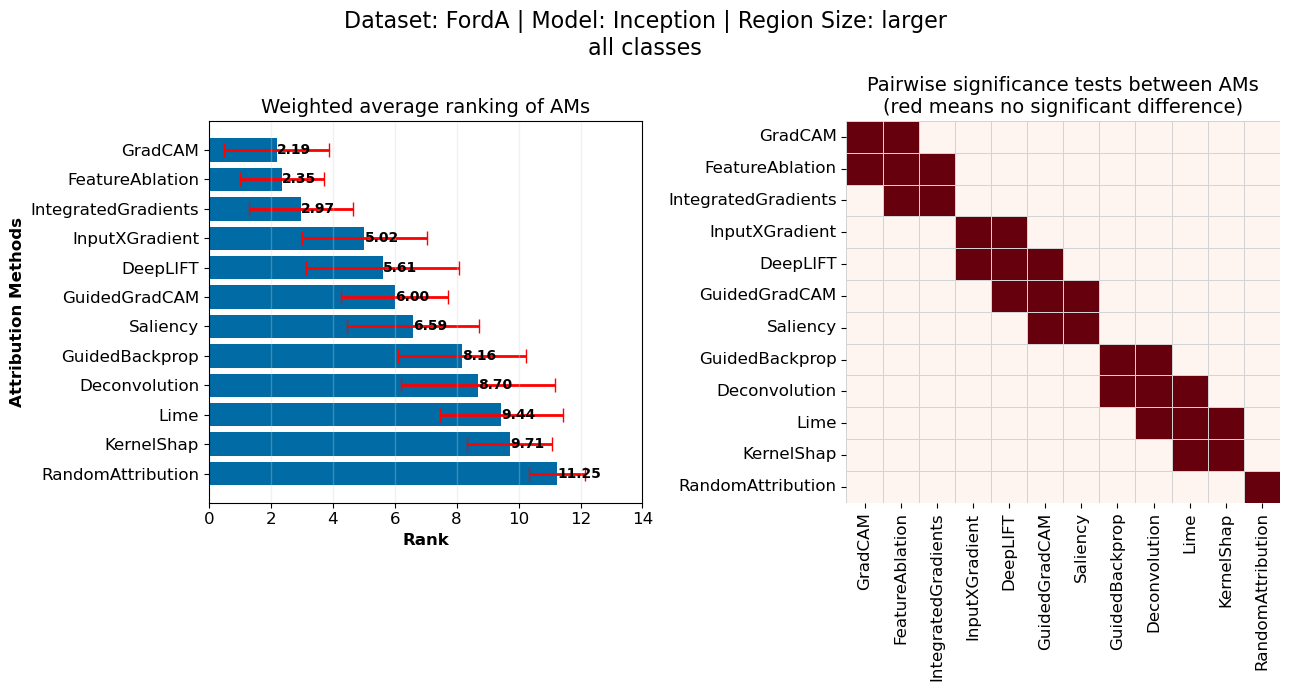

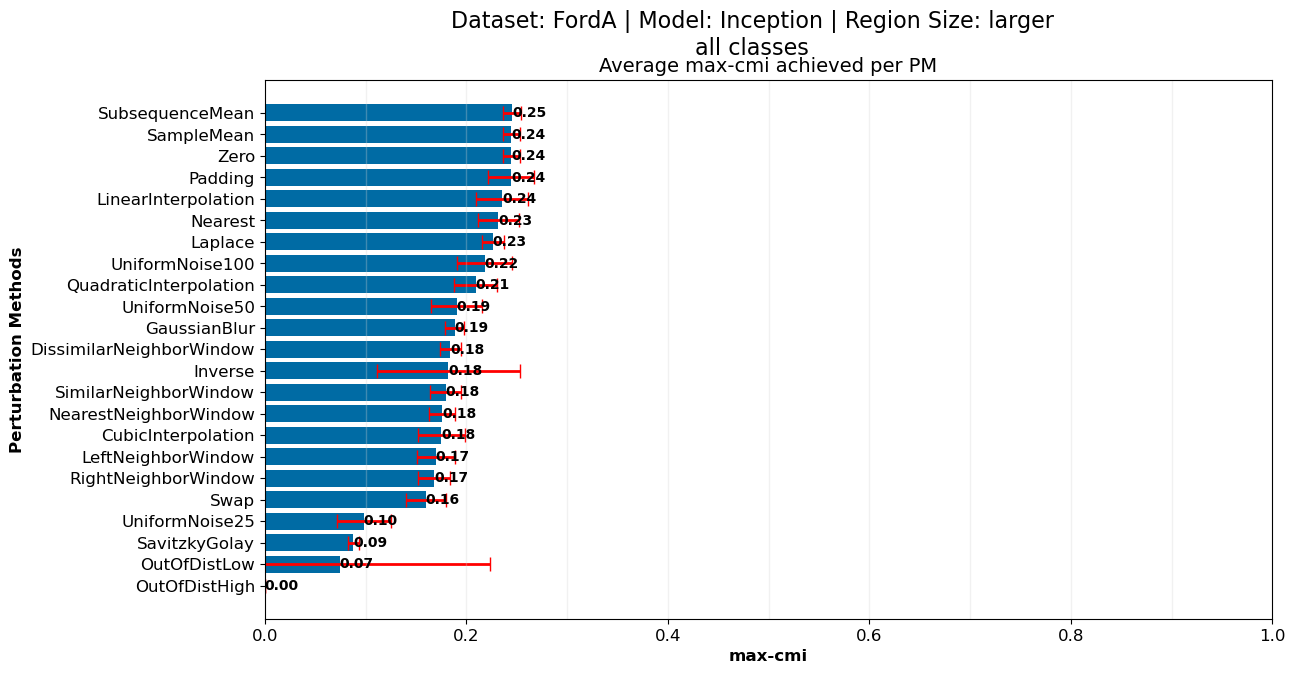

In [9]:
# pre-requisite for compute_average_pm_ranking cell
models = [
    'Inception',
    # 'LSTM',
    # 'MLP',
    # 'ResNet',
    # 'ViT',
]
datasets = [
    'FordA',
    # 'FordB',
    # 'NonInvasiveFetalECGThorax1',
    # 'NonInvasiveFetalECGThorax2',
    # 'Wafer',
]

perturbation_methods = [
    'CubicInterpolation',
    'DissimilarNeighborWindow',
    'GaussianBlur',
    'Inverse',
    'Laplace',
    'LeftNeighborWindow',
    'LinearInterpolation',
    'Nearest',
    'NearestNeighborWindow',
    'OutOfDistHigh',
    'OutOfDistLow',
    'Padding',
    'QuadraticInterpolation',
    'RightNeighborWindow',
    'SampleMean',
    'SavitzkyGolay',
    'SimilarNeighborWindow',
    'SubsequenceMean',
    'Swap',
    'UniformNoise100',
    'UniformNoise25',
    'UniformNoise50',
    'Zero'
    ]

# region_size = 'smaller'
region_size = 'larger'

# class_names = ['all classes - no zero class']
# class_names = ['all classes']

class_names = [
    'all classes',
    # 'all classes - no zero class',
    # '0',
    # '1',
    # '2',
    # '3',
    # '4',
    # '5',
    # '6',
    # '7',
    # '8',
    # '9',
    # '10',
    # '11',
    # '12',
    # '13',
    # '14',
    # '15',
    # '16',
    # '17',
    # '18',
    # '19',
    # '20',
    # '21',
    # '22',
    # '23',
    # '24',
    # '25',
    # '26',
    # '27',
    # '28',
    # '29',
    # '30',
    # '31',
    # '32',
    # '33',
    # '34',
    # '35',
    # '36',
    # '37',
    # '38',
    # '39',
    # '40',
    # '41'
    ]

for dataset in datasets:
    for model in models:
        for class_name in class_names:
            if class_name == 'all classes':
                plot_class_name = class_name
            elif class_name == 'all classes - no zero class':
                plot_class_name = 'all classes (excl. zero class)'
            else:
                plot_class_name = 'class-{}'.format(class_name)

            am_ranks = {}
            am_ranks_filtered = {}
            max_cmis = [] # stores all highest CMI values independent of pm. (1 for each model seed)
            max_cmis_per_pm = {} # stores all highest CMI values for each pm. (1 for each model seed)

            for seed_idx in range(5): #TODO: check if iterating over all seeds!
            # for seed_idx in range(1):
                for pm_idx, pm in enumerate(perturbation_methods):
                    if pm not in max_cmis_per_pm: 
                        max_cmis_per_pm[pm] = []
                    # print('PM: {}/{}'.format(pm_idx+1, len(perturbation_methods)))
                    res_s = rank_ams_by_cmi( dataset=dataset, model=model, region_size=region_size, seed_idx=seed_idx, pm=pm, detailed_output=False, class_name = class_name)
                    # plot_individual_cmi_ranking(res_s, dataset, model, region_size, seed_idx, pm, class_name)
                    
                    max_cmi = None                    
                    for i, r in enumerate(res_s):
                        if r['am'] not in am_ranks:
                            am_ranks[r['am']] = []
                        am_ranks[r['am']].append(i+1)

                        if max_cmi is None:
                            max_cmi = r['cmi-mean']
                            max_cmis.append(max_cmi)
                            max_cmis_per_pm[pm].append(max_cmi)

            # Compute max_CMI^2 adjusted AM rank over all PMs
            avg_am_rank_cmi_2_adjusted = [] # will contain the cmi_max^2 adjusted ranks of each AM over all seeds and PMs
            for am in am_ranks:
                ranks = np.array(am_ranks[am]) # 5 seeds * 23 PMs == 115
                weights = np.array(max_cmis)**2 # squared cmi_max of each ranking - again 5 seeds * 23 PMs == 115

                # calculate weighted statistics: https://stackoverflow.com/a/36464881
                weighted_avg = DescrStatsW(ranks, weights=weights, ddof=0).mean
                weighted_std = DescrStatsW(ranks, weights=weights, ddof=0).std

                avg_am_rank_cmi_2_adjusted.append({
                    'Attribution Method' : am,
                    'ranks' : ranks,
                    'weights' : weights,
                    'Rank (mean)' : weighted_avg,
                    'Rank (std)' : weighted_std,
                }) 
                
            avg_am_rank_cmi_2_adjusted = sorted(avg_am_rank_cmi_2_adjusted, key=lambda x: x['Rank (mean)'], reverse=False)

            # Plot mean max-cmi per PM
            # NOTE: avg_am_rank_cmi_2_adjusted has len(seeds) * len(perturbation_methods)  (115) values per AM since we aggregate over all PMs and Seeds per dataset and model
            plot_mean_am_rank_and_significance_tests(avg_am_rank_cmi_2_adjusted, dataset, model, region_size, plot_class_name)

            # Plot mean max-cmi per PM
            # NOTE: max_cmis_per_pm should have len(seeds) (5) number of values, since we only show the cmi_max of a PM over all AMs for each seed
            plot_avg_pm_cmi(max_cmis_per_pm, dataset, model, region_size, plot_class_name)

In [10]:
# Compute average PM ranking, over all datasets and models
# [NOTE] Pre-requisite: for all datasets and models and region sizes, the "pre-requisite for compute_average_pm_ranking" cell has to finish computing with 'all classes'.
# uses DATASET_MODEL_REGION_SIZE_all classes_pm_avg_max_cmi.csv files
def compute_average_pm_ranking(models, datasets, region_sizes):
    # iterate over .csv results files and store ranks of each pm
    pm_ranks = {}
    for rs in region_sizes:
        for dataset in datasets:
            for model in models:
                csv_path = os.path.join(results_dir,'region size - {}'.format(rs), dataset, '{}_{}_{}_all classes_pm_avg_max_cmi.csv'.format(dataset,model,rs))
                df = pd.read_csv(csv_path)
                for index, row in df.iterrows():
                    pm = row['pm']
                    if pm not in pm_ranks:
                        pm_ranks[pm] = []
                    pm_ranks[pm].append(index+1)

    # compute mean and std of each pm
    pm_avg_rank = []
    for pm in pm_ranks:
        pm_avg_rank.append({
            'pm' : pm,
            'rank (mean)' : np.array(pm_ranks[pm]).mean(),
            'rank (std)' : np.array(pm_ranks[pm]).std()
        })
    pm_avg_rank = sorted(pm_avg_rank, key=lambda x: x['rank (mean)'], reverse=True)


    # Plot results
    pm_df = pd.DataFrame(pm_avg_rank)

    fig, axs = plt.subplots(1,2, figsize=(18,7))
    ax = axs[0]
    bars = ax.barh(pm_df['pm'], pm_df['rank (mean)'])
    ax.set_xlim(0,len(pm_df))
    ax.set_title('Mean PM rank over all datasets, models and region sizes\n(smaller is better)', fontsize=16)

    fig.set_facecolor('white')

    ax.errorbar(pm_df['rank (mean)'], range(len(pm_df)), xerr=pm_df['rank (std)'], fmt='none', ecolor='red', capsize=5, linewidth = 2)

    # Add semi-transparent vertical lines at every n steps
    n = 1  # Number of steps between lines
    for i in np.arange(n, len(pm_df), n):
        ax.axvline(x=i, color='lightgray', alpha=0.3, linewidth=1)

    # Add value labels to each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, '{:.2f}'.format(width), ha='left', va='center', fontweight='bold')

    # Set labels and title
    ax.set_xlabel('Rank', fontsize=12, fontweight='bold')
    ax.set_ylabel('Perturbation Methods', fontsize=12, fontweight='bold')
    # ax.set_title('Average rank achieved per PM', fontsize=14)

    # # store all results
    # plt_res_dir = os.path.join(results_dir, 'region size - {}'.format(region_size), dataset)
    # if not os.path.exists(plt_res_dir):
    #     os.makedirs(plt_res_dir)
    # base_file_name = '{}_{}_{}_{}'.format(dataset, model, region_size, plot_class_name)

    # # store plot
    # plt.savefig(os.path.join(plt_res_dir, '{}_pm_avg_max_cmi_plot.png'.format(base_file_name)), bbox_inches='tight')

    # float_format = '%.4f'  # decimal places
    # # store .csv
    # pm_df[::-1].to_csv(os.path.join(plt_res_dir, '{}_pm_avg_max_cmi.csv'.format(base_file_name)), float_format=float_format, index=False)

    pm_avg_rank = pm_avg_rank[::-1]

    # Significance tests between ranks
    sig_diff_matrix = []
    significance_test_results = []
    n_comparisons = len(pm_avg_rank) - 1
    labels = []
    for i in range(len(pm_avg_rank)):
        pm_i_name = pm_avg_rank[i]['pm']
        significance_test_row = {
            '-' : pm_i_name,
        }
        labels.append(pm_i_name)

        pm_1_ranks = np.array(pm_ranks[pm_i_name])
        sig_diffs = []
        for j in range(len(pm_avg_rank)):
            pm_j_name = pm_avg_rank[j]['pm']
            pm_2_ranks = np.array(pm_ranks[pm_j_name])
            # am_2_weights = avg_am_rank_cmi_2_adjusted[j]['weights']

            # Calculate the differences between paired observations
            differences = pm_1_ranks - pm_2_ranks

            if np.all(differences == 0):
                sig_diffs.append(False)
                significance_test_row['{} - test statistic'.format(pm_j_name)] = None
                significance_test_row['{} - p-value'.format(pm_j_name)] = None
                continue

            # wilcoxon test chosen, because it often happens that differences are not normally distributed
            stat, p_value = wilcoxon(pm_1_ranks, pm_2_ranks)

            sig_diffs.append(p_value < (0.05 / n_comparisons)) # with bonferonni correction
            # sig_diffs.append(p_value < (0.05 ))

            significance_test_row['{} - test statistic'.format(pm_j_name)] = stat
            significance_test_row['{} - p-value'.format(pm_j_name)] = p_value
        significance_test_results.append(significance_test_row)

        sig_diff_matrix.append(sig_diffs)

    sns.heatmap(sig_diff_matrix, annot=False, fmt="d", cmap="Reds_r", vmin=0, vmax=1, xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='lightgray', ax=axs[1], cbar=False)
    axs[1].set_title('Pairwise significance tests between PMs\n(red means no significant difference)', fontsize=16)

    plt.subplots_adjust(wspace=0.6)
    plt.show()

### Compute average PM max-CMI, over all datasets and models

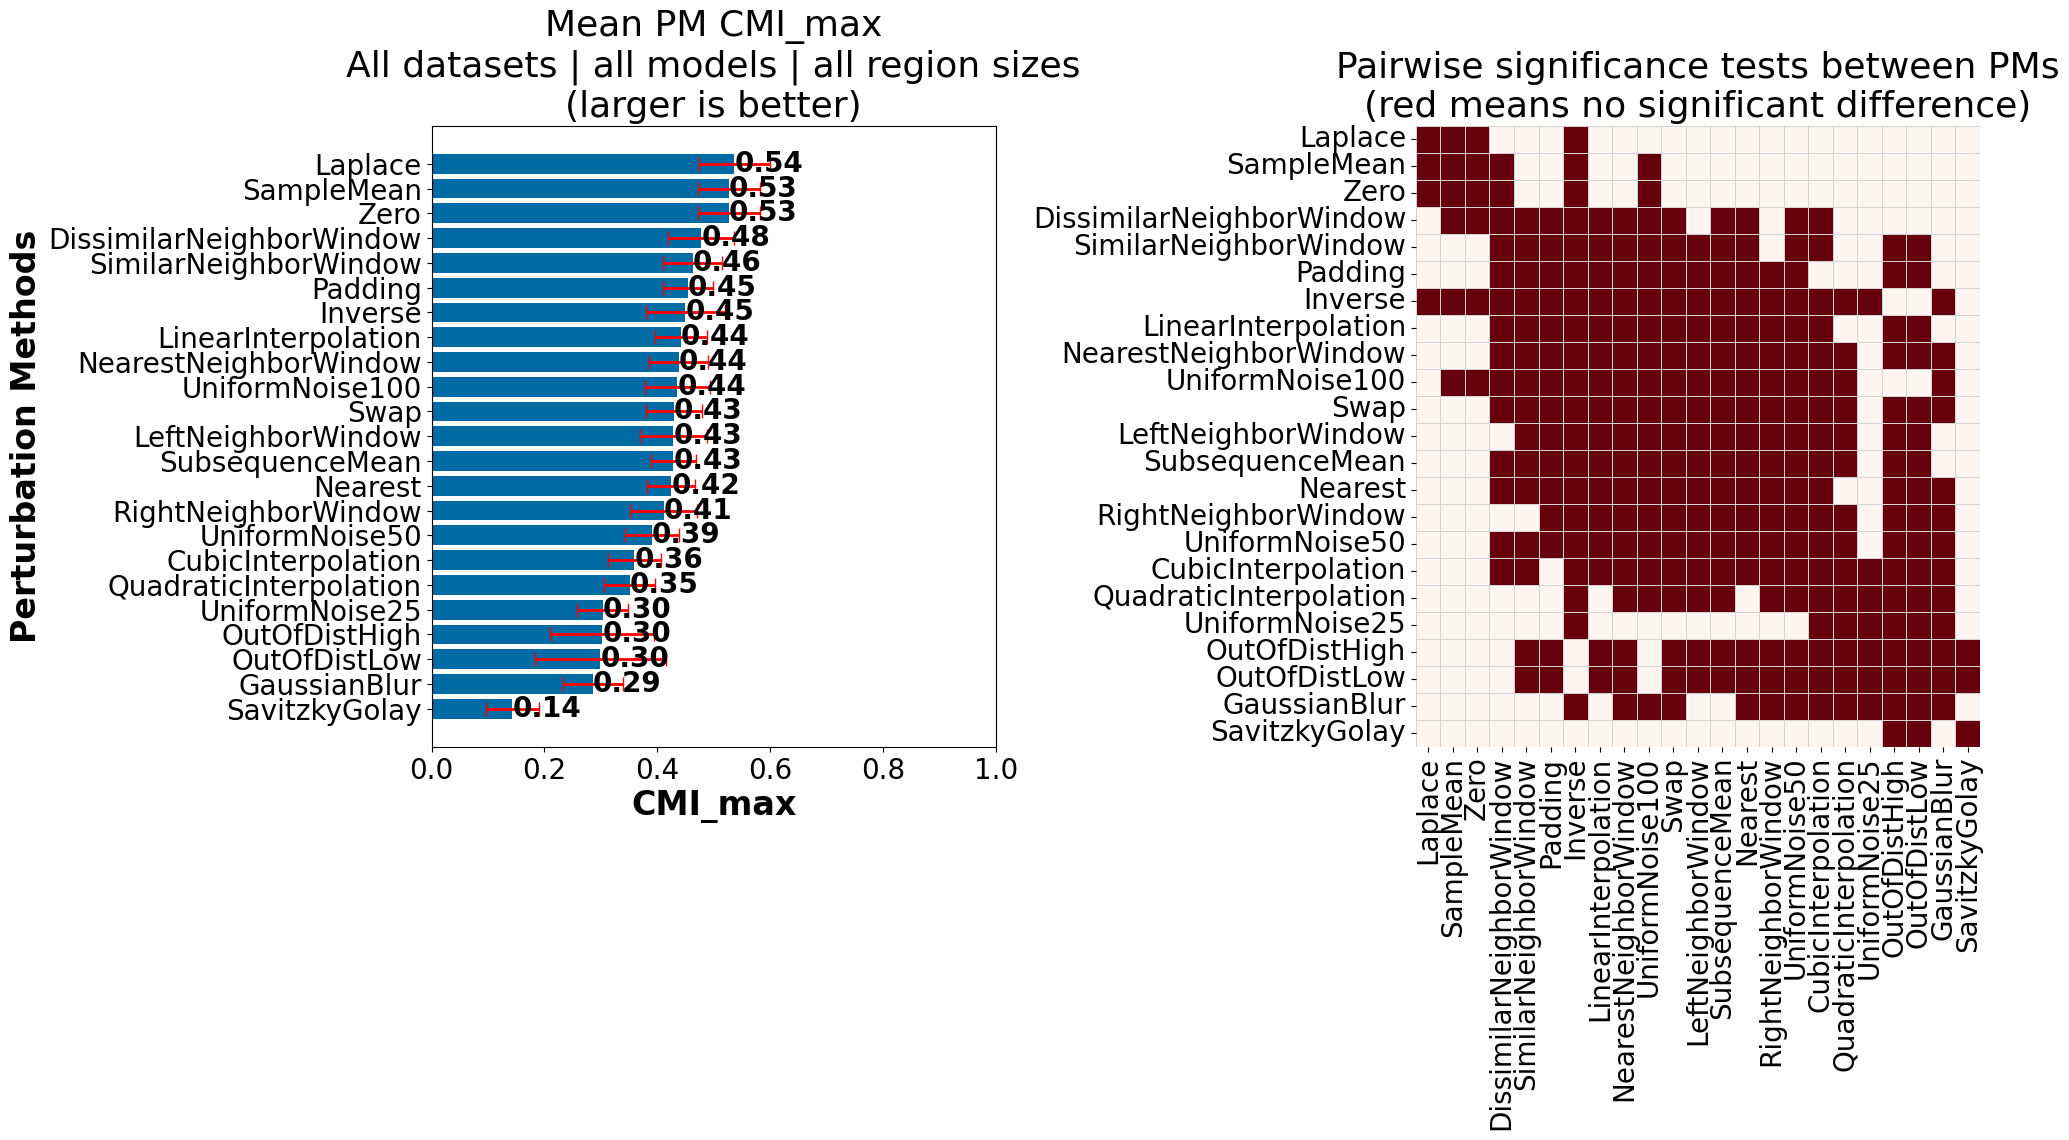

[{'pm': 'Laplace',
  'max-cmi (mean)': 0.5364860000000001,
  'max-cmi (std)': 0.06296948327001875},
 {'pm': 'SampleMean',
  'max-cmi (mean)': 0.5265460000000001,
  'max-cmi (std)': 0.054886948434338514},
 {'pm': 'Zero',
  'max-cmi (mean)': 0.5265420000000001,
  'max-cmi (std)': 0.05488476061523056},
 {'pm': 'DissimilarNeighborWindow',
  'max-cmi (mean)': 0.47793800000000025,
  'max-cmi (std)': 0.05869772304581373},
 {'pm': 'SimilarNeighborWindow',
  'max-cmi (mean)': 0.4628580000000001,
  'max-cmi (std)': 0.05221973960888045},
 {'pm': 'Padding',
  'max-cmi (mean)': 0.45415999999999984,
  'max-cmi (std)': 0.04374207214458419},
 {'pm': 'Inverse',
  'max-cmi (mean)': 0.44963000000000003,
  'max-cmi (std)': 0.07039184788735117},
 {'pm': 'LinearInterpolation',
  'max-cmi (mean)': 0.44186400000000015,
  'max-cmi (std)': 0.046106344248049845},
 {'pm': 'NearestNeighborWindow',
  'max-cmi (mean)': 0.4383919999999999,
  'max-cmi (std)': 0.052234449848773325},
 {'pm': 'UniformNoise100',
  'max-cm

In [13]:
# Compute average PM CMI_max, over all datasets and models
# [NOTE] Pre-requisite: for all datasets and models and region sizes, the "pre-requisite for compute_average_pm_ranking" cell has to finish computing with 'all classes'.
# uses DATASET_MODEL_REGION_SIZE_all classes_pm_avg_max_cmi.csv files
from statsmodels.stats.multitest import multipletests

def compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, datasets, region_sizes, significance_tests = True, title=None, show_plot = True, use_bonferonni=True, fname=None):
    """
    Compute the mean CMI_max of each PM over a set of models, datasets, region_sizes

    Args:
        models (list of strings)
        datasets (list of strings)
        region_sizes (list of strings)
        significance_tests (bool) - if pairwise significance tests should be performed between the PMs
        title (string) - title of generated results plot
        show_plot (boolean) - if the plot shoul d be displayed in the notebook

    Returns:
        pm_mean_cmis (list) - list of PMs with their mean CMI_max over all provided models, datasets and region_sizes
    """

    ticks_fontsize = 15
    axis_label_fontsize = 19
    axs_title_fontsize = 21
    modifier = 5
    
    
    # iterate over .csv results files and store ranks of each pm
    pm_max_cmis = {}
    for rs in region_sizes:
        for dataset in datasets:
            for model in models:
                csv_path = os.path.join(results_dir,'region size - {}'.format(rs), dataset, '{}_{}_{}_all classes_pm_avg_max_cmi.csv'.format(dataset,model,rs))
                df = pd.read_csv(csv_path)
                for index, row in df.iterrows():
                    pm = row['pm']
                    if pm not in pm_max_cmis:
                        pm_max_cmis[pm] = {
                            'mean' : [],
                            'std' : [],
                        }
                    pm_max_cmis[pm]['mean'].append(row['max-cmi (mean)'])
                    pm_max_cmis[pm]['std'].append(row['max-cmi (std)'])

    # compute mean and std of each pm
    pm_mean_cmis = []
    for pm in pm_max_cmis:
        pm_mean_cmis.append({
            'pm' : pm,
            'max-cmi (mean)' : combined_mean(pm_max_cmis[pm]['mean']),
            'max-cmi (std)' : combined_stddev(pm_max_cmis[pm]['std'], np.ones_like(pm_max_cmis[pm]['std'])*5) # num elements for combined stddev is 5, since the mean and std are always computed over the 5 model seeds
        })
    pm_mean_cmis = sorted(pm_mean_cmis, key=lambda x: x['max-cmi (mean)'], reverse=False)

    if show_plot:
        # Plot results
        pm_df = pd.DataFrame(pm_mean_cmis)

        if significance_tests:
            fig, axs = plt.subplots(1,2, figsize=(20,11.5))
            ax = axs[0]
        else:
            fig, ax = plt.subplots(1,1, figsize=(9,9))
        bars = ax.barh(pm_df['pm'], pm_df['max-cmi (mean)'])
        ax.set_xlim(0,1)

        if title is None:
            ax.set_title('Mean PM CMI_max over all datasets, models and region sizes\n(larger is better)', fontsize=axs_title_fontsize)
        else:
            ax.set_title('{}\n(larger is better)'.format(title), fontsize=axs_title_fontsize+modifier)

        fig.set_facecolor('white')

        ax.errorbar(pm_df['max-cmi (mean)'], range(len(pm_df)), xerr=pm_df['max-cmi (std)'], fmt='none', ecolor='red', capsize=5, linewidth = 2)
        ax.tick_params(axis='y', labelsize=ticks_fontsize+modifier)
        ax.tick_params(axis='x', labelsize=ticks_fontsize+modifier)

        # Add semi-transparent vertical lines at every n steps
        n = 1  # Number of steps between lines
        for i in np.arange(n, len(pm_df), n):
            ax.axvline(x=i, color='lightgray', alpha=0.3, linewidth=1)

        # Add value labels to each bar
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, '{:.2f}'.format(width), ha='left', va='center', fontweight='bold', fontsize=ticks_fontsize+modifier)

        # Set labels and title
        ax.set_xlabel('CMI_max', fontsize=axis_label_fontsize+modifier, fontweight='bold')
        ax.set_ylabel('Perturbation Methods', fontsize=axis_label_fontsize+modifier, fontweight='bold')
        # ax.set_title('Average rank achieved per PM', fontsize=14)

        # # store all results
        # plt_res_dir = os.path.join(results_dir, 'region size - {}'.format(region_size), dataset)
        # if not os.path.exists(plt_res_dir):
        #     os.makedirs(plt_res_dir)
        # base_file_name = '{}_{}_{}_{}'.format(dataset, model, region_size, plot_class_name)

        # # store plot
        # plt.savefig(os.path.join(plt_res_dir, '{}_pm_avg_max_cmi_plot.png'.format(base_file_name)), bbox_inches='tight')

        # float_format = '%.4f'  # decimal places
        # # store .csv
        # pm_df[::-1].to_csv(os.path.join(plt_res_dir, '{}_pm_avg_max_cmi.csv'.format(base_file_name)), float_format=float_format, index=False)

        # XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        if fname is not None:
            os.makedirs(f'{results_dir}/individual_tests', exist_ok=True)
            pm_df.to_csv(f'{results_dir}/individual_tests/{fname}.csv', index=False)

        if significance_tests:
            pm_mean_cmis = pm_mean_cmis[::-1]

            # Significance tests between ranks
            sig_diff_matrix = []
            p_val_matrix = []
            significance_test_results = []
            n_comparisons = len(pm_mean_cmis) - 1
            labels = []
            for i in range(len(pm_mean_cmis)):
                pm_i_name = pm_mean_cmis[i]['pm']
                significance_test_row = {
                    '-' : pm_i_name,
                }
                labels.append(pm_i_name)

                pm_1_ranks = np.array(pm_max_cmis[pm_i_name]['mean'])
                sig_diffs = []
                p_vals_row = []
                for j in range(len(pm_mean_cmis)):
                    pm_j_name = pm_mean_cmis[j]['pm']
                    pm_2_ranks = np.array(pm_max_cmis[pm_j_name]['mean'])
                    # am_2_weights = avg_am_rank_cmi_2_adjusted[j]['weights']

                    # Calculate the differences between paired observations
                    differences = pm_1_ranks - pm_2_ranks

                    if np.all(differences == 0):
                        p_vals_row.append(np.nan)
                        sig_diffs.append(False)
                        significance_test_row['{} - test statistic'.format(pm_j_name)] = None
                        significance_test_row['{} - p-value'.format(pm_j_name)] = None
                        continue


                    # wilcoxon test chosen, because it often happens that differences are not normally distributed
                    stat, p_value = wilcoxon(pm_1_ranks, pm_2_ranks)
                    p_vals_row.append(p_value)
                    if use_bonferonni:
                        sig_diffs.append(p_value < (0.05 / n_comparisons)) # with bonferonni correction
                    else:
                        sig_diffs.append(p_value < (0.05 ))

                    significance_test_row['{} - test statistic'.format(pm_j_name)] = stat
                    significance_test_row['{} - p-value'.format(pm_j_name)] = p_value
                significance_test_results.append(significance_test_row)
                p_val_matrix.append(p_vals_row)
                sig_diff_matrix.append(sig_diffs)

            # Holm-Bonferonni correction
            p_val_matrix = np.array(p_val_matrix)
            p_val_matrix_flat = p_val_matrix.reshape(-1)
            rejected, corrected_p_values, _, _ = multipletests(p_val_matrix_flat, alpha=0.05, method='holm')
            p_val_matrix_corrected = corrected_p_values.reshape(p_val_matrix.shape)

            p_val_matrix_corrected = np.nan_to_num(p_val_matrix_corrected, nan=1)

            # p_val_matrix_corrected[]
            sig_diff_matrix_corrected = p_val_matrix_corrected < 0.05

            sig_df = pd.DataFrame(significance_test_results)
            if fname is not None:
                sig_df.to_csv(f'{results_dir}/individual_tests/{fname}_sig_tests_uncorrected.csv', index=False)
            
            p_val_cols = [s for s in sig_df.columns if 'p-value' in s]
            sig_df_corrected = sig_df.copy()
            for col_idx, col_name in enumerate(p_val_cols):
                sig_df_corrected[col_name] = p_val_matrix_corrected[col_idx]

            if fname is not None:
                sig_df_corrected.to_csv(f'{results_dir}/individual_tests/{fname}_sig_tests_holm_corrected.csv', index=False)

            # sns.heatmap(sig_diff_matrix, annot=False, fmt="d", cmap="Reds_r", vmin=0, vmax=1, xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='lightgray', ax=axs[1], cbar=False)
            sns.heatmap(sig_diff_matrix_corrected, annot=False, fmt="d", cmap="Reds_r", vmin=0, vmax=1, xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='lightgray', ax=axs[1], cbar=False)
            # if use_bonferonni:
            axs[1].set_title('Pairwise significance tests between PMs\n(red means no significant difference)', fontsize=axs_title_fontsize+modifier)
            # else:
                # axs[1].set_title('Pairwise significance tests between PMs\nno Bonferonni correction\n(red means no significant difference)', fontsize=axs_title_fontsize+modifier)
            axs[1].tick_params(axis='y', labelsize=ticks_fontsize+modifier)
            axs[1].tick_params(axis='x', labelsize=ticks_fontsize+modifier)

            # plt.subplots_adjust(wspace=0.6)
            plt.tight_layout()
        if fname is not None:
            plt.savefig(f'{results_dir}/individual_tests/{fname}.png', bbox_inches='tight')
        plt.show()
    return pm_mean_cmis


models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, datasets, region_sizes, significance_tests = True, title='Mean PM CMI_max\nAll datasets | all models | all region sizes', fname='PM_CMI_max_ALL')

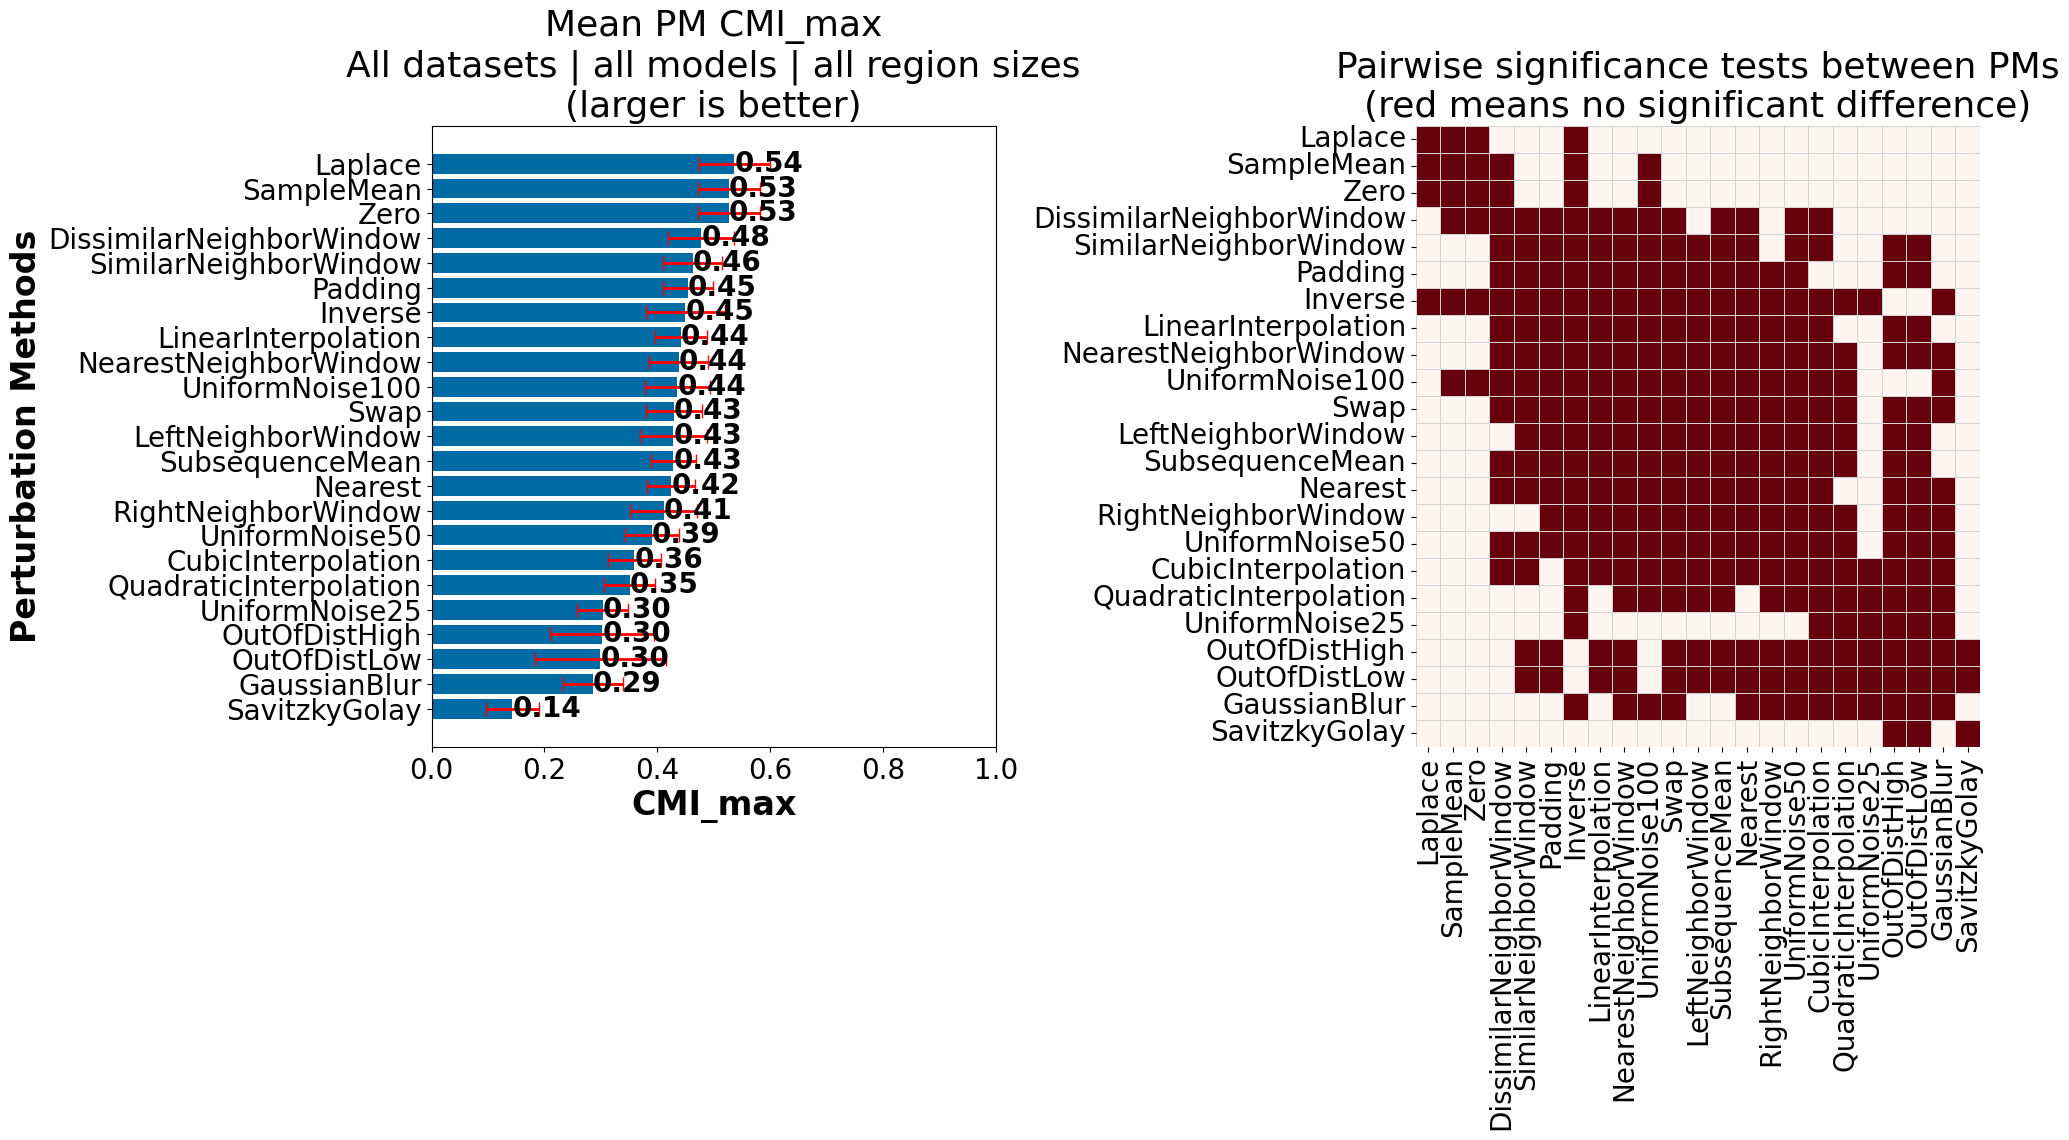

[{'pm': 'Laplace',
  'max-cmi (mean)': 0.5364860000000001,
  'max-cmi (std)': 0.06296948327001875},
 {'pm': 'SampleMean',
  'max-cmi (mean)': 0.5265460000000001,
  'max-cmi (std)': 0.054886948434338514},
 {'pm': 'Zero',
  'max-cmi (mean)': 0.5265420000000001,
  'max-cmi (std)': 0.05488476061523056},
 {'pm': 'DissimilarNeighborWindow',
  'max-cmi (mean)': 0.47793800000000025,
  'max-cmi (std)': 0.05869772304581373},
 {'pm': 'SimilarNeighborWindow',
  'max-cmi (mean)': 0.4628580000000001,
  'max-cmi (std)': 0.05221973960888045},
 {'pm': 'Padding',
  'max-cmi (mean)': 0.45415999999999984,
  'max-cmi (std)': 0.04374207214458419},
 {'pm': 'Inverse',
  'max-cmi (mean)': 0.44963000000000003,
  'max-cmi (std)': 0.07039184788735117},
 {'pm': 'LinearInterpolation',
  'max-cmi (mean)': 0.44186400000000015,
  'max-cmi (std)': 0.046106344248049845},
 {'pm': 'NearestNeighborWindow',
  'max-cmi (mean)': 0.4383919999999999,
  'max-cmi (std)': 0.052234449848773325},
 {'pm': 'UniformNoise100',
  'max-cm

In [14]:
# [FIGURE] PM Choice insights default PMS across all models datasets and region sizes
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, datasets, region_sizes, significance_tests = True, title='Mean PM CMI_max\nAll datasets | all models | all region sizes')


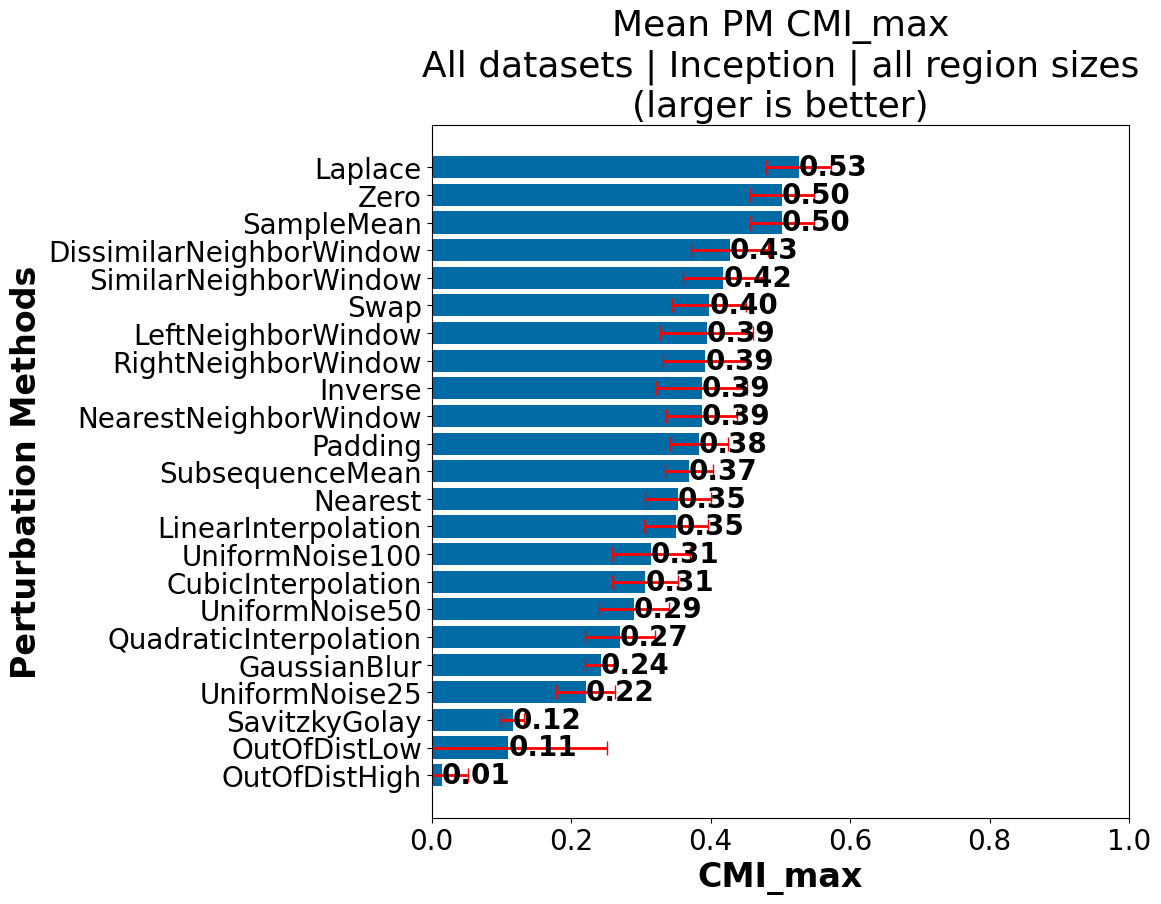

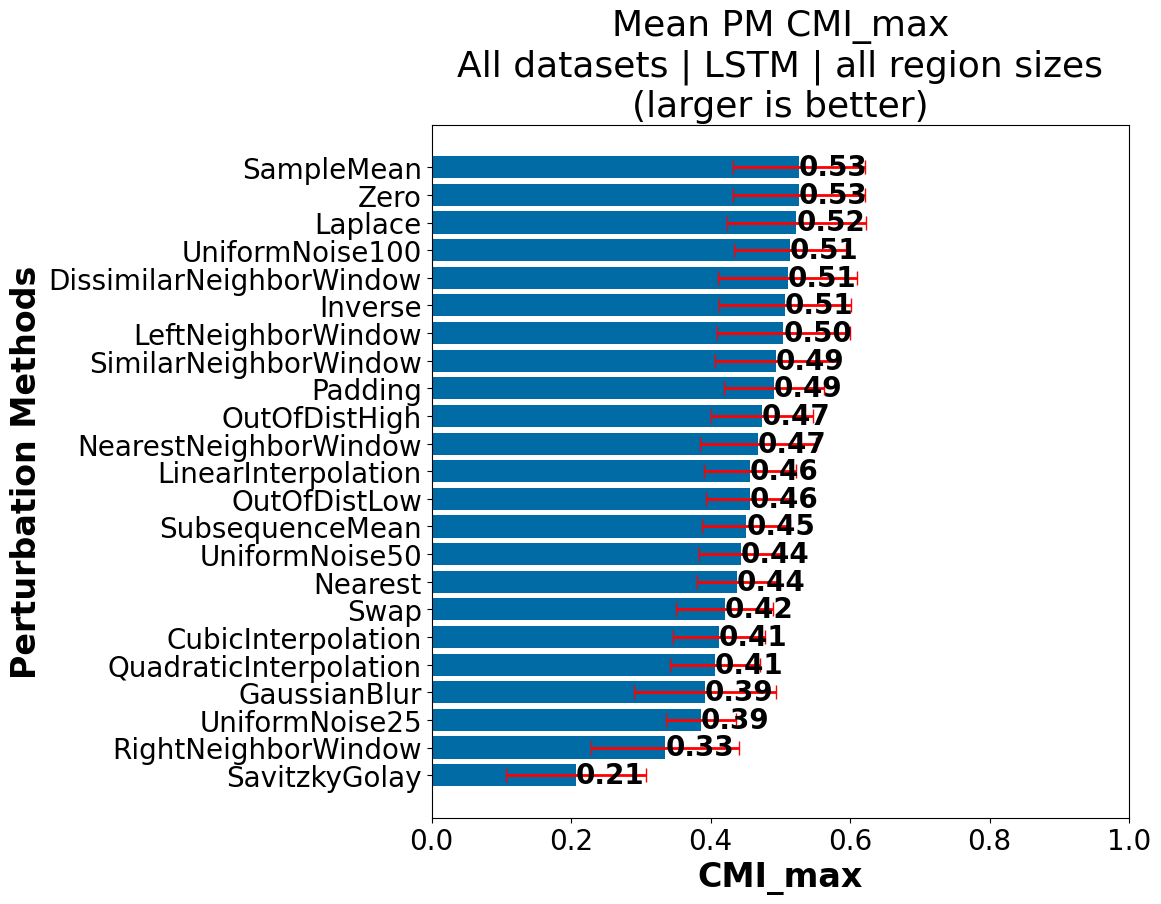

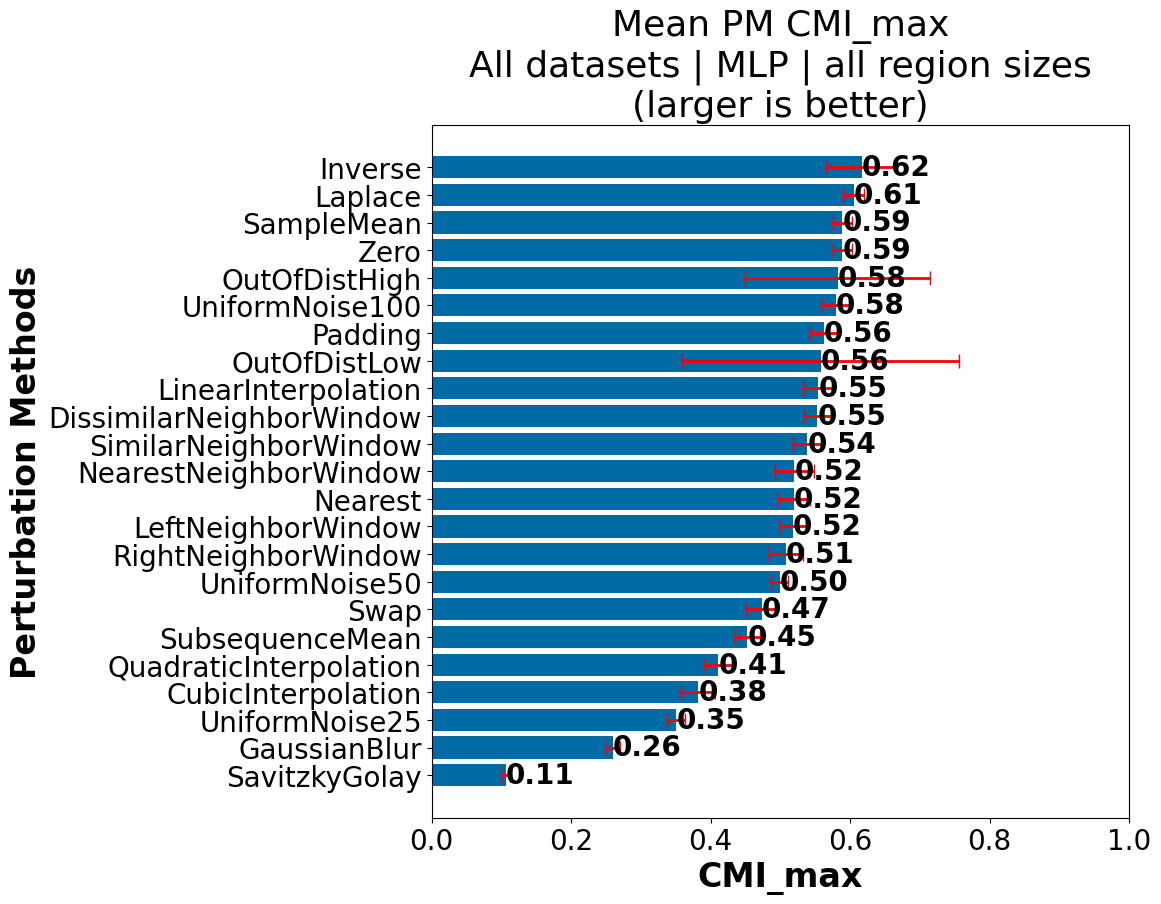

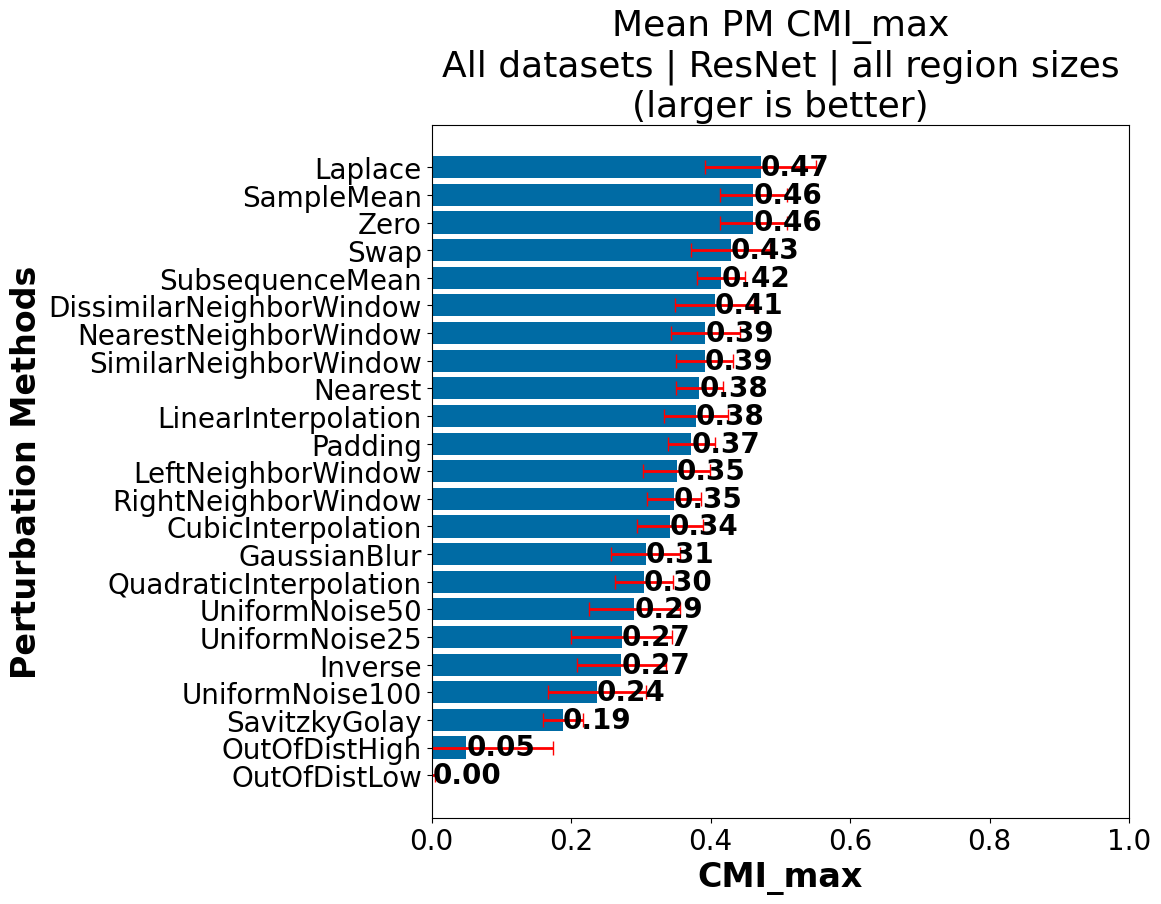

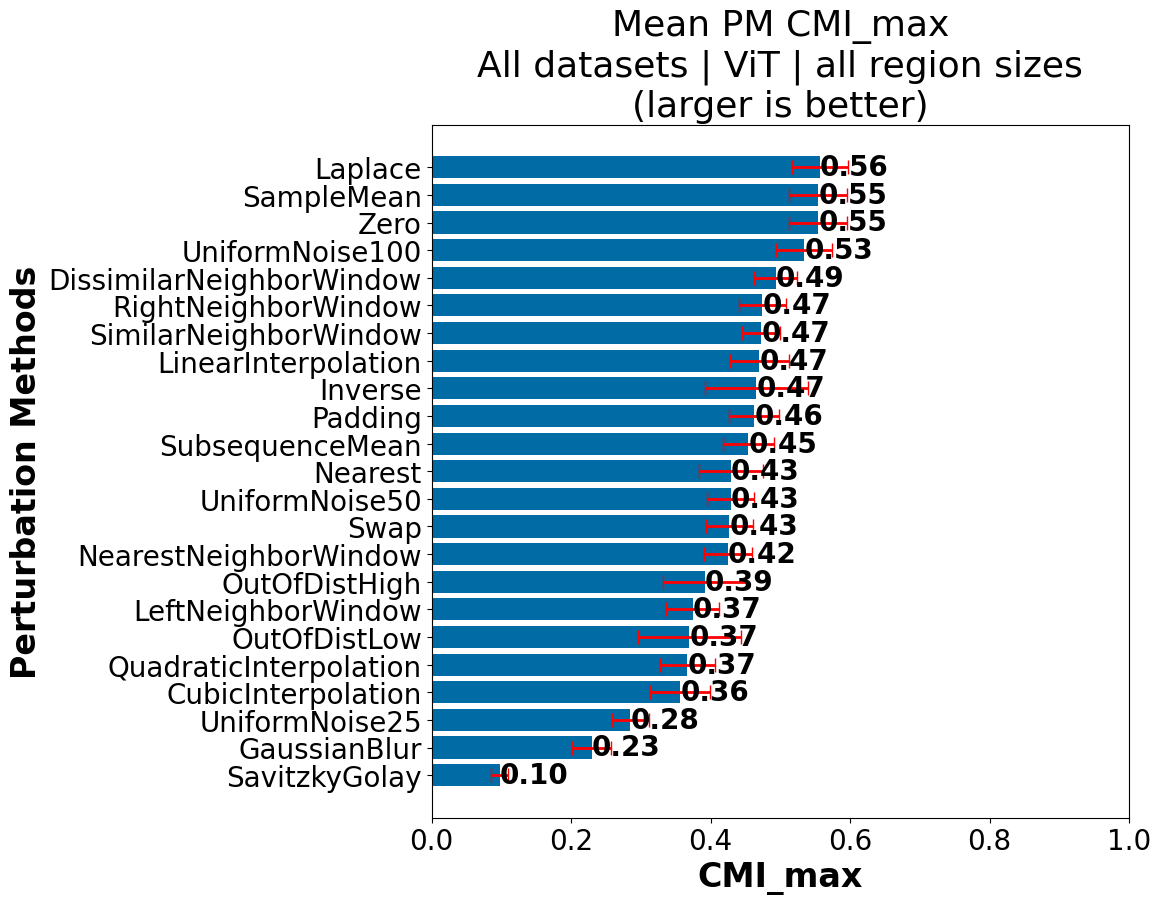

In [15]:
# [FIGURE] PM Choice insights PMS for individual models
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
for m in models:
    compute_mean_cmi_max_pm_ranking_holm_bonferroni([m], datasets, region_sizes, significance_tests = False, title=f'Mean PM CMI_max\nAll datasets | {m} | all region sizes', fname=f'PM_CMI_max_ALL_{m}')
    

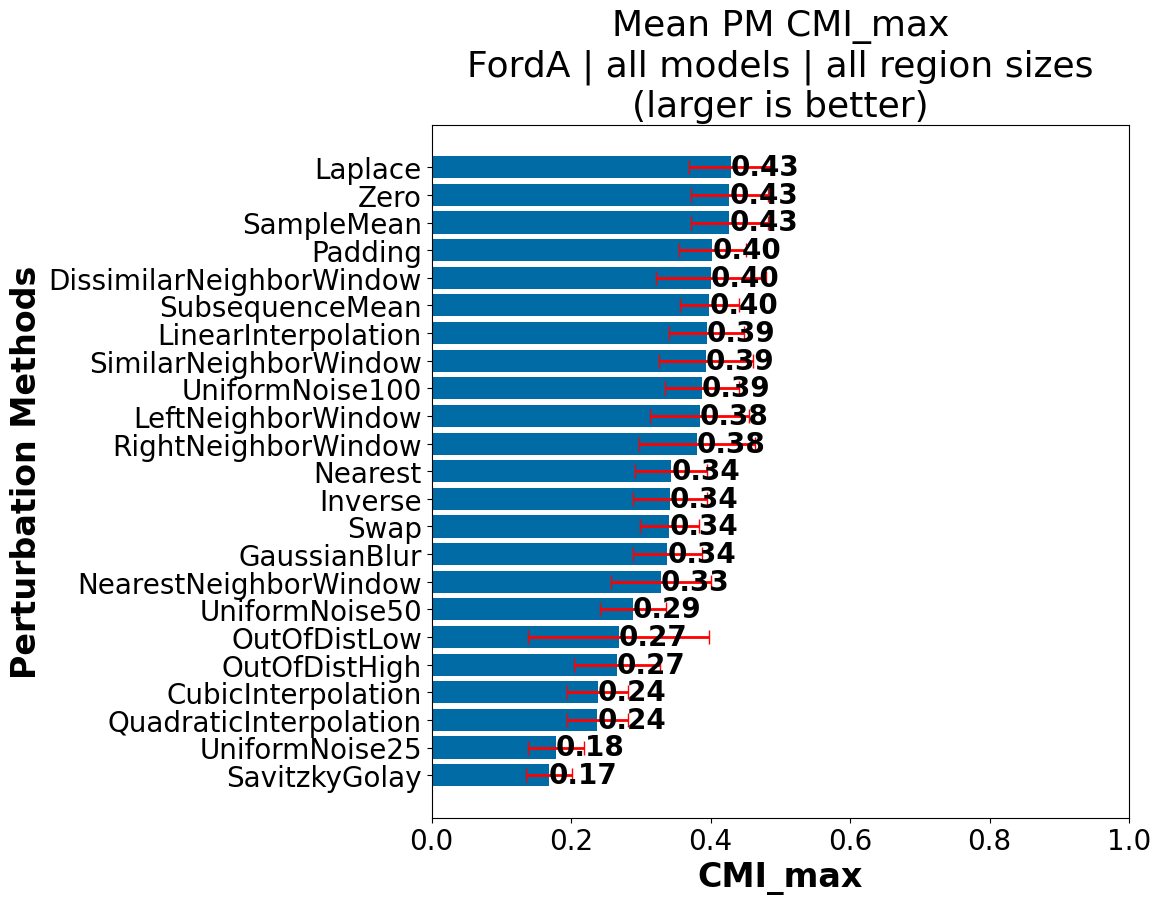

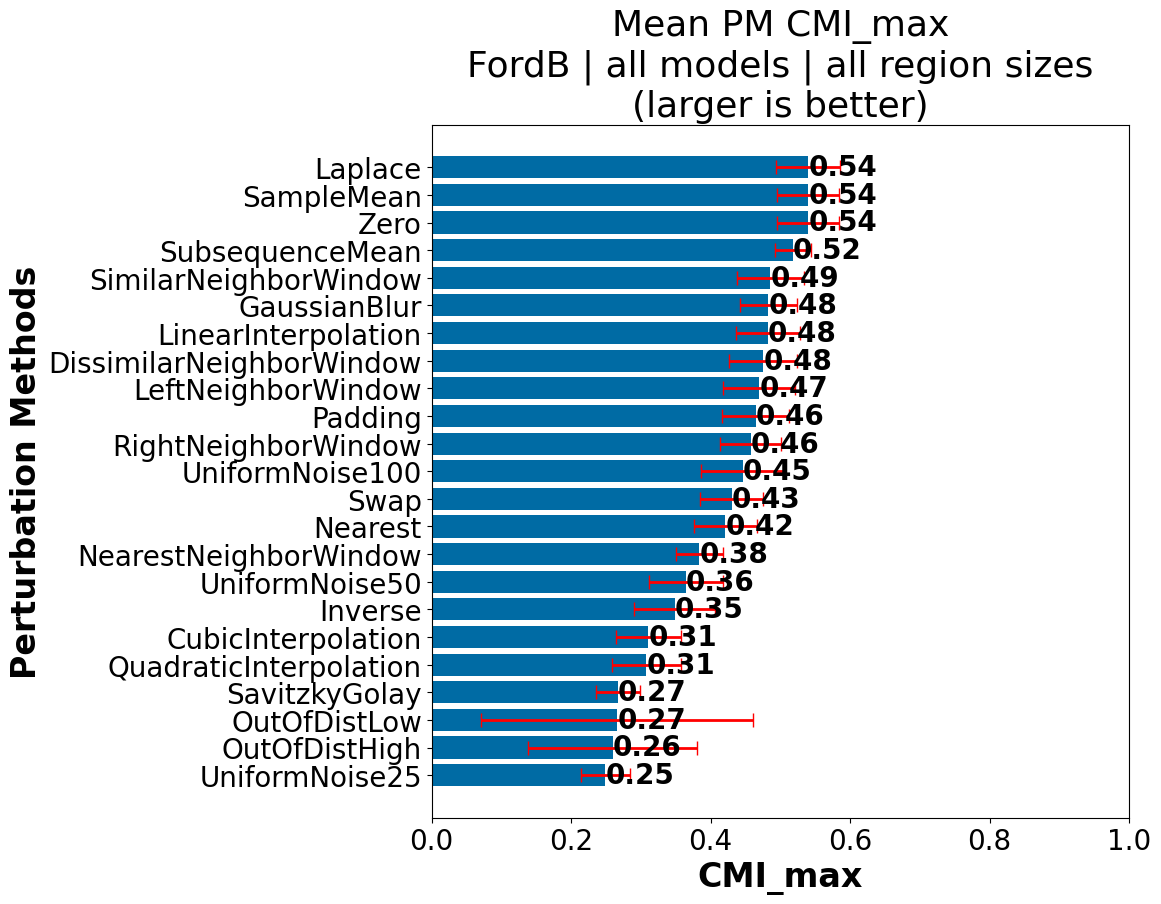

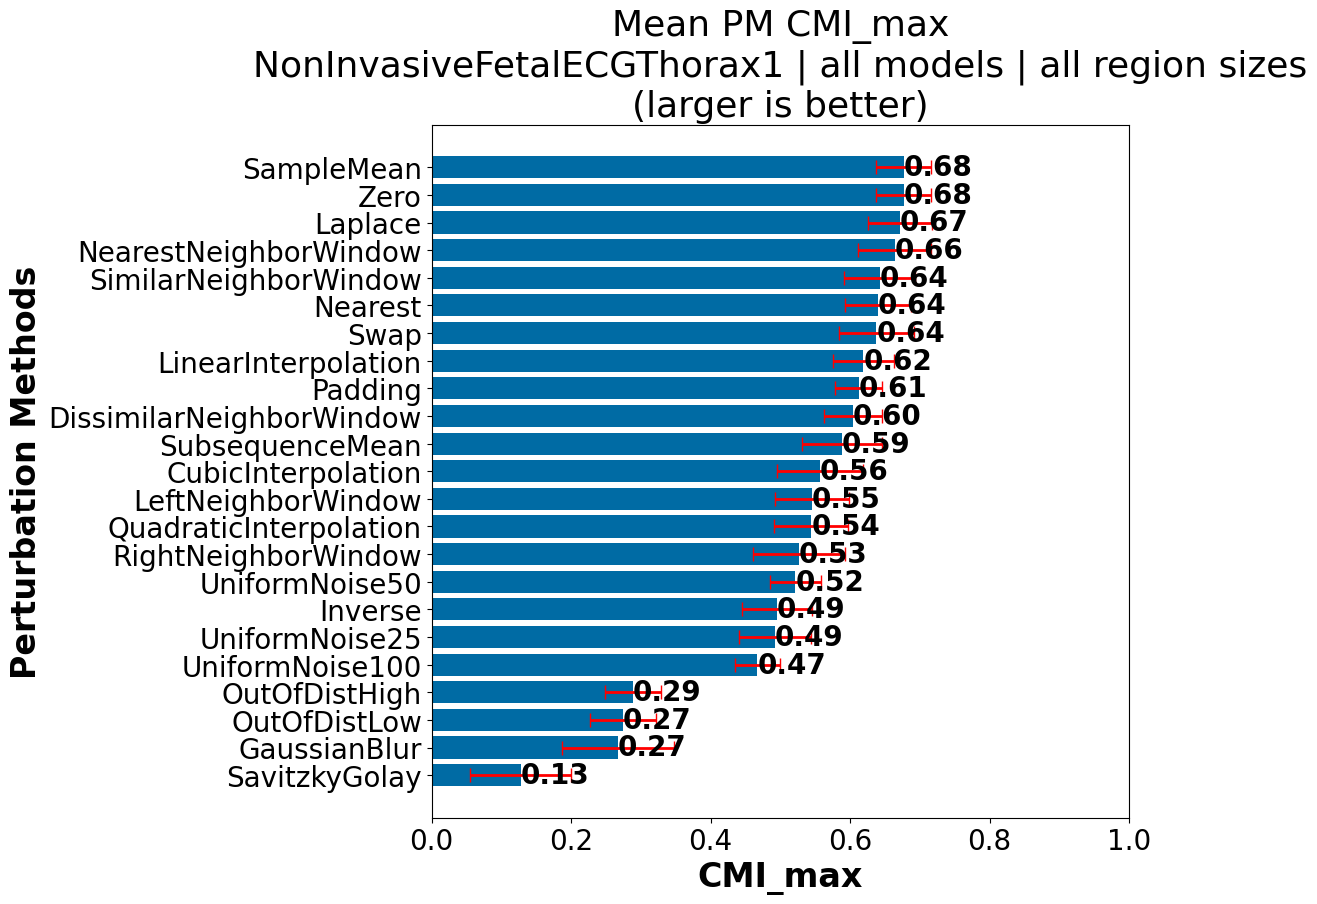

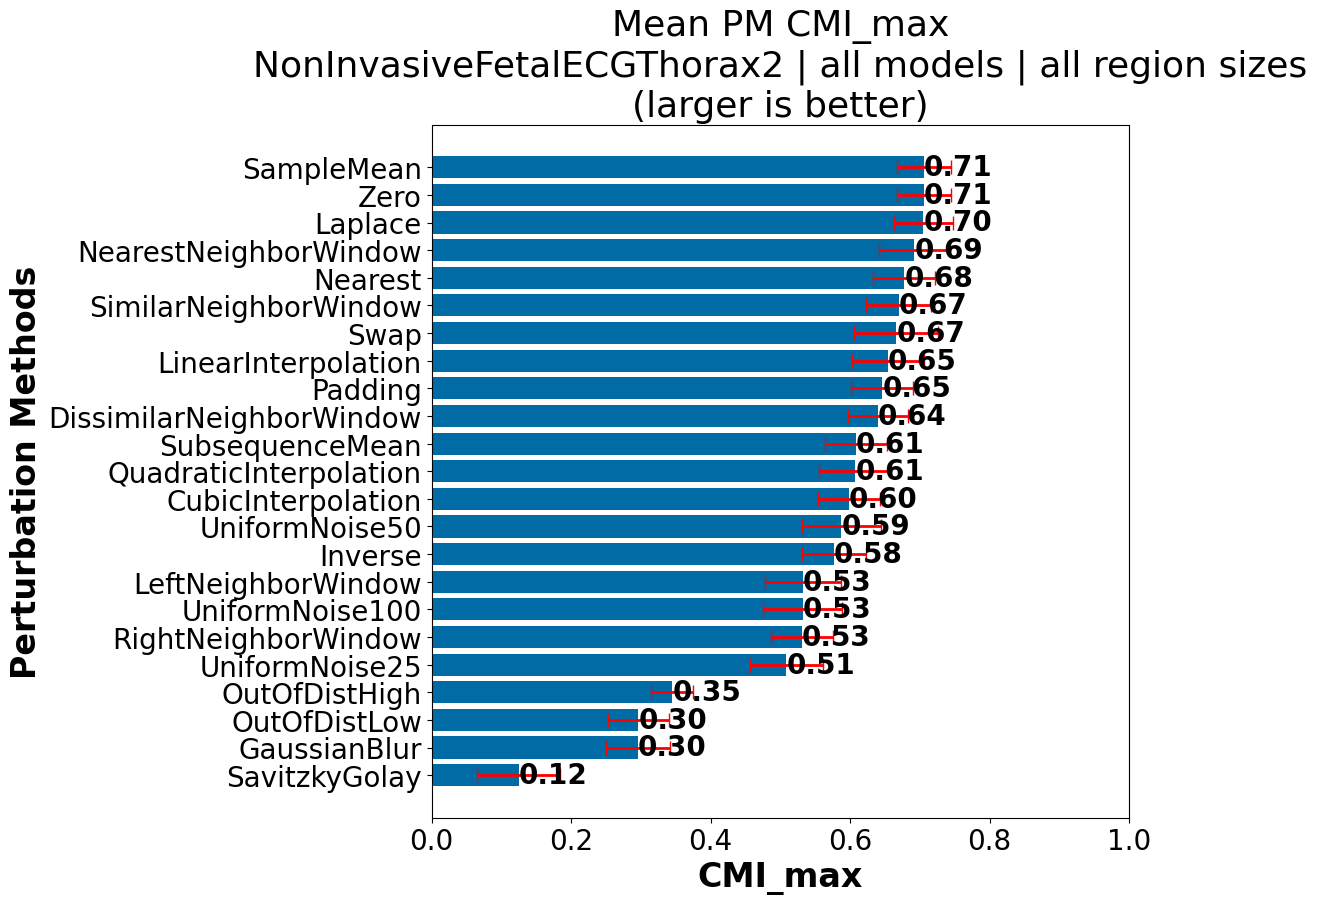

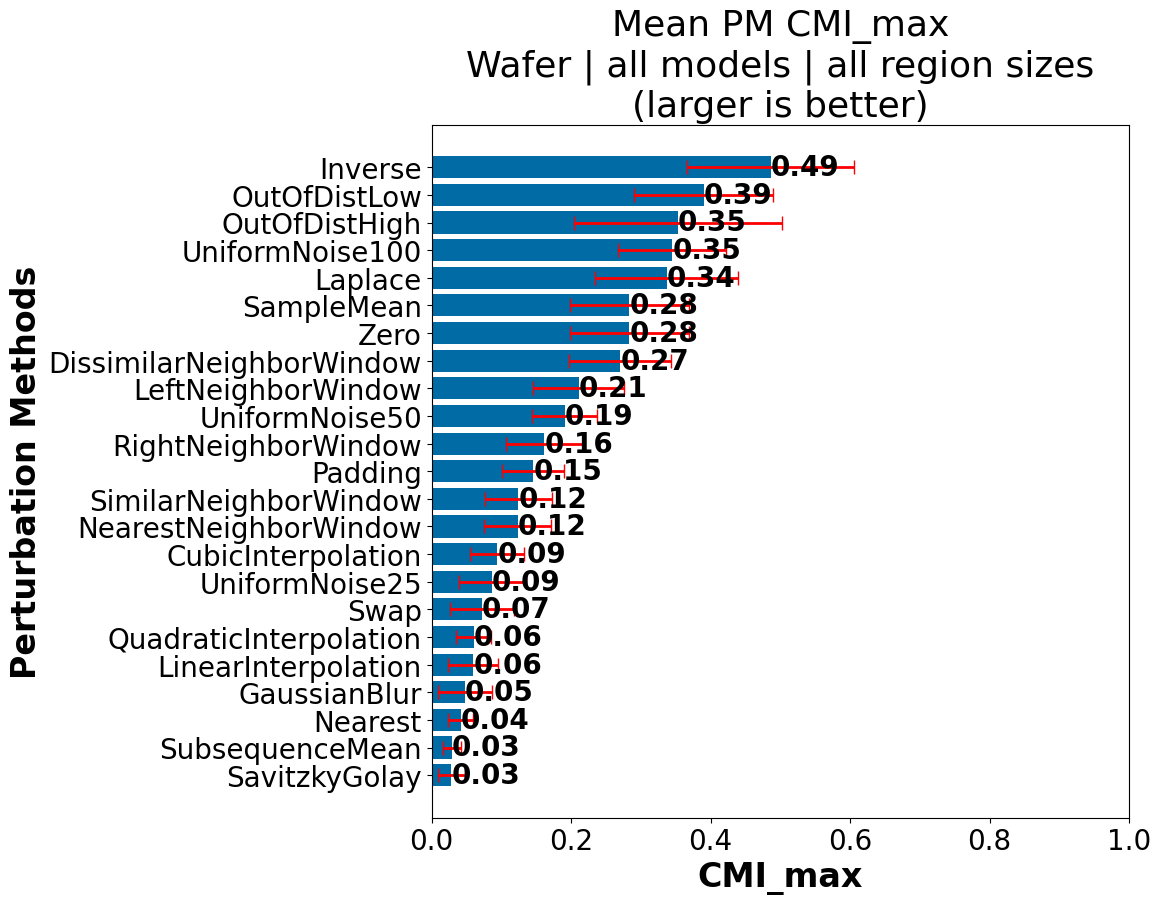

In [16]:
# [FIGURE] PM Choice insights PMS for individual datasets
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
for d in datasets:
    compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, [d], region_sizes, significance_tests = False, title=f'Mean PM CMI_max\n{d} | all models | all region sizes', fname=f'PM_CMI_max_ALL_{d}')

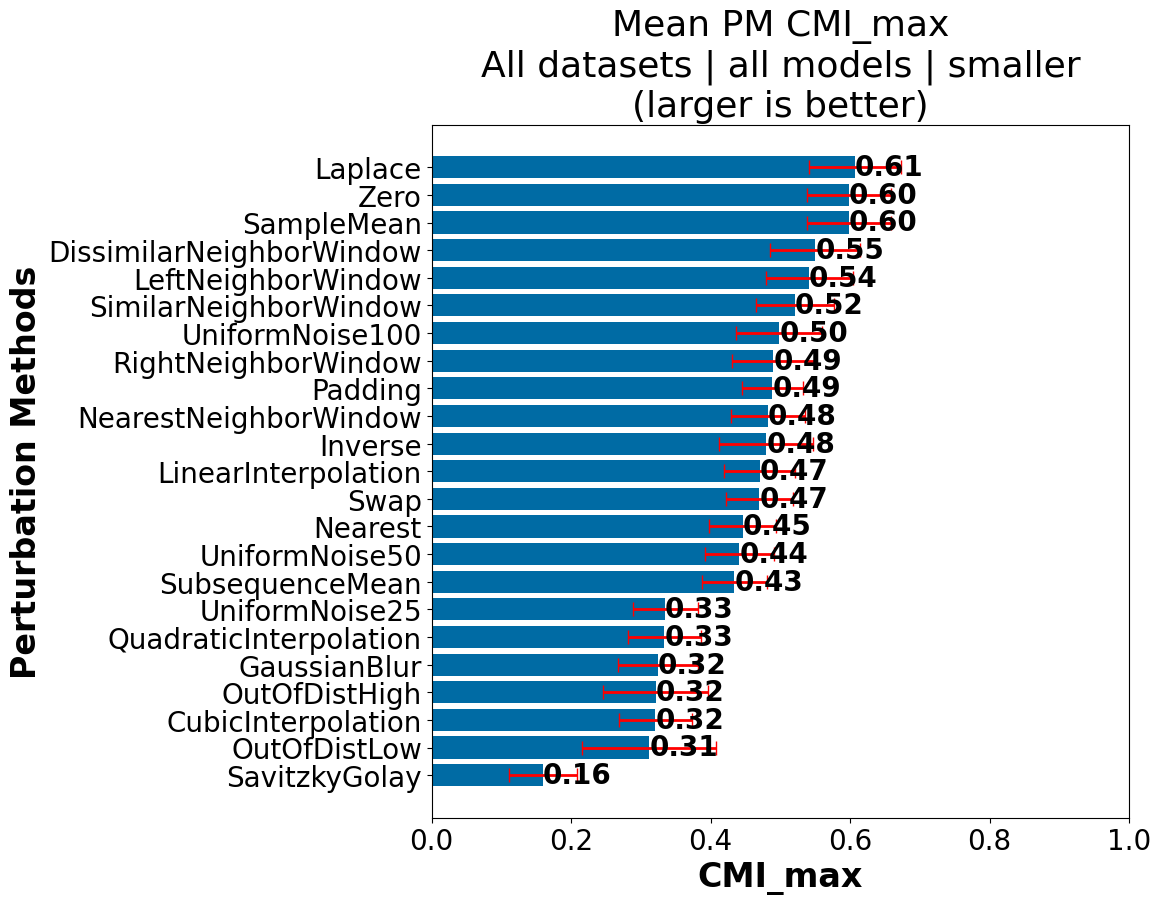

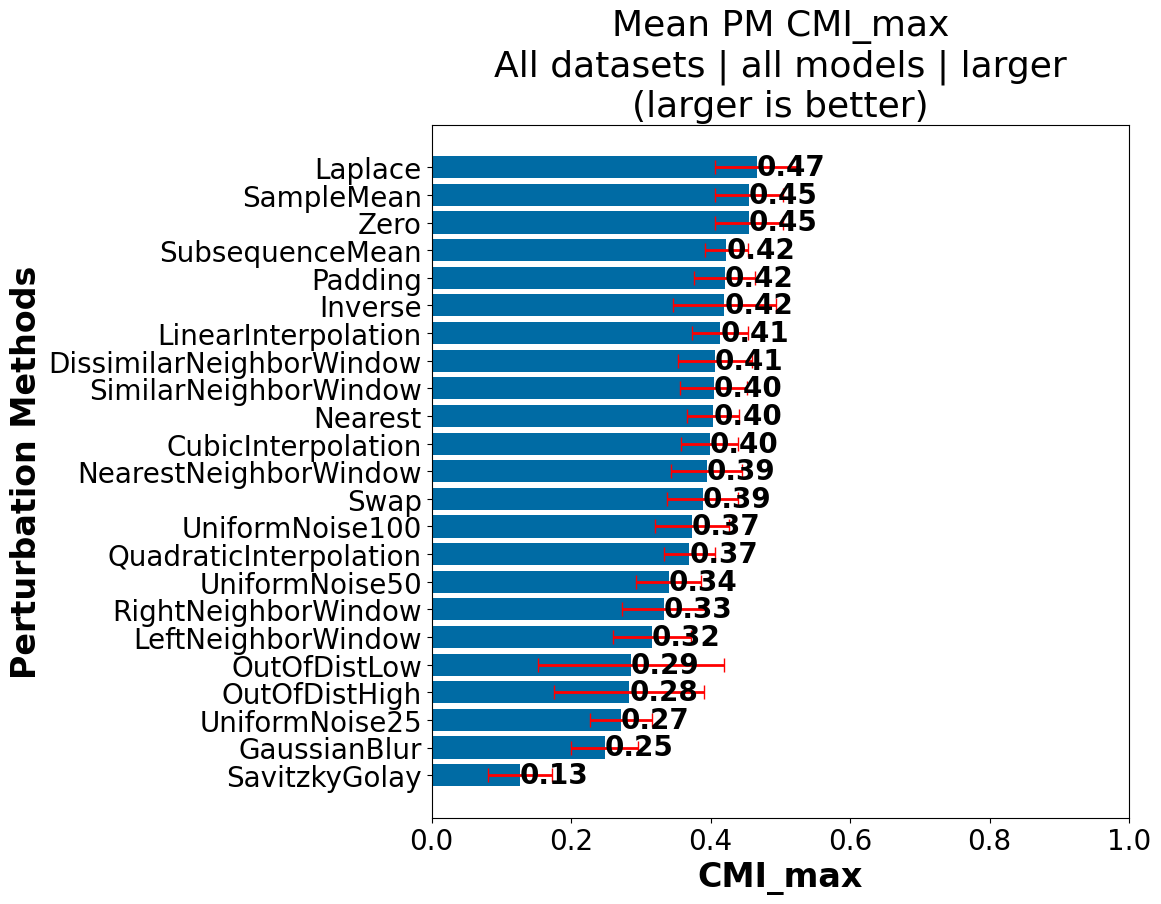

In [17]:
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
for r in region_sizes:
    compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, datasets, [r], significance_tests = False, title=f'Mean PM CMI_max\nAll datasets | all models | {r}')

### Individual datasets / models / region size

In [ ]:
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
for d in datasets:
    foo = compute_mean_cmi_max_pm_ranking_holm_bonferroni(['ResNet'], [d], ['smaller'], significance_tests = False, title='Mean PM CMI_max', show_plot=False)
    df_foo = pd.DataFrame(foo)
    print(d)
    print(f'Max: {df_foo["max-cmi (mean)"].max()}')
    print(f'Min: {df_foo["max-cmi (mean)"].min()}')
    print(f'Mean: ${df_foo["max-cmi (mean)"].mean():.2f} \pm {df_foo["max-cmi (mean)"].std():.2f}$')
    # display(df_foo)
    print()

In [ ]:
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
for m in models:
    foo = compute_mean_cmi_max_pm_ranking([m], ['NonInvasiveFetalECGThorax1'], ['smaller'], significance_tests = False, title='Mean PM CMI_max', show_plot=False)
    df_foo = pd.DataFrame(foo)
    print(m)
    print(f'Max: {df_foo["max-cmi (mean)"].max()}')
    print(f'Min: {df_foo["max-cmi (mean)"].min()}')
    print(f'Mean: ${df_foo["max-cmi (mean)"].mean():.2f} \pm {df_foo["max-cmi (mean)"].std():.2f}$')
    # display(df_foo)
    print()

In [21]:
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
for r in region_sizes:
    foo = compute_mean_cmi_max_pm_ranking_holm_bonferroni(['Inception'], ['NonInvasiveFetalECGThorax1'], [r], significance_tests = False, title='Mean PM CMI_max', show_plot=False)
    df_foo = pd.DataFrame(foo)
    print(r)
    print(f'Max: {df_foo["max-cmi (mean)"].max()}')
    print(f'Min: {df_foo["max-cmi (mean)"].min()}')
    print(f'Mean: ${df_foo["max-cmi (mean)"].mean():.2f} \pm {df_foo["max-cmi (mean)"].std():.2f}$')
    # display(df_foo)
    print()

smaller
Max: 0.7155
Min: 0.0095
Mean: $0.44 \pm 0.24$

larger
Max: 0.6209
Min: 0.0076
Mean: $0.34 \pm 0.19$



## AM focused results analysis
---

Answer following questions here:
1. Importance of AM selection w.r.t. model architectures
2. Importance of AM selection w.r.t. dataset types
3. Best overall AM
4. AMs to avoid
5. Additional observations

In [22]:
def get_am_shorthand(am):
    if am == 'IntegratedGradients':
        return 'IG'
    if am == 'Saliency':
        return 'S'
    if am == 'FeatureAblation':
        return 'FA'
    if am == 'Deconvolution':
        return 'D'
    if am == 'InputXGradient':
        return 'IxG'
    if am == 'GuidedBackprop':
        return 'GB'
    if am == 'Lime':
        return 'L'
    if am == 'KernelShap':
        return 'KS'
    if am == 'DeepLIFT':
        return 'DL'
    if am == 'GradCAM':
        return 'GC'
    if am == 'GuidedGradCAM':
        return 'GC'
    if am == 'RandomAttribution':
        return 'R'
    return 'no shorthand'

In [23]:
def get_am_ranking_accounting_for_ties(model, dataset, region_size, exclude_ams = None):
    # load results files
    # am_ranks_csv_path = os.path.join(results_dir,'region size - {}'.format(region_size), dataset, '{}_{}_{}_all classes_am_avg_rank.csv'.format(dataset,model,region_size))
    # df_am_ranks = pd.read_csv(am_ranks_csv_path)
    
    sig_tests_csv_path = os.path.join(results_dir,'region size - {}'.format(region_size), dataset, '{}_{}_{}_all classes_am_avg_rank_pair_sig_tests.csv'.format(dataset,model,region_size))
    df_sig_tests = pd.read_csv(sig_tests_csv_path)

    filtered_columns = df_sig_tests.filter(like='test statistic', axis=1)
    df_sig_tests = df_sig_tests.drop(columns=filtered_columns.columns)

    if exclude_ams is not None:
        for am in exclude_ams:
            col_name = f'{am} - p-value'
            if col_name in df_sig_tests.columns:
                df_sig_tests = df_sig_tests.drop(columns=[col_name])
                df_sig_tests = df_sig_tests[~df_sig_tests['-'].str.contains(am)]
        df_sig_tests = df_sig_tests.reset_index(drop=True)

    am_tied_rankings = {}

    for col_name in df_sig_tests.columns:
        if col_name == '-':
            continue

        alpha = 0.05 / (len(df_sig_tests[col_name]) - 1) # number of comparisons
        am_name = col_name.split(' - ')[0]
        for rank, p_val in enumerate(df_sig_tests[col_name]):
            if np.isnan(p_val) or (p_val >= alpha):
                am_tied_rankings[am_name] = rank + 1
                break
     
    return am_tied_rankings

#### Influence of model architecture on AM ranking

In [24]:
models = ['Inception', 'ResNet']
'_'.join(models)

'Inception_ResNet'

In [ ]:
# USED FOR GENERATING TABLE CONTENTS IN PAPER!!!!

# models = ['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ]
models = ['Inception', 'ResNet']
# models = ['LSTM', 'MLP', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = ['smaller', 'larger']

def get_mean_ranking_for_models(models, ignore_ams=[], plot_results=False):
    am_res_obj = {}
    for model in models:
        # print('------------------------------------------------------------')
        # print(f'MODEL: {model}')
        list_of_am_tied_ranking_results = []
        for dataset in datasets:
            for region_size in region_sizes:
                list_of_am_tied_ranking_results.append(get_am_ranking_accounting_for_ties(model, dataset, region_size, ignore_ams))
                
        results_df = pd.DataFrame(list_of_am_tied_ranking_results)
        # print(f'#rankings: {len(results_df)}')
        for col_name in results_df.columns:
            # print(f'{col_name}: {results_df[col_name].mean()} ({results_df[col_name].std():.2f})')
            if col_name not in am_res_obj:
                am_res_obj[col_name] = {}
            am_res_obj[col_name][f'{model} (mean)'] = round(results_df[col_name].mean(), 2)
            am_res_obj[col_name][f'{model} (std)'] = round(results_df[col_name].std(), 2)

    res_list = []
    for am in am_res_obj:
        res_obj = {'AM' : am}
        for col_name in am_res_obj[am]:
            res_obj[col_name] = am_res_obj[am][col_name]
        res_list.append(res_obj)
    res_df = pd.DataFrame(res_list)
    res_df = res_df.sort_values(by=f'{models[0]} (mean)')
    display(res_df)
    print(res_df.to_latex(index=False))
    os.makedirs(f'{results_dir}/tables', exist_ok=True)
    res_df.to_csv('{}/tables/mean_am_rank_models_{}.csv'.format(results_dir, '_'.join(models)), index=False, header=True)

    alt_res_df = res_df.copy()
    for model in models:
        alt_res_df[model] = alt_res_df[f'{model} (mean)'].astype(str) + " PLUSMINUS " + alt_res_df[f'{model} (std)'].astype(str)
        alt_res_df = alt_res_df.drop(columns=[f'{model} (mean)', f'{model} (std)'])

    display(alt_res_df)
    print(alt_res_df.to_latex(index=False))

    if plot_results:
        filtered_columns = res_df.filter(like='(mean)', axis=1)
        for f_col in filtered_columns:
            df = res_df.sort_values(by=f_col, ascending=False)
            plt.title(f_col)
            plt.barh(df['AM'], df[f_col])
            plt.show()

    return res_df

get_mean_ranking_for_models(['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ], ['GradCAM', 'GuidedGradCAM'], plot_results=True)
get_mean_ranking_for_models(['Inception', 'ResNet'], plot_results=True)

#### Influence of dataset type on AM ranking

AM  FordA (mean)  FordA (std)  FordB (mean)  FordB (std)  \
0      FeatureAblation           1.5         1.08           1.9         1.10   
1  IntegratedGradients           2.2         0.92           2.1         1.10   
2       InputXGradient           2.7         1.16           2.4         1.07   
3             DeepLIFT           3.5         2.55           3.7         3.02   
4             Saliency           5.1         0.74           6.2         1.55   
5        Deconvolution           5.8         1.14           5.3         1.34   
7           KernelShap           6.5         1.72           6.0         1.25   
6                 Lime           6.6         1.35           6.6         1.43   
8       GuidedBackprop           6.6         1.26           6.5         1.65   
9    RandomAttribution           9.6         0.84           9.5         0.97   

   NonInvasiveFetalECGThorax1 (mean)  NonInvasiveFetalECGThorax1 (std)  \
0                                1.1                              0.32   
1                                2.7                              0.48   
2                                5.2                              1.81   
3                                4.9                              2.51   
4                                2.7                              1.49   
5                                5.0                              1.94   
7                                6.6                              1.84   
6                                6.7                              1.57   
8                                5.4                              2.32   
9                               10.0                              0.00   

   NonInvasiveFetalECGThorax2 (mean)  NonInvasiveFetalECGThorax2 (std)  \
0                                1.0                              0.00   
1                                2.7                              0.67   
2                                4.6                              1.17   
3                                5.0                              2.62   
4                                2.4                              0.84   
5                                5.2                              2.44   
7                                6.7                              1.95   
6                                6.7                              1.95   
8                                5.6                              2.59   
9                                9.8                              0.63   

   Wafer (mean)  Wafer (std)  
0           2.2         2.04  
1           1.8         0.92  
2           3.0         1.33  
3           3.0         1.76  
4           3.2         1.75  
5           3.7         1.89  
7           6.8         2.74  
6           5.8         2.49  
8           4.0         2.00  
9          10.0         0.00

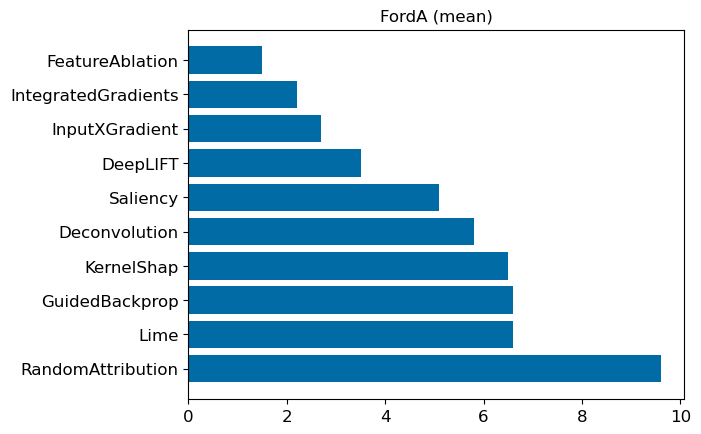

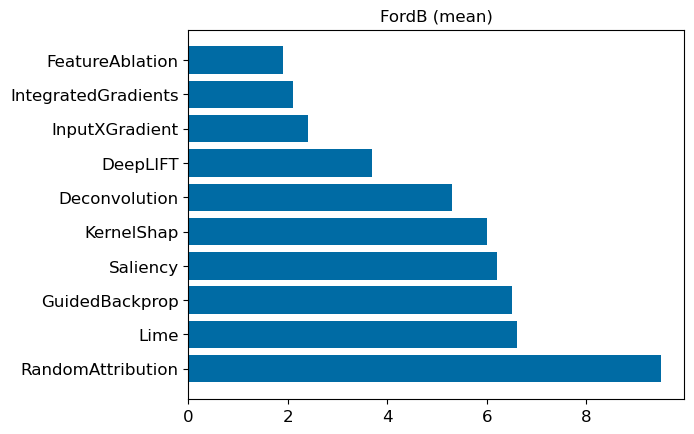

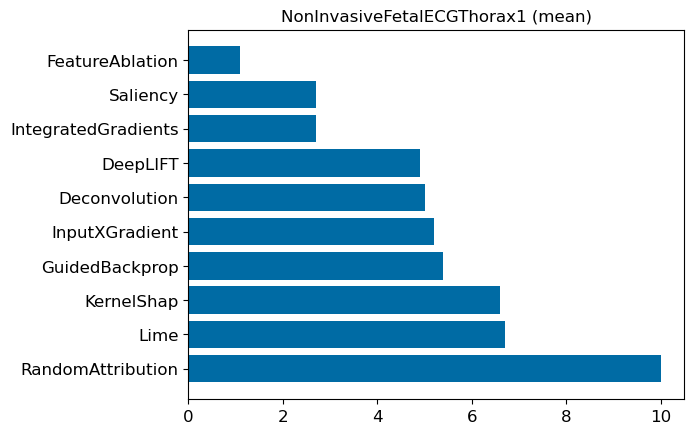

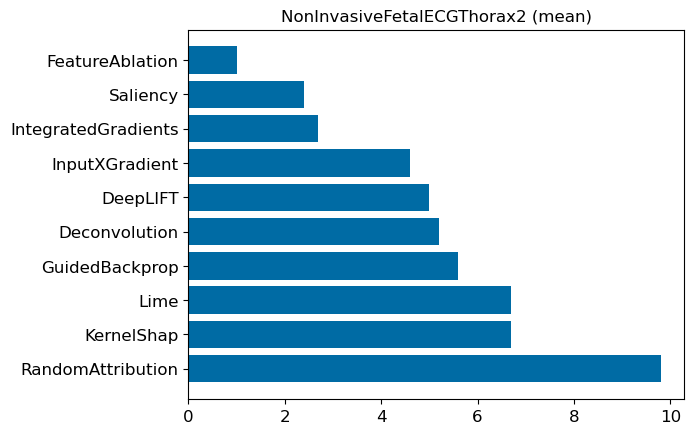

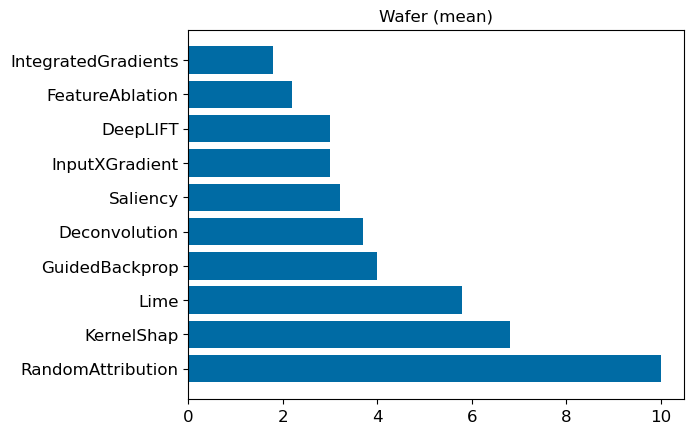

AM  FordA (mean)  FordA (std)  FordB (mean)  FordB (std)  \
0       FeatureAblation          1.00         0.00          2.00         1.15   
3               GradCAM          1.75         0.96          2.25         1.50   
1   IntegratedGradients          3.00         1.15          2.75         0.96   
4              DeepLIFT          3.50         1.29          3.25         2.06   
2        InputXGradient          4.25         0.96          3.75         1.50   
8         GuidedGradCAM          6.25         1.50          6.50         0.58   
5              Saliency          6.50         1.00          9.00         1.63   
10       GuidedBackprop          7.25         1.71          6.50         1.29   
6         Deconvolution          7.50         0.58          6.25         0.96   
7                  Lime          8.50         1.73          8.50         1.91   
9            KernelShap          9.75         0.50          8.00         1.15   
11    RandomAttribution         12.00         0.00         10.75         1.89   

    NonInvasiveFetalECGThorax1 (mean)  NonInvasiveFetalECGThorax1 (std)  \
0                                1.25                              0.50   
3                                1.50                              0.58   
1                                3.75                              0.50   
4                                4.25                              0.96   
2                                8.00                              1.41   
8                                3.75                              0.50   
5                                5.75                              1.89   
10                               4.50                              1.73   
6                                5.00                              1.41   
7                               10.00                              0.00   
9                               10.00                              0.00   
11                              12.00                              0.00   

    NonInvasiveFetalECGThorax2 (mean)  NonInvasiveFetalECGThorax2 (std)  \
0                                1.25                              0.50   
3                                1.50                              0.58   
1                                3.50                              0.58   
4                                4.25                              1.50   
2                                6.25                              1.26   
8                                5.00                              1.63   
5                                4.25                              0.50   
10                               4.25                              1.50   
6                                4.25                              0.96   
7                               10.00                              0.00   
9                               10.25                              0.50   
11                              11.50                              1.00   

    Wafer (mean)  Wafer (std)  
0           1.50         0.58  
3           1.75         0.50  
1           2.25         1.50  
4           3.25         2.63  
2           3.50         1.29  
8           5.00         2.16  
5           6.00         0.82  
10          5.25         0.96  
6           6.25         1.26  
7           7.75         1.50  
9          10.75         0.50  
11         12.00         0.00

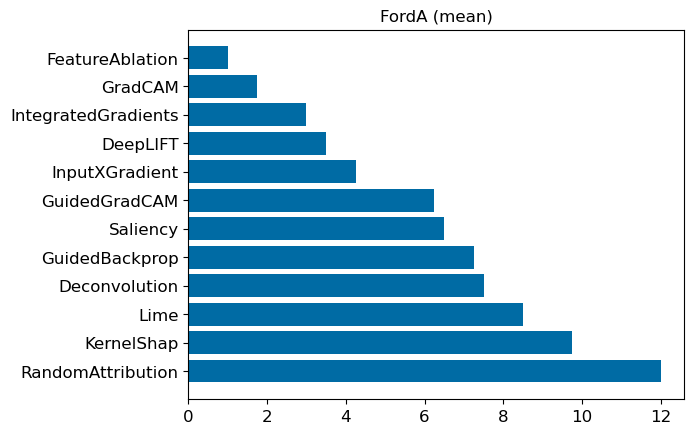

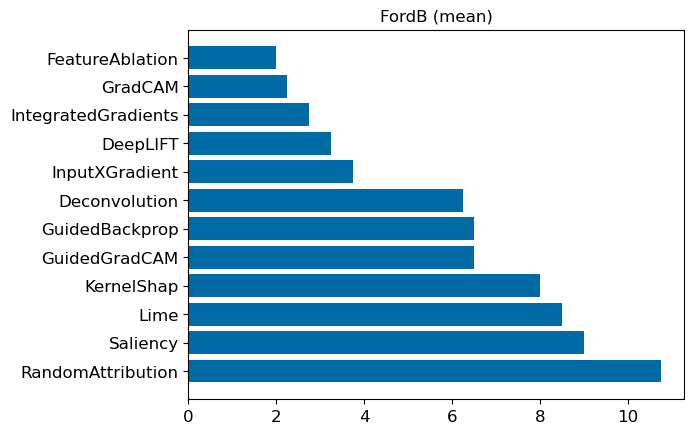

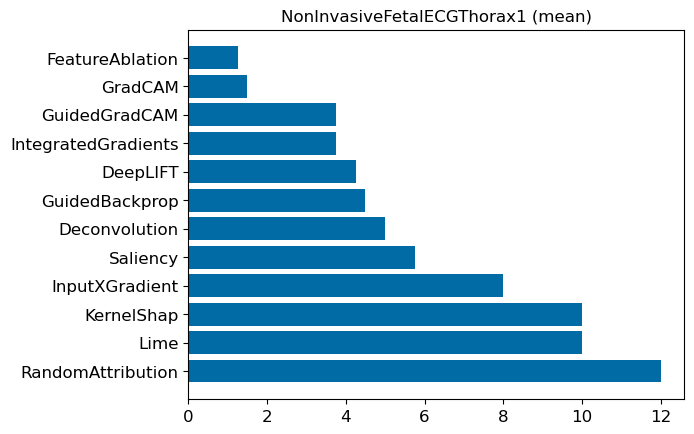

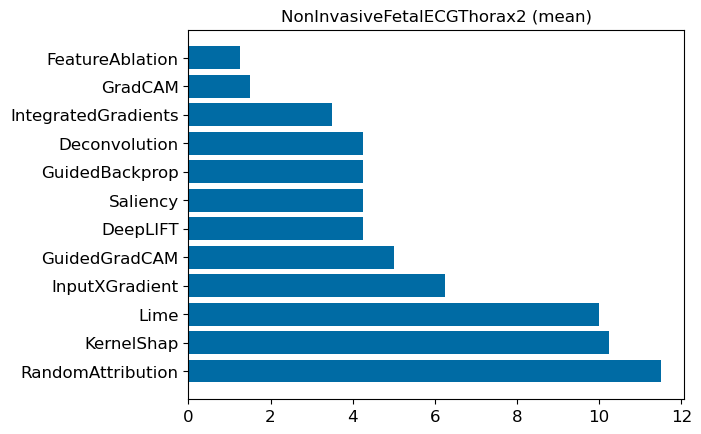

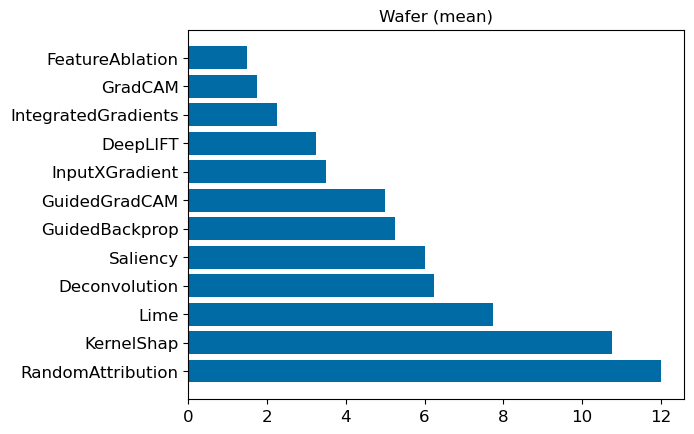

In [42]:
# USED FOR GENERATING TABLE CONTENTS IN PAPER!

models = ['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ]
# models = ['Inception', 'ResNet']
# models = ['LSTM', 'MLP', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = ['smaller', 'larger']

def get_mean_ranking_for_datasets(datasets, models, ignore_ams=[], plot_results=False, print_latex=False):
    am_res_obj = {}
    for dataset in datasets:
        # print('------------------------------------------------------------')
        # print(f'MODEL: {model}')
        list_of_am_tied_ranking_results = []
        for model in models:
            for region_size in region_sizes:
                list_of_am_tied_ranking_results.append(get_am_ranking_accounting_for_ties(model, dataset, region_size, ignore_ams))
                
        results_df = pd.DataFrame(list_of_am_tied_ranking_results)
        # print(f'#rankings: {len(results_df)}')
        for col_name in results_df.columns:
            # print(f'{col_name}: {results_df[col_name].mean()} ({results_df[col_name].std():.2f})')
            if col_name not in am_res_obj:
                am_res_obj[col_name] = {}
            am_res_obj[col_name][f'{dataset} (mean)'] = round(results_df[col_name].mean(), 2)
            am_res_obj[col_name][f'{dataset} (std)'] = round(results_df[col_name].std(), 2)

    res_list = []
    for am in am_res_obj:
        res_obj = {'AM' : am}
        for col_name in am_res_obj[am]:
            res_obj[col_name] = am_res_obj[am][col_name]
        res_list.append(res_obj)
    res_df = pd.DataFrame(res_list)
    res_df = res_df.sort_values(by=f'{datasets[0]} (mean)')
    display(res_df)
    if print_latex:
        print(res_df.to_latex(index=False))

    os.makedirs(f'{results_dir}/tables', exist_ok=True)
    res_df.to_csv('{}/tables/mean_am_rank_all_datasets_{}.csv'.format(results_dir, '_'.join(models)), index=False, header=True)

    alt_res_df = res_df.copy()
    for dataset in datasets:
        alt_res_df[dataset] = alt_res_df[f'{dataset} (mean)'].astype(str) + " PLUSMINUS " + alt_res_df[f'{dataset} (std)'].astype(str)
        alt_res_df = alt_res_df.drop(columns=[f'{dataset} (mean)', f'{dataset} (std)'])

    if print_latex:
        display(alt_res_df)
        print(alt_res_df.to_latex(index=False))

    if plot_results:
        filtered_columns = res_df.filter(like='(mean)', axis=1)
        for f_col in filtered_columns:
            df = res_df.sort_values(by=f_col, ascending=False)
            plt.title(f_col)
            plt.barh(df['AM'], df[f_col])
            plt.show()

    # return res_df

get_mean_ranking_for_datasets(datasets, models, ['GradCAM', 'GuidedGradCAM'], plot_results=True, print_latex=False)
get_mean_ranking_for_datasets(datasets, ['Inception', 'ResNet'], plot_results=True, print_latex=False)

#### Best overall AM

AM  Rank (mean)  Rank (std)
0      FeatureAblation         1.54        1.20
1  IntegratedGradients         2.30        0.89
2       InputXGradient         3.58        1.70
4             Saliency         3.92        1.97
3             DeepLIFT         4.02        2.55
5        Deconvolution         5.00        1.87
8       GuidedBackprop         5.62        2.16
6                 Lime         6.48        1.76
7           KernelShap         6.52        1.90
9    RandomAttribution         9.78        0.65

\begin{tabular}{lrr}
\toprule
                 AM &  Rank (mean) &  Rank (std) \\
\midrule
    FeatureAblation &         1.54 &        1.20 \\
IntegratedGradients &         2.30 &        0.89 \\
     InputXGradient &         3.58 &        1.70 \\
           Saliency &         3.92 &        1.97 \\
           DeepLIFT &         4.02 &        2.55 \\
      Deconvolution &         5.00 &        1.87 \\
     GuidedBackprop &         5.62 &        2.16 \\
               Lime &         6.48 &        1.76 \\
         KernelShap &         6.52 &        1.90 \\
  RandomAttribution &         9.78 &        0.65 \\
\bottomrule
\end{tabular}



AM                 Rank
0      FeatureAblation   1.54 PLUSMINUS 1.2
1  IntegratedGradients   2.3 PLUSMINUS 0.89
2       InputXGradient   3.58 PLUSMINUS 1.7
4             Saliency  3.92 PLUSMINUS 1.97
3             DeepLIFT  4.02 PLUSMINUS 2.55
5        Deconvolution   5.0 PLUSMINUS 1.87
8       GuidedBackprop  5.62 PLUSMINUS 2.16
6                 Lime  6.48 PLUSMINUS 1.76
7           KernelShap   6.52 PLUSMINUS 1.9
9    RandomAttribution  9.78 PLUSMINUS 0.65

\begin{tabular}{ll}
\toprule
                 AM &                Rank \\
\midrule
    FeatureAblation &  1.54 PLUSMINUS 1.2 \\
IntegratedGradients &  2.3 PLUSMINUS 0.89 \\
     InputXGradient &  3.58 PLUSMINUS 1.7 \\
           Saliency & 3.92 PLUSMINUS 1.97 \\
           DeepLIFT & 4.02 PLUSMINUS 2.55 \\
      Deconvolution &  5.0 PLUSMINUS 1.87 \\
     GuidedBackprop & 5.62 PLUSMINUS 2.16 \\
               Lime & 6.48 PLUSMINUS 1.76 \\
         KernelShap &  6.52 PLUSMINUS 1.9 \\
  RandomAttribution & 9.78 PLUSMINUS 0.65 \\
\bottomrule
\end{tabular}



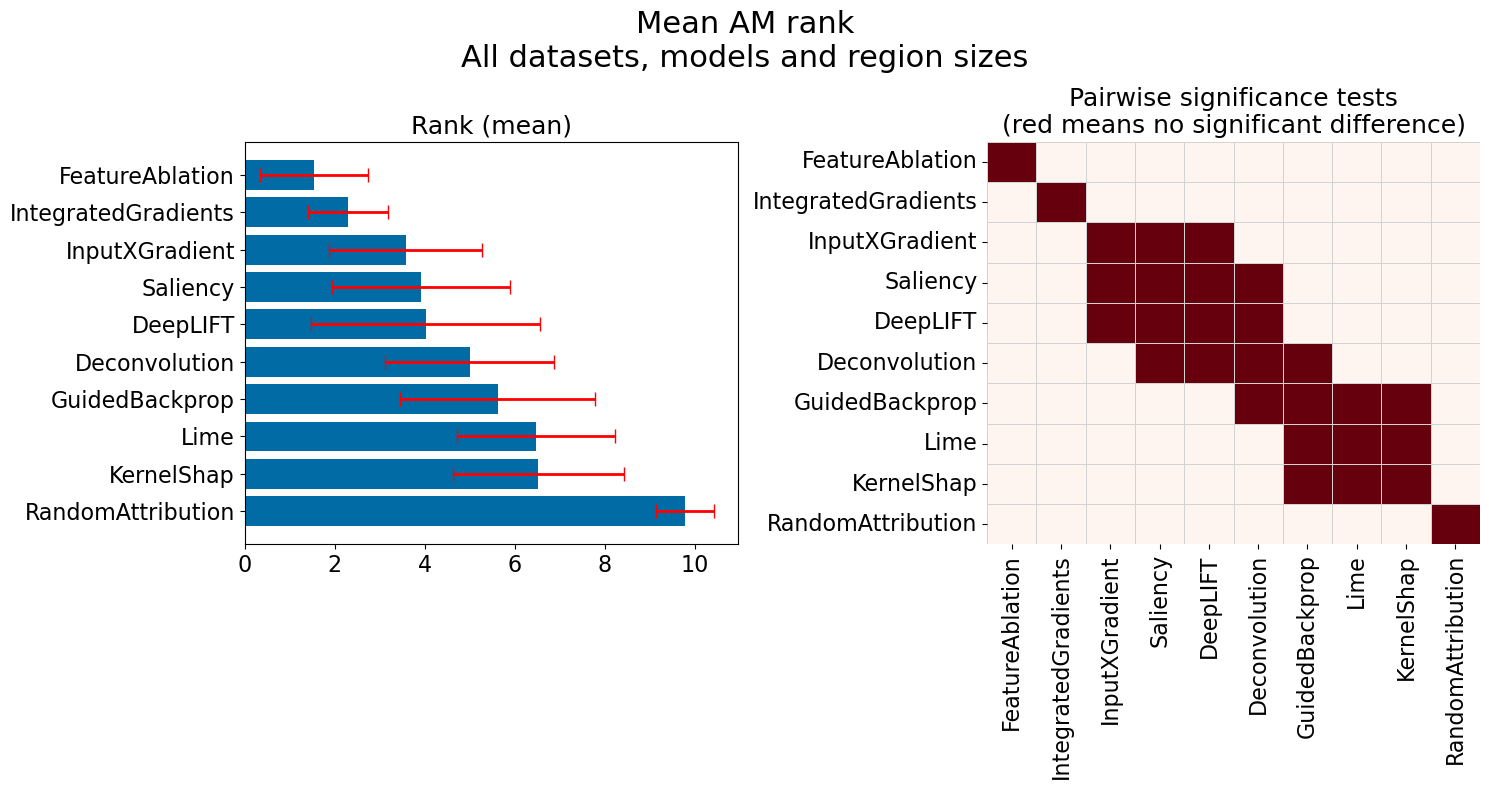

AM  Rank (mean)  Rank (std)
0       FeatureAblation         1.40        0.68
3               GradCAM         1.75        0.85
1   IntegratedGradients         3.05        1.05
4              DeepLIFT         3.70        1.66
2        InputXGradient         5.15        2.11
8         GuidedGradCAM         5.30        1.63
10       GuidedBackprop         5.55        1.76
6         Deconvolution         5.85        1.50
5              Saliency         6.30        1.95
7                  Lime         8.95        1.50
9            KernelShap         9.75        1.12
11    RandomAttribution        11.65        0.99

\begin{tabular}{lrr}
\toprule
                 AM &  Rank (mean) &  Rank (std) \\
\midrule
    FeatureAblation &         1.40 &        0.68 \\
            GradCAM &         1.75 &        0.85 \\
IntegratedGradients &         3.05 &        1.05 \\
           DeepLIFT &         3.70 &        1.66 \\
     InputXGradient &         5.15 &        2.11 \\
      GuidedGradCAM &         5.30 &        1.63 \\
     GuidedBackprop &         5.55 &        1.76 \\
      Deconvolution &         5.85 &        1.50 \\
           Saliency &         6.30 &        1.95 \\
               Lime &         8.95 &        1.50 \\
         KernelShap &         9.75 &        1.12 \\
  RandomAttribution &        11.65 &        0.99 \\
\bottomrule
\end{tabular}



AM                  Rank
0       FeatureAblation    1.4 PLUSMINUS 0.68
3               GradCAM   1.75 PLUSMINUS 0.85
1   IntegratedGradients   3.05 PLUSMINUS 1.05
4              DeepLIFT    3.7 PLUSMINUS 1.66
2        InputXGradient   5.15 PLUSMINUS 2.11
8         GuidedGradCAM    5.3 PLUSMINUS 1.63
10       GuidedBackprop   5.55 PLUSMINUS 1.76
6         Deconvolution    5.85 PLUSMINUS 1.5
5              Saliency    6.3 PLUSMINUS 1.95
7                  Lime    8.95 PLUSMINUS 1.5
9            KernelShap   9.75 PLUSMINUS 1.12
11    RandomAttribution  11.65 PLUSMINUS 0.99

\begin{tabular}{ll}
\toprule
                 AM &                 Rank \\
\midrule
    FeatureAblation &   1.4 PLUSMINUS 0.68 \\
            GradCAM &  1.75 PLUSMINUS 0.85 \\
IntegratedGradients &  3.05 PLUSMINUS 1.05 \\
           DeepLIFT &   3.7 PLUSMINUS 1.66 \\
     InputXGradient &  5.15 PLUSMINUS 2.11 \\
      GuidedGradCAM &   5.3 PLUSMINUS 1.63 \\
     GuidedBackprop &  5.55 PLUSMINUS 1.76 \\
      Deconvolution &   5.85 PLUSMINUS 1.5 \\
           Saliency &   6.3 PLUSMINUS 1.95 \\
               Lime &   8.95 PLUSMINUS 1.5 \\
         KernelShap &  9.75 PLUSMINUS 1.12 \\
  RandomAttribution & 11.65 PLUSMINUS 0.99 \\
\bottomrule
\end{tabular}



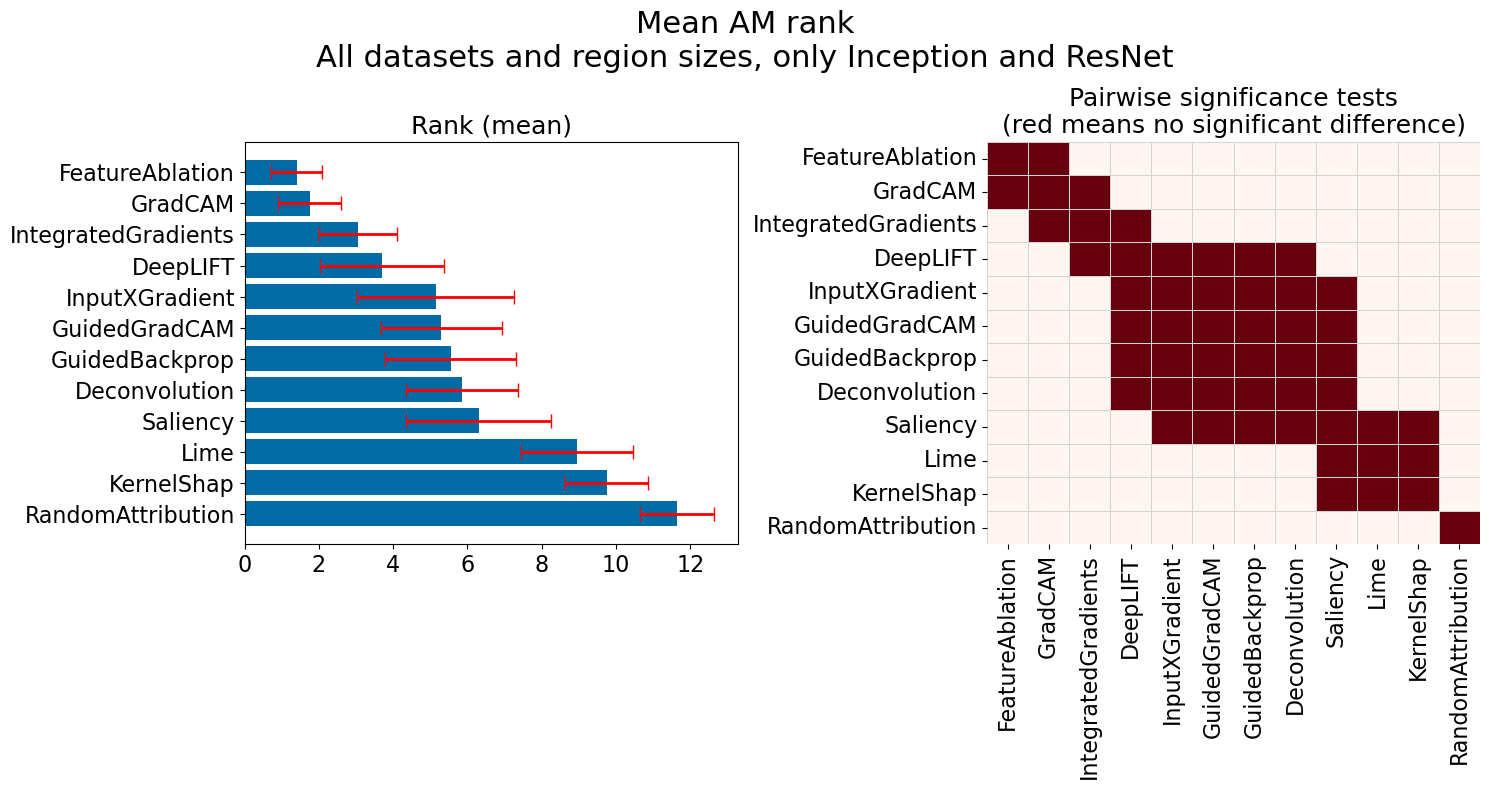

AM  Rank (mean)  Rank (std)
11    RandomAttribution        11.65        0.99
9            KernelShap         9.75        1.12
7                  Lime         8.95        1.50
5              Saliency         6.30        1.95
6         Deconvolution         5.85        1.50
10       GuidedBackprop         5.55        1.76
8         GuidedGradCAM         5.30        1.63
2        InputXGradient         5.15        2.11
4              DeepLIFT         3.70        1.66
1   IntegratedGradients         3.05        1.05
3               GradCAM         1.75        0.85
0       FeatureAblation         1.40        0.68

In [43]:
# USED FOR GENERATING TABLE CONTENTS IN PAPER!!!!

datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = ['smaller', 'larger']

def get_mean_am_ranking_over_all(models, ignore_ams=[], plot_results=False, save_name_suffix='', holm_correction = False):
    ticks_fontsize = 16
    axis_label_fontsize = 17
    suptitle_fontsize = 22
    axs_title_fontsize = 18
    bar_label_fontsize = 14

    am_res_obj = {}
    list_of_am_tied_ranking_results = []
    for model in models:
        for dataset in datasets:
            for region_size in region_sizes:
                list_of_am_tied_ranking_results.append(get_am_ranking_accounting_for_ties(model, dataset, region_size, ignore_ams))
                
    results_df = pd.DataFrame(list_of_am_tied_ranking_results)

    # return
    # print(f'#rankings: {len(results_df)}')
    for col_name in results_df.columns:
        # print(f'{col_name}: {results_df[col_name].mean()} ({results_df[col_name].std():.2f})')
        if col_name not in am_res_obj:
            am_res_obj[col_name] = {}
        am_res_obj[col_name]['Rank (mean)'] = round(results_df[col_name].mean(), 2)
        am_res_obj[col_name]['Rank (std)'] = round(results_df[col_name].std(), 2)

    res_list = []
    for am in am_res_obj:
        res_obj = {'AM' : am}
        for col_name in am_res_obj[am]:
            res_obj[col_name] = am_res_obj[am][col_name]
        res_list.append(res_obj)
    res_df = pd.DataFrame(res_list)
    res_df = res_df.sort_values(by='Rank (mean)')
    display(res_df) # SAVE THIS !!!
    print(res_df.to_latex(index=False))

    os.makedirs(f'{results_dir}/tables', exist_ok=True)
    res_df.to_csv(f'{results_dir}/tables/mean_am_rank_ALL{save_name_suffix}.csv', index=False, header=True)

    alt_res_df = res_df.copy()
    
    alt_res_df['Rank'] = alt_res_df['Rank (mean)'].astype(str) + " PLUSMINUS " + alt_res_df['Rank (std)'].astype(str)
    alt_res_df = alt_res_df.drop(columns=['Rank (mean)', 'Rank (std)'])

    display(alt_res_df)
    print(alt_res_df.to_latex(index=False))

    ####################################################################################################################################################################################
    # Compute significant differences
    ####################################################################################################################################################################################
    sig_diff_matrix = []
    p_val_matrix = []
    significance_test_results = []
    n_comparisons = len(results_df.columns) - 1
    labels = []
    for i, am_i_name in enumerate(list(alt_res_df['AM'])):
        significance_test_row = {
            '-' : am_i_name,
        }
        labels.append(am_i_name)

        am_1_ranks = results_df[am_i_name]
        sig_diffs = []
        p_val_row = []
        for j, am_j_name in enumerate(list(alt_res_df['AM'])):
            am_2_ranks = results_df[am_j_name]
            # am_2_weights = avg_am_rank_cmi_2_adjusted[j]['weights']

            # Calculate the differences between paired observations
            differences = am_1_ranks - am_2_ranks

            if np.all(differences == 0):
                sig_diffs.append(False)
                p_val_row.append(np.nan)
                significance_test_row['{} - test statistic'.format(am_j_name)] = None
                significance_test_row['{} - p-value'.format(am_j_name)] = None
                continue

            # wilcoxon test chosen, because it often happens that differences are not normally distributed
            stat, p_value = wilcoxon(differences)

            sig_diffs.append(p_value < (0.05 / n_comparisons))
            p_val_row.append(p_value)

            significance_test_row['{} - test statistic'.format(am_j_name)] = stat
            significance_test_row['{} - p-value'.format(am_j_name)] = p_value
        significance_test_results.append(significance_test_row)

        p_val_matrix.append(p_val_row)
        sig_diff_matrix.append(sig_diffs)

    if holm_correction:
        p_val_matrix = np.array(p_val_matrix)
        p_val_matrix_flat = p_val_matrix.reshape(-1)
        _, corrected_p_values, _, _ = multipletests(p_val_matrix_flat, alpha=0.05, method='holm')
        p_val_matrix_corrected = corrected_p_values.reshape(p_val_matrix.shape)

        p_val_matrix_corrected = np.nan_to_num(p_val_matrix_corrected, nan=1)

        # p_val_matrix_corrected[]
        sig_diff_matrix_corrected = p_val_matrix_corrected < 0.05
        sig_diff_matrix = sig_diff_matrix_corrected

    sig_df = pd.DataFrame(significance_test_results)
    # sig_df.to_csv(f'results/2023_08_29_rank_aggregation/tables/mean_am_rank_ALL{save_name_suffix}_sig_tests.csv', index=False)
    sig_df.to_csv(f'{results_dir}/individual_tests/mean_am_rank_ALL{save_name_suffix}_sig_tests_uncorrected.csv', index=False)
    
    p_val_cols = [s for s in sig_df.columns if 'p-value' in s]
    sig_df_corrected = sig_df.copy()
    for col_idx, col_name in enumerate(p_val_cols):
        sig_df_corrected[col_name] = p_val_matrix_corrected[col_idx]

    sig_df_corrected.to_csv(f'{results_dir}/individual_tests/mean_am_rank_ALL{save_name_suffix}_sig_tests_holm_corrected.csv', index=False)
    ####################################################################################################################################################################################


    if plot_results:
        # filtered_columns = res_df.filter(like='Rank (mean)', axis=1)
        # for f_col in filtered_columns:
        res_df = res_df.sort_values(by='Rank (mean)', ascending=False)

        fig, axs = plt.subplots(1,2, figsize=(15,8))
        if len(models) == 2:
            fig.suptitle('Mean AM rank\nAll datasets and region sizes, only Inception and ResNet', fontsize=suptitle_fontsize)
        else:
            fig.suptitle('Mean AM rank\nAll datasets, models and region sizes', fontsize=suptitle_fontsize)
        fig.set_facecolor('white')

        axs[0].set_title('Rank (mean)', fontsize=axs_title_fontsize)
        axs[0].barh(res_df['AM'], res_df['Rank (mean)'])
        axs[0].errorbar(res_df['Rank (mean)'], range(len(res_df)), xerr=res_df['Rank (std)'], fmt='none', ecolor='red', capsize=5, linewidth = 2)
        
        sns.heatmap(sig_diff_matrix, annot=False, fmt="d", cmap="Reds_r", vmin=0, vmax=1, xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='lightgray', ax=axs[1], cbar=False)
        axs[1].set_title('Pairwise significance tests\n(red means no significant difference)', fontsize=axs_title_fontsize)

        axs[0].tick_params(axis='y', labelsize=ticks_fontsize)
        axs[1].tick_params(axis='y', labelsize=ticks_fontsize)

        axs[0].tick_params(axis='x', labelsize=ticks_fontsize)
        axs[1].tick_params(axis='x', labelsize=ticks_fontsize)

        plt.tight_layout()        
        plt.savefig(f'{results_dir}/individual_tests/mean_am_rank_ALL{save_name_suffix}_sig_tests_holm_corrected.png', bbox_inches='tight')
        plt.show()


    return res_df

get_mean_am_ranking_over_all(['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ], ['GradCAM', 'GuidedGradCAM'], plot_results=True, save_name_suffix = '_all_models_no_gradcam', holm_correction=True)
get_mean_am_ranking_over_all(['Inception', 'ResNet' ], plot_results=True, save_name_suffix = '_cnns_incl_gradcam', holm_correction=True)

# BELOW TWO LINES USED IN PAPER!
# get_mean_am_ranking_over_all(['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ], ['GradCAM', 'GuidedGradCAM'], plot_results=True, save_name_suffix = '_all_models_no_gradcam')
# get_mean_am_ranking_over_all(['Inception', 'ResNet' ], plot_results=True, save_name_suffix = '_cnns_incl_gradcam')

## Region size focused results analysis
---

### Check for differences in AM ranking

AM  Rank (mean)  Rank (std)
0       FeatureAblation          1.1        0.32
3               GradCAM          2.4        0.70
1   IntegratedGradients          3.1        1.10
4              DeepLIFT          3.8        1.69
2        InputXGradient          5.1        2.60
10       GuidedBackprop          5.2        2.30
6         Deconvolution          5.5        1.72
8         GuidedGradCAM          5.5        1.84
5              Saliency          6.1        2.23
7                  Lime          8.3        1.64
9            KernelShap          9.6        1.51
11    RandomAttribution         11.5        1.27

\begin{tabular}{lrr}
\toprule
                 AM &  Rank (mean) &  Rank (std) \\
\midrule
    FeatureAblation &          1.1 &        0.32 \\
            GradCAM &          2.4 &        0.70 \\
IntegratedGradients &          3.1 &        1.10 \\
           DeepLIFT &          3.8 &        1.69 \\
     InputXGradient &          5.1 &        2.60 \\
     GuidedBackprop &          5.2 &        2.30 \\
      Deconvolution &          5.5 &        1.72 \\
      GuidedGradCAM &          5.5 &        1.84 \\
           Saliency &          6.1 &        2.23 \\
               Lime &          8.3 &        1.64 \\
         KernelShap &          9.6 &        1.51 \\
  RandomAttribution &         11.5 &        1.27 \\
\bottomrule
\end{tabular}



AM                 Rank
0       FeatureAblation   1.1 PLUSMINUS 0.32
3               GradCAM    2.4 PLUSMINUS 0.7
1   IntegratedGradients    3.1 PLUSMINUS 1.1
4              DeepLIFT   3.8 PLUSMINUS 1.69
2        InputXGradient    5.1 PLUSMINUS 2.6
10       GuidedBackprop    5.2 PLUSMINUS 2.3
6         Deconvolution   5.5 PLUSMINUS 1.72
8         GuidedGradCAM   5.5 PLUSMINUS 1.84
5              Saliency   6.1 PLUSMINUS 2.23
7                  Lime   8.3 PLUSMINUS 1.64
9            KernelShap   9.6 PLUSMINUS 1.51
11    RandomAttribution  11.5 PLUSMINUS 1.27

\begin{tabular}{ll}
\toprule
                 AM &                Rank \\
\midrule
    FeatureAblation &  1.1 PLUSMINUS 0.32 \\
            GradCAM &   2.4 PLUSMINUS 0.7 \\
IntegratedGradients &   3.1 PLUSMINUS 1.1 \\
           DeepLIFT &  3.8 PLUSMINUS 1.69 \\
     InputXGradient &   5.1 PLUSMINUS 2.6 \\
     GuidedBackprop &   5.2 PLUSMINUS 2.3 \\
      Deconvolution &  5.5 PLUSMINUS 1.72 \\
      GuidedGradCAM &  5.5 PLUSMINUS 1.84 \\
           Saliency &  6.1 PLUSMINUS 2.23 \\
               Lime &  8.3 PLUSMINUS 1.64 \\
         KernelShap &  9.6 PLUSMINUS 1.51 \\
  RandomAttribution & 11.5 PLUSMINUS 1.27 \\
\bottomrule
\end{tabular}



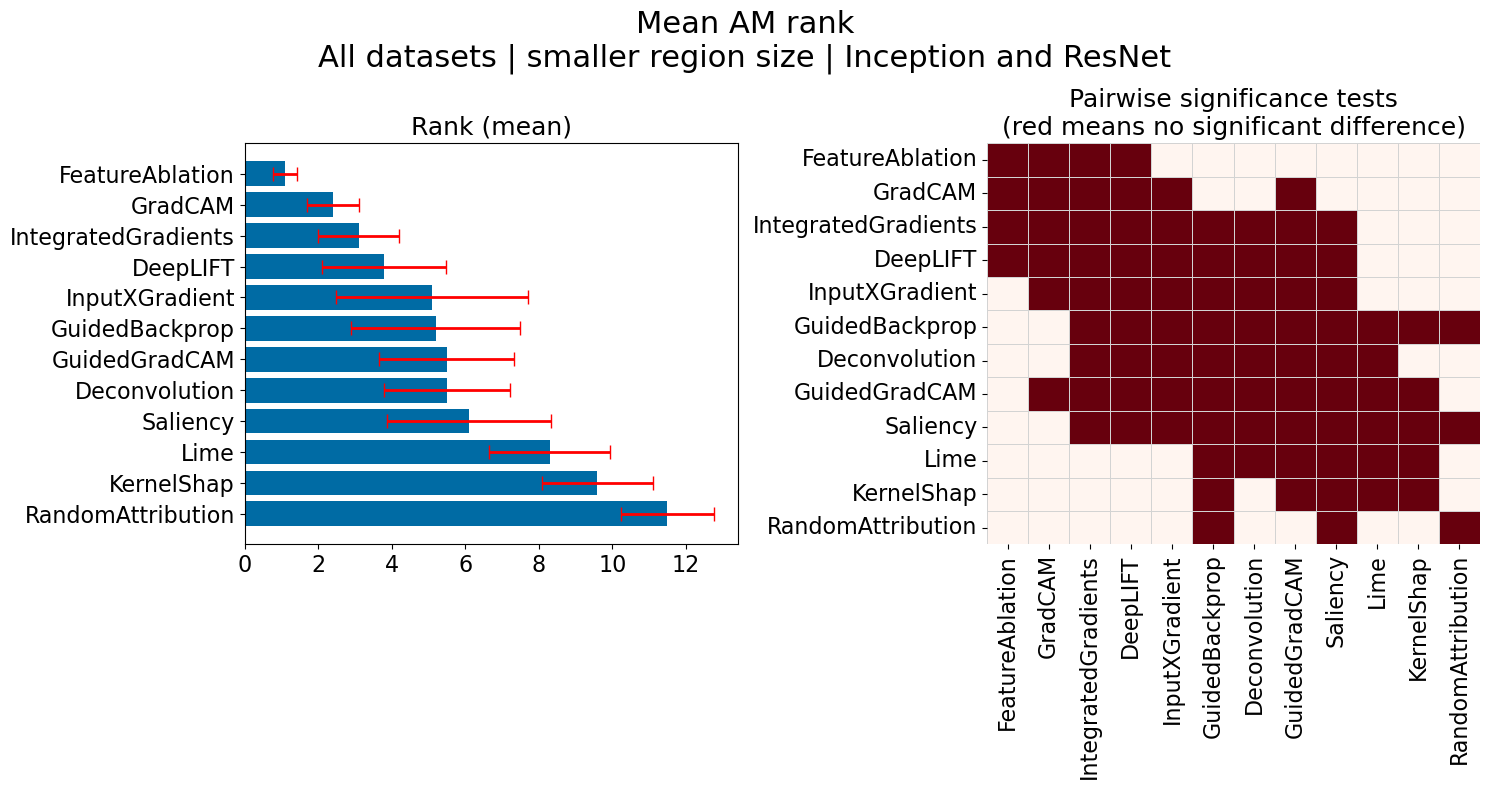

AM  Rank (mean)  Rank (std)
0       FeatureAblation          1.1        0.32
3               GradCAM          2.4        0.70
1   IntegratedGradients          3.1        1.10
4              DeepLIFT          3.8        1.69
2        InputXGradient          5.1        2.60
10       GuidedBackprop          5.2        2.30
6         Deconvolution          5.5        1.72
8         GuidedGradCAM          5.5        1.84
5              Saliency          6.1        2.23
7                  Lime          8.3        1.64
9            KernelShap          9.6        1.51
11    RandomAttribution         11.5        1.27

\begin{tabular}{lrr}
\toprule
                 AM &  Rank (mean) &  Rank (std) \\
\midrule
    FeatureAblation &          1.1 &        0.32 \\
            GradCAM &          2.4 &        0.70 \\
IntegratedGradients &          3.1 &        1.10 \\
           DeepLIFT &          3.8 &        1.69 \\
     InputXGradient &          5.1 &        2.60 \\
     GuidedBackprop &          5.2 &        2.30 \\
      Deconvolution &          5.5 &        1.72 \\
      GuidedGradCAM &          5.5 &        1.84 \\
           Saliency &          6.1 &        2.23 \\
               Lime &          8.3 &        1.64 \\
         KernelShap &          9.6 &        1.51 \\
  RandomAttribution &         11.5 &        1.27 \\
\bottomrule
\end{tabular}



AM                 Rank
0       FeatureAblation   1.1 PLUSMINUS 0.32
3               GradCAM    2.4 PLUSMINUS 0.7
1   IntegratedGradients    3.1 PLUSMINUS 1.1
4              DeepLIFT   3.8 PLUSMINUS 1.69
2        InputXGradient    5.1 PLUSMINUS 2.6
10       GuidedBackprop    5.2 PLUSMINUS 2.3
6         Deconvolution   5.5 PLUSMINUS 1.72
8         GuidedGradCAM   5.5 PLUSMINUS 1.84
5              Saliency   6.1 PLUSMINUS 2.23
7                  Lime   8.3 PLUSMINUS 1.64
9            KernelShap   9.6 PLUSMINUS 1.51
11    RandomAttribution  11.5 PLUSMINUS 1.27

\begin{tabular}{ll}
\toprule
                 AM &                Rank \\
\midrule
    FeatureAblation &  1.1 PLUSMINUS 0.32 \\
            GradCAM &   2.4 PLUSMINUS 0.7 \\
IntegratedGradients &   3.1 PLUSMINUS 1.1 \\
           DeepLIFT &  3.8 PLUSMINUS 1.69 \\
     InputXGradient &   5.1 PLUSMINUS 2.6 \\
     GuidedBackprop &   5.2 PLUSMINUS 2.3 \\
      Deconvolution &  5.5 PLUSMINUS 1.72 \\
      GuidedGradCAM &  5.5 PLUSMINUS 1.84 \\
           Saliency &  6.1 PLUSMINUS 2.23 \\
               Lime &  8.3 PLUSMINUS 1.64 \\
         KernelShap &  9.6 PLUSMINUS 1.51 \\
  RandomAttribution & 11.5 PLUSMINUS 1.27 \\
\bottomrule
\end{tabular}



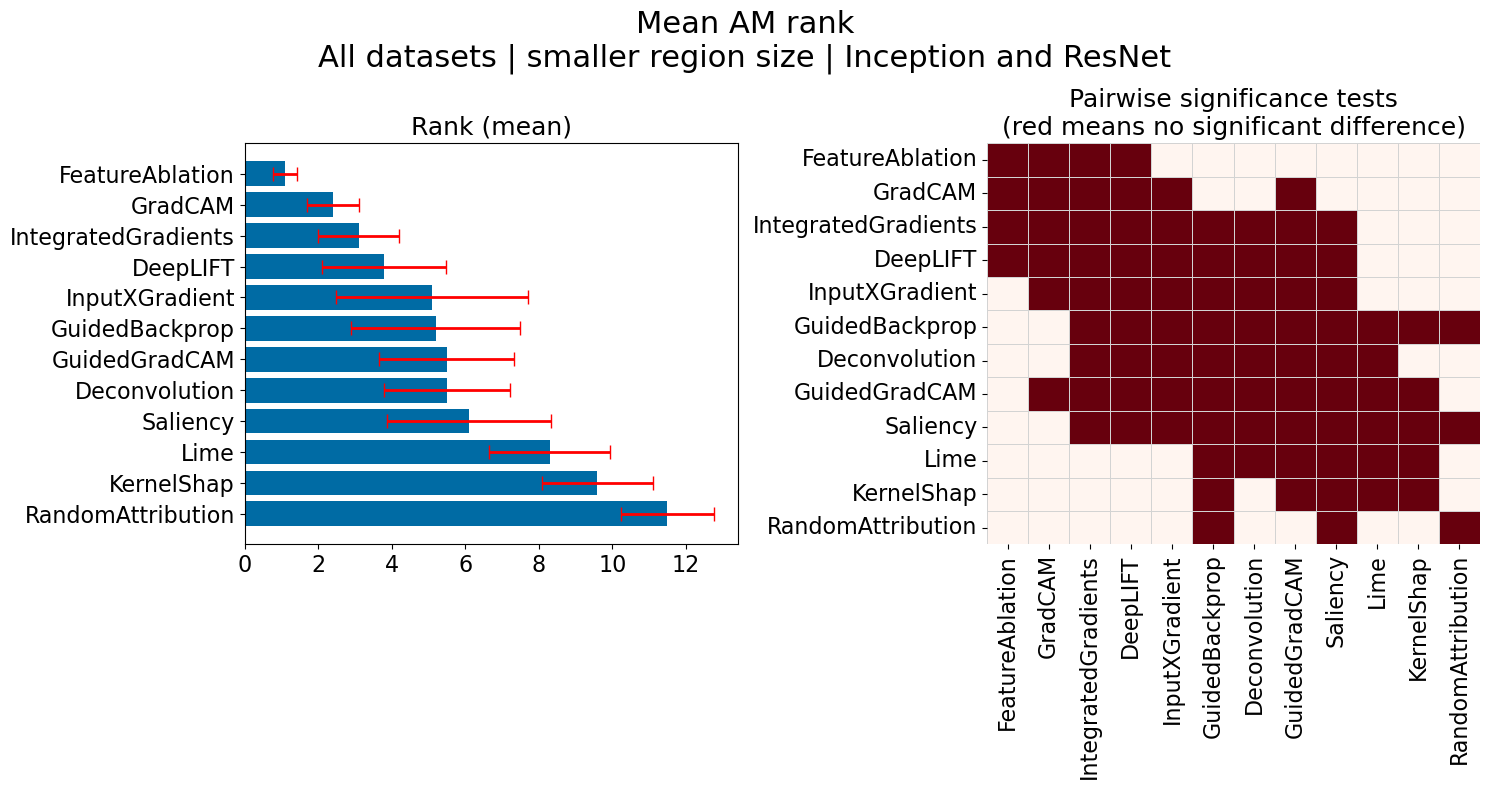

AM  Rank (mean)  Rank (std)
0               GradCAM          1.1        0.32
1       FeatureAblation          1.7        0.82
2   IntegratedGradients          3.0        1.05
4              DeepLIFT          3.6        1.71
5         GuidedGradCAM          5.1        1.45
3        InputXGradient          5.2        1.62
7        GuidedBackprop          5.9        0.99
8         Deconvolution          6.2        1.23
6              Saliency          6.5        1.72
9                  Lime          9.6        1.07
10           KernelShap          9.9        0.57
11    RandomAttribution         11.8        0.63

\begin{tabular}{lrr}
\toprule
                 AM &  Rank (mean) &  Rank (std) \\
\midrule
            GradCAM &          1.1 &        0.32 \\
    FeatureAblation &          1.7 &        0.82 \\
IntegratedGradients &          3.0 &        1.05 \\
           DeepLIFT &          3.6 &        1.71 \\
      GuidedGradCAM &          5.1 &        1.45 \\
     InputXGradient &          5.2 &        1.62 \\
     GuidedBackprop &          5.9 &        0.99 \\
      Deconvolution &          6.2 &        1.23 \\
           Saliency &          6.5 &        1.72 \\
               Lime &          9.6 &        1.07 \\
         KernelShap &          9.9 &        0.57 \\
  RandomAttribution &         11.8 &        0.63 \\
\bottomrule
\end{tabular}



AM                 Rank
0               GradCAM   1.1 PLUSMINUS 0.32
1       FeatureAblation   1.7 PLUSMINUS 0.82
2   IntegratedGradients   3.0 PLUSMINUS 1.05
4              DeepLIFT   3.6 PLUSMINUS 1.71
5         GuidedGradCAM   5.1 PLUSMINUS 1.45
3        InputXGradient   5.2 PLUSMINUS 1.62
7        GuidedBackprop   5.9 PLUSMINUS 0.99
8         Deconvolution   6.2 PLUSMINUS 1.23
6              Saliency   6.5 PLUSMINUS 1.72
9                  Lime   9.6 PLUSMINUS 1.07
10           KernelShap   9.9 PLUSMINUS 0.57
11    RandomAttribution  11.8 PLUSMINUS 0.63

\begin{tabular}{ll}
\toprule
                 AM &                Rank \\
\midrule
            GradCAM &  1.1 PLUSMINUS 0.32 \\
    FeatureAblation &  1.7 PLUSMINUS 0.82 \\
IntegratedGradients &  3.0 PLUSMINUS 1.05 \\
           DeepLIFT &  3.6 PLUSMINUS 1.71 \\
      GuidedGradCAM &  5.1 PLUSMINUS 1.45 \\
     InputXGradient &  5.2 PLUSMINUS 1.62 \\
     GuidedBackprop &  5.9 PLUSMINUS 0.99 \\
      Deconvolution &  6.2 PLUSMINUS 1.23 \\
           Saliency &  6.5 PLUSMINUS 1.72 \\
               Lime &  9.6 PLUSMINUS 1.07 \\
         KernelShap &  9.9 PLUSMINUS 0.57 \\
  RandomAttribution & 11.8 PLUSMINUS 0.63 \\
\bottomrule
\end{tabular}



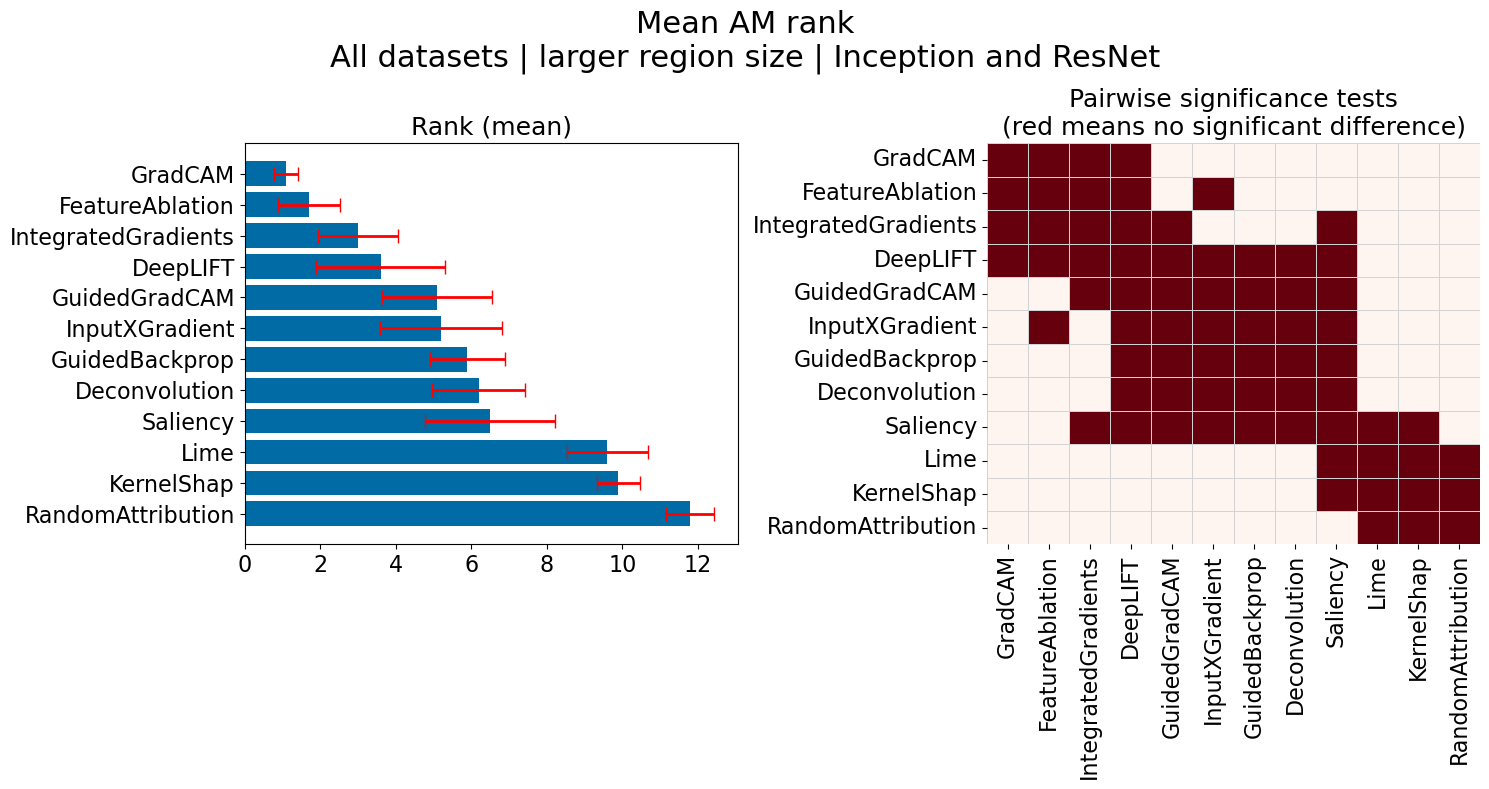

RandomAttribution: different: False
KernelShap: different: False
Lime: different: True
Saliency: different: False
Deconvolution: different: False
GuidedGradCAM: different: False
GuidedBackprop: different: False
InputXGradient: different: False
DeepLIFT: different: False
IntegratedGradients: different: False
GradCAM: different: True
FeatureAblation: different: False


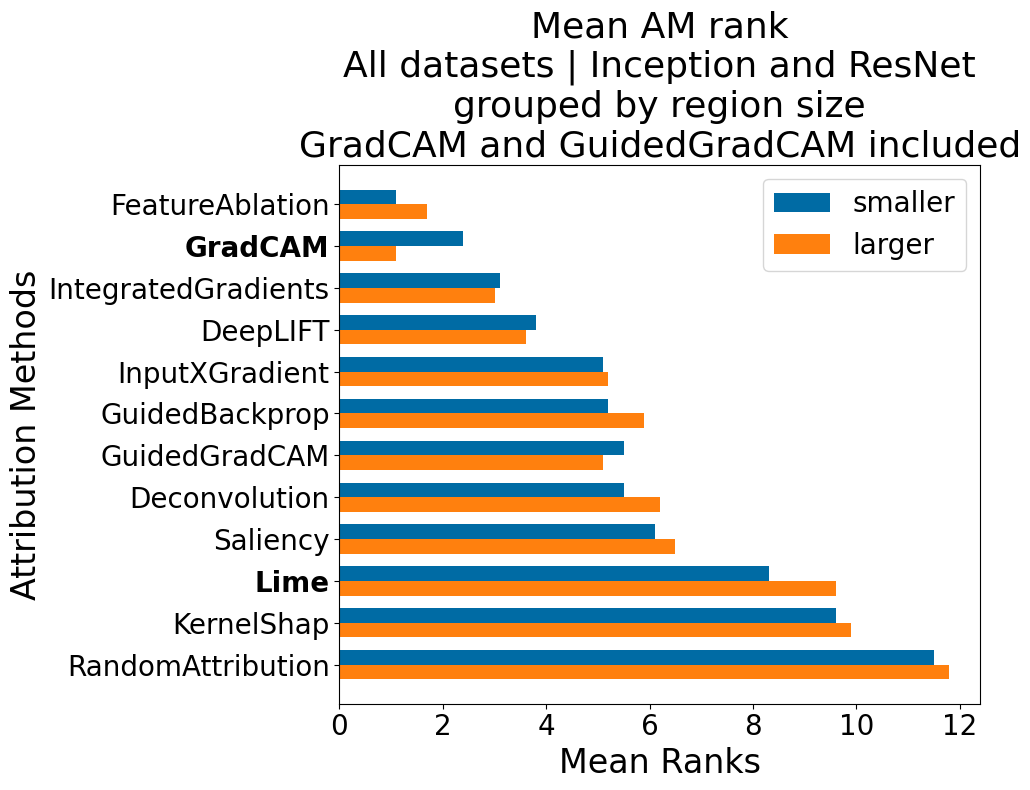

In [45]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# # GENERATES FIGURES FOR SECTION: "Region Size Insights / Impact of region size on AM ranking"
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
ticks_fontsize = 16
axis_label_fontsize = 18
suptitle_fontsize = 22
axs_title_fontsize = 18
bar_label_fontsize = 14

def get_mean_am_ranking_over_region_size(models, ignore_ams=[], region_sizes=['smaller', 'larger'], plot_results=False, save_name_suffix='', return_individual_rankings=False):
    am_res_obj = {}
    list_of_am_tied_ranking_results = []
    for model in models:
        for dataset in datasets:
            for region_size in region_sizes:
                list_of_am_tied_ranking_results.append(get_am_ranking_accounting_for_ties(model, dataset, region_size, ignore_ams))
                
    results_df = pd.DataFrame(list_of_am_tied_ranking_results)

    # return
    # print(f'#rankings: {len(results_df)}')
    for col_name in results_df.columns:
        # print(f'{col_name}: {results_df[col_name].mean()} ({results_df[col_name].std():.2f})')
        if col_name not in am_res_obj:
            am_res_obj[col_name] = {}
        am_res_obj[col_name]['Rank (mean)'] = round(results_df[col_name].mean(), 2)
        am_res_obj[col_name]['Rank (std)'] = round(results_df[col_name].std(), 2)

    res_list = []
    for am in am_res_obj:
        res_obj = {'AM' : am}
        for col_name in am_res_obj[am]:
            res_obj[col_name] = am_res_obj[am][col_name]
        res_list.append(res_obj)
    res_df = pd.DataFrame(res_list)
    res_df = res_df.sort_values(by='Rank (mean)')
    display(res_df) # SAVE THIS !!!
    print(res_df.to_latex(index=False))
    res_df.to_csv(f'{results_dir}/tables/mean_am_rank_ALL{save_name_suffix}.csv', index=False, header=True)

    alt_res_df = res_df.copy()
    
    alt_res_df['Rank'] = alt_res_df['Rank (mean)'].astype(str) + " PLUSMINUS " + alt_res_df['Rank (std)'].astype(str)
    alt_res_df = alt_res_df.drop(columns=['Rank (mean)', 'Rank (std)'])

    display(alt_res_df)
    print(alt_res_df.to_latex(index=False))

    ####################################################################################################################################################################################
    # Compute significant differences
    ####################################################################################################################################################################################
    sig_diff_matrix = []
    significance_test_results = []
    n_comparisons = len(results_df.columns) - 1
    labels = []
    for i, am_i_name in enumerate(list(alt_res_df['AM'])):
        significance_test_row = {
            '-' : am_i_name,
        }
        labels.append(am_i_name)

        am_1_ranks = results_df[am_i_name]
        sig_diffs = []
        for j, am_j_name in enumerate(list(alt_res_df['AM'])):
            am_2_ranks = results_df[am_j_name]
            # am_2_weights = avg_am_rank_cmi_2_adjusted[j]['weights']

            # Calculate the differences between paired observations
            differences = am_1_ranks - am_2_ranks

            if np.all(differences == 0):
                sig_diffs.append(False)
                significance_test_row['{} - test statistic'.format(am_j_name)] = None
                significance_test_row['{} - p-value'.format(am_j_name)] = None
                continue

            # wilcoxon test chosen, because it often happens that differences are not normally distributed
            stat, p_value = wilcoxon(differences)

            sig_diffs.append(p_value < (0.05 / n_comparisons))

            significance_test_row['{} - test statistic'.format(am_j_name)] = stat
            significance_test_row['{} - p-value'.format(am_j_name)] = p_value
        significance_test_results.append(significance_test_row)

        sig_diff_matrix.append(sig_diffs)

    sig_df = pd.DataFrame(significance_test_results)
    sig_df.to_csv(f'{results_dir}/tables/mean_am_rank_ALL{save_name_suffix}_sig_tests.csv', index=False)
    ####################################################################################################################################################################################


    if plot_results:
        # filtered_columns = res_df.filter(like='Rank (mean)', axis=1)
        # for f_col in filtered_columns:
        res_df = res_df.sort_values(by='Rank (mean)', ascending=False)

        fig, axs = plt.subplots(1,2, figsize=(15,8))

        if models == ['Inception', 'ResNet' ]:
            fig.suptitle(f'Mean AM rank\nAll datasets | {region_sizes[0]} region size | Inception and ResNet', fontsize=suptitle_fontsize)
        else:
            fig.suptitle(f'Mean AM rank\nAll datasets | {region_sizes[0]} region size | All models', fontsize=suptitle_fontsize)
            
        fig.set_facecolor('white')

        axs[0].set_title('Rank (mean)', fontsize=axs_title_fontsize)
        axs[0].barh(res_df['AM'], res_df['Rank (mean)'])
        axs[0].errorbar(res_df['Rank (mean)'], range(len(res_df)), xerr=res_df['Rank (std)'], fmt='none', ecolor='red', capsize=5, linewidth = 2)
        
        sns.heatmap(sig_diff_matrix, annot=False, fmt="d", cmap="Reds_r", vmin=0, vmax=1, xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='lightgray', ax=axs[1], cbar=False)
        axs[1].set_title('Pairwise significance tests\n(red means no significant difference)', fontsize=axs_title_fontsize)

        axs[0].tick_params(axis='y', labelsize=ticks_fontsize)
        axs[1].tick_params(axis='y', labelsize=ticks_fontsize)

        axs[0].tick_params(axis='x', labelsize=ticks_fontsize)
        axs[1].tick_params(axis='x', labelsize=ticks_fontsize)

        plt.tight_layout()        
        plt.show()

    if return_individual_rankings:
        return results_df
    else:
        return res_df # mean ranking
    

no_gradcam = False

if no_gradcam:
# # NO GRADCAM
    df_s = get_mean_am_ranking_over_region_size(['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ], ['GradCAM', 'GuidedGradCAM'], region_sizes=['smaller'], plot_results=True, save_name_suffix = '_all_models_no_gradcam_smaller_rs', return_individual_rankings=True)
    df_s_sorted = get_mean_am_ranking_over_region_size(['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ], ['GradCAM', 'GuidedGradCAM'], region_sizes=['smaller'], plot_results=True, save_name_suffix = '_all_models_no_gradcam_smaller_rs')
    df_l = get_mean_am_ranking_over_region_size(['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ], ['GradCAM', 'GuidedGradCAM'], region_sizes=['larger'], plot_results=True, save_name_suffix = '_all_models_no_gradcam_larger_rs', return_individual_rankings=True)
else:
# # CNNs only
    df_s = get_mean_am_ranking_over_region_size(['Inception', 'ResNet' ], region_sizes=['smaller'], plot_results=True, save_name_suffix = '_cnns_incl_gradcam_smaller_rs', return_individual_rankings=True)
    df_s_sorted = get_mean_am_ranking_over_region_size(['Inception', 'ResNet' ], region_sizes=['smaller'], plot_results=True, save_name_suffix = '_cnns_incl_gradcam_smaller_rs') # just to get the correct AM sorting
    df_l = get_mean_am_ranking_over_region_size(['Inception', 'ResNet' ], region_sizes=['larger'], plot_results=True, save_name_suffix = '_cnns_incl_gradcam_larger_rs', return_individual_rankings=True)

categories = list(df_s_sorted['AM'])
values_s = []
values_l = []
sig_diffs = []

for col in categories:
    values_s.append(df_s[col].mean())
    values_l.append(df_l[col].mean())
    s, p_val = wilcoxon(df_s[col], df_l[col])
    sig_diffs.append(p_val < 0.05)
    print(f'{col}: different: {p_val < 0.05}')

y = np.arange(len(categories))  # the label locations
height = 0.35  # the height of the bars
modifier = 4

# Plotting
fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')
rects1 = ax.barh(y + height/2, values_s, height, label='smaller')
rects2 = ax.barh(y - height/2, values_l, height, label='larger')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Attribution Methods', fontsize=axis_label_fontsize+modifier+2)
ax.set_xlabel('Mean Ranks', fontsize=axis_label_fontsize+modifier+2)
if no_gradcam:
    ax.set_title('Mean AM rank\nAll datasets | all models\ngrouped by region size\nGradCAM and GuidedGradCAM excluded', fontsize=suptitle_fontsize+modifier)
else:
    ax.set_title('Mean AM rank\nAll datasets | Inception and ResNet\ngrouped by region size\nGradCAM and GuidedGradCAM included', fontsize=suptitle_fontsize+modifier)
ax.set_yticks(y)
yticklabels = ax.set_yticklabels(categories)
for label in yticklabels:
    am_idx = categories.index(label.get_text())
    if sig_diffs[am_idx]:
        label.set_fontweight('bold')
ax.legend(fontsize=ticks_fontsize+modifier)

ax.tick_params(axis='x', labelsize=ticks_fontsize+modifier)
ax.tick_params(axis='y', labelsize=ticks_fontsize+modifier)

plt.tight_layout()
plt.show()

### Impact of region size on CMI_max (over all datasets and models)

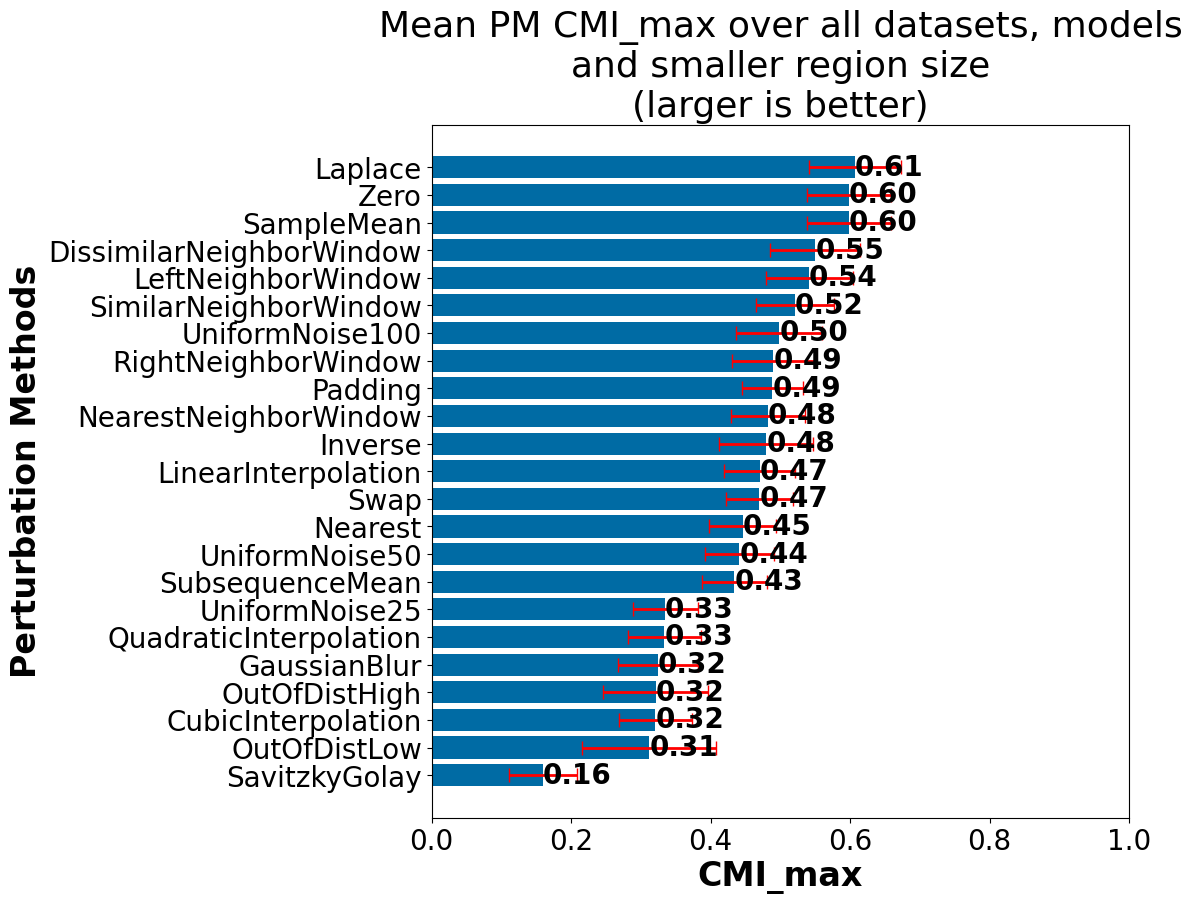

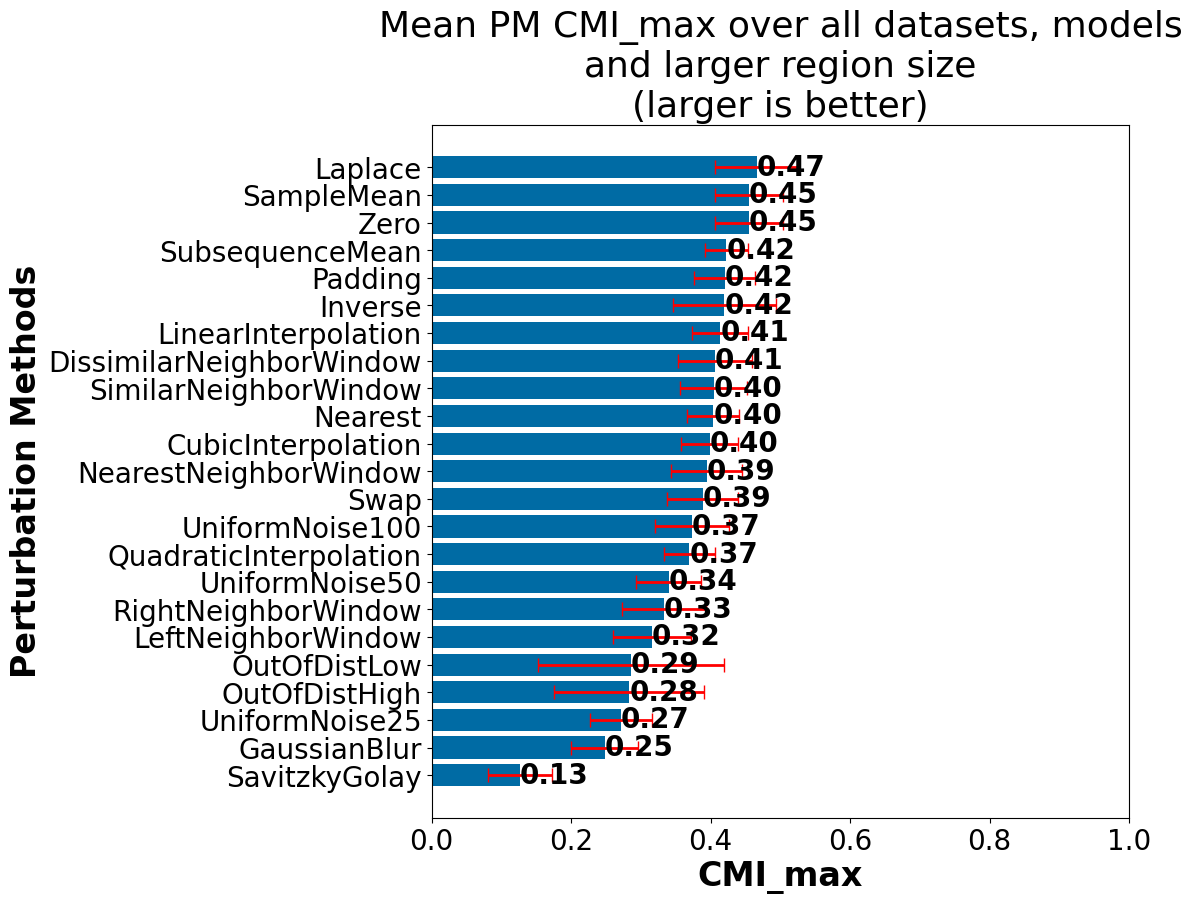

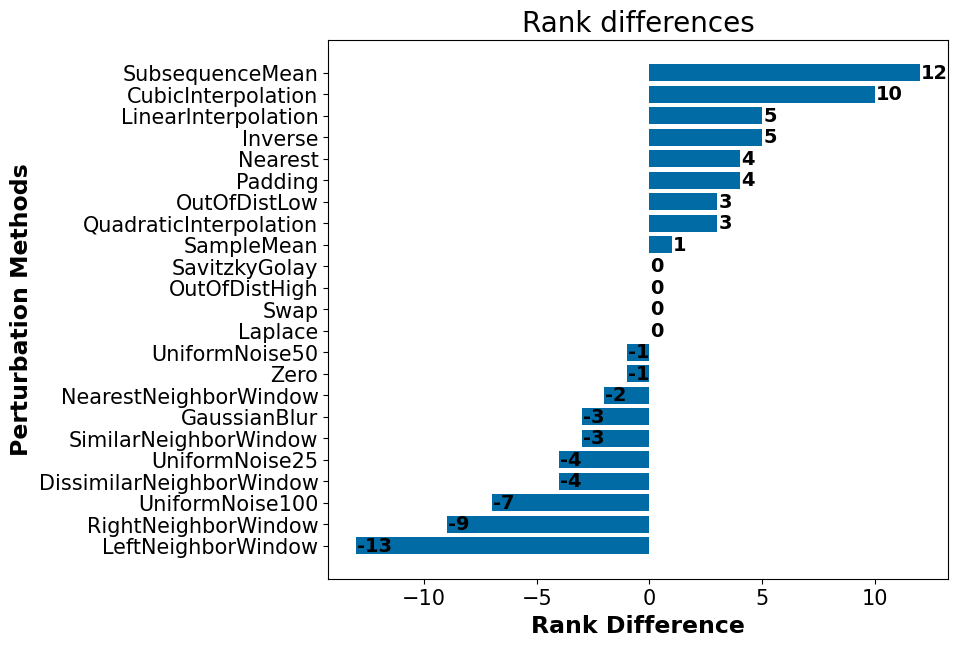

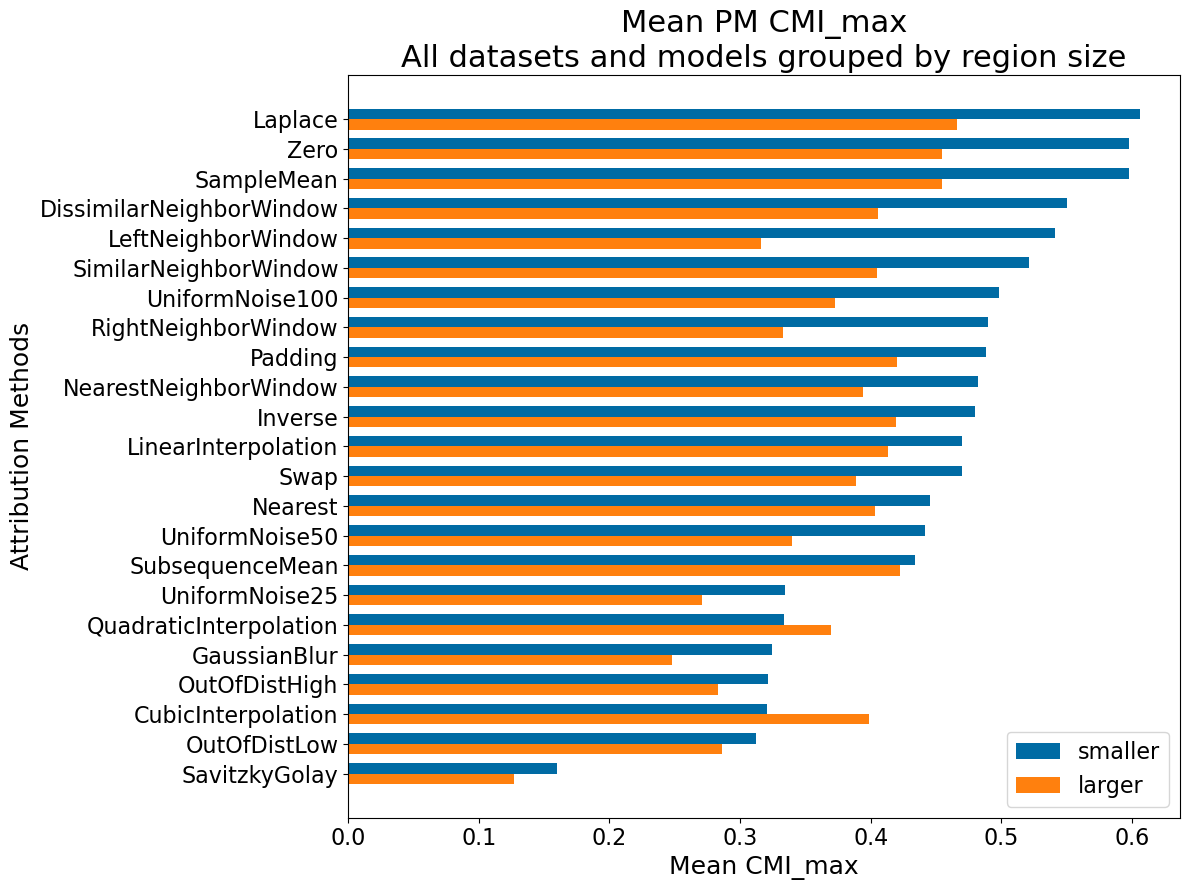

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# GENERATES FIGURES FOR SECTION: "Region Size Insights / Impact of region size on overall PM ranking \textbf{$CMI_{max}$}"
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']
region_sizes = [ 'smaller', 'larger']
# print('Over everything')
ranking_s = compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, datasets, ['smaller'], title='Mean PM CMI_max over all datasets, models\nand smaller region size', significance_tests=False, fname='PM_CMI_max_ALL_smaller')
                                            
ranking_l = compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, datasets, ['larger'], title='Mean PM CMI_max over all datasets, models\nand larger region size', significance_tests=False, fname='PM_CMI_max_ALL_larger')
rd = compute_rank_differences(ranking_s[::-1], ranking_l[::-1])


pm_rank_differences = {}
pm_cmi_differences = {}
# Create table for paper
ranking_s_dict = {}
for r in ranking_s:
    ranking_s_dict[r['pm']] = r.copy()
    del ranking_s_dict[r['pm']]['pm']

ranking_l_dict = {}
for r in ranking_l:
    ranking_l_dict[r['pm']] = r.copy()
    del ranking_l_dict[r['pm']]['pm']

combined = []
all_pms_cmi_max_smaller = []
all_pms_cmi_max_larger  = []
for pm in ranking_s_dict:
    all_pms_cmi_max_smaller.append(ranking_s_dict[pm]['max-cmi (mean)'])
    all_pms_cmi_max_larger.append(ranking_l_dict[pm]['max-cmi (mean)'])
    combined.append({
        'perturbation method' : pm,
        'CMI_max - (difference: s - l)' :ranking_s_dict[pm]['max-cmi (mean)'] - ranking_l_dict[pm]['max-cmi (mean)'],  
        'smaller - CMI_max (mean)' : ranking_s_dict[pm]['max-cmi (mean)'],
        'smaller - CMI_max (std)' : ranking_s_dict[pm]['max-cmi (std)'],
        'larger - CMI_max (mean)' : ranking_l_dict[pm]['max-cmi (mean)'],
        'larger - CMI_max (std)' : ranking_l_dict[pm]['max-cmi (std)']
    })
    
    if pm not in pm_cmi_differences:
        pm_cmi_differences[pm] = []
    pm_cmi_differences[pm].append(ranking_s_dict[pm]['max-cmi (mean)'] - ranking_l_dict[pm]['max-cmi (mean)'])
pm_cmi_differences


########################################################################################################################################################################################################################
########################################################################################################################################################################################################################
########################################################################################################################################################################################################################

categories = list(ranking_s_dict.keys())
values_s = []
values_l = []

for col in categories:
    values_s.append(ranking_s_dict[col]['max-cmi (mean)'])
    values_l.append(ranking_l_dict[col]['max-cmi (mean)'])

y = np.arange(len(categories))  # the label locations
height = 0.35  # the height of the bars


# Plotting
fig, ax = plt.subplots(figsize=(12,9))
rects1 = ax.barh(y + height/2, values_s, height, label='smaller')
rects2 = ax.barh(y - height/2, values_l, height, label='larger')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Attribution Methods', fontsize=axis_label_fontsize)
ax.set_xlabel('Mean CMI_max', fontsize=axis_label_fontsize)
ax.set_title('Mean PM CMI_max\nAll datasets and models grouped by region size', fontsize=suptitle_fontsize)
ax.set_yticks(y)
ax.set_yticklabels(categories)
ax.legend(fontsize=ticks_fontsize)

ax.tick_params(axis='x', labelsize=ticks_fontsize)
ax.tick_params(axis='y', labelsize=ticks_fontsize)
fig.set_facecolor('white')

plt.tight_layout()
plt.show()

### Impact of region size on CMI_max - dataset types

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# GENERATES FIGURES FOR SECTION: "Region Size Insights / Impact of region size on PM ranking for individual datasets"
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
models = ['Inception', 'LSTM', 'MLP', 'ResNet', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']

ticks_fontsize = 15
axis_label_fontsize = 17
axs_title_fontsize = 20

pm_rank_differences = {}
pm_cmi_differences = {}
# across individual datasets
# for dataset in datasets:
save_dir = f'{results_dir}/pm_ranking_region_size_impact'

for dataset in datasets:
    print('**************************************************************************************************************************************************************')
    print('**************************************************************************************************************************************************************')
    print('**************************************************************************************************************************************************************')
    print()
    print(dataset)
    print()
    # NOTE: No pairwise significance tests since only 5 values used to compute mean
    
    dataset_name = dataset.replace('NonInvasiveFetalECGThorax','ECG')

    ranking_s = compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, [dataset], [ 'smaller'], significance_tests = False, title='Mean PM CMI_max\n{} | all models | smaller region size'.format(dataset_name), fname=f'rs/PM_CMI_max_all_models_{dataset}_smaller')
    ranking_l = compute_mean_cmi_max_pm_ranking_holm_bonferroni(models, [dataset], [ 'larger'], significance_tests = False, title='Mean PM CMI_max\n{} | all models | larger region size'.format(dataset_name), fname=f'rs/PM_CMI_max_all_models_{dataset}_larger')
    rds = compute_rank_differences(ranking_s[::-1], ranking_l[::-1], savepath=os.path.join(save_dir, f'pm_ranking_{dataset_name}_rank_diff'))

    for rd in rds:
        if rd['pm'] not in pm_rank_differences:
            pm_rank_differences[rd['pm']] = []
        pm_rank_differences[rd['pm']].append(rd['rank_difference'])

    # Create table for paper
    ranking_s_dict = {}
    for r in ranking_s:
        ranking_s_dict[r['pm']] = r.copy()
        del ranking_s_dict[r['pm']]['pm']

    ranking_l_dict = {}
    for r in ranking_l:
        ranking_l_dict[r['pm']] = r.copy()
        del ranking_l_dict[r['pm']]['pm']

    combined = []
    all_pms_cmi_max_smaller = []
    all_pms_cmi_max_larger  = []
    for pm in ranking_s_dict:
        all_pms_cmi_max_smaller.append(ranking_s_dict[pm]['max-cmi (mean)'])
        all_pms_cmi_max_larger.append(ranking_l_dict[pm]['max-cmi (mean)'])
        combined.append({
            'perturbation method' : pm,
            'CMI_max - (difference: s - l)' :ranking_s_dict[pm]['max-cmi (mean)'] - ranking_l_dict[pm]['max-cmi (mean)'],  
            'smaller - CMI_max (mean)' : ranking_s_dict[pm]['max-cmi (mean)'],
            'smaller - CMI_max (std)' : ranking_s_dict[pm]['max-cmi (std)'],
            'larger - CMI_max (mean)' : ranking_l_dict[pm]['max-cmi (mean)'],
            'larger - CMI_max (std)' : ranking_l_dict[pm]['max-cmi (std)']
        })
        
        if pm not in pm_cmi_differences:
            pm_cmi_differences[pm] = []
        pm_cmi_differences[pm].append(ranking_s_dict[pm]['max-cmi (mean)'] - ranking_l_dict[pm]['max-cmi (mean)'])
        
    all_pms_cmi_max_smaller = np.array(all_pms_cmi_max_smaller)
    all_pms_cmi_max_larger  = np.array(all_pms_cmi_max_larger)
    print(f'smaller - max: {all_pms_cmi_max_smaller.max():.3f} | min: {all_pms_cmi_max_smaller.min():.3f} | mean: {all_pms_cmi_max_smaller.mean():.3f} | std: {all_pms_cmi_max_smaller.std():.3f}')
    print(f'larger  - max: {all_pms_cmi_max_larger.max():.3f} | min: {all_pms_cmi_max_larger.min():.3f} | mean: {all_pms_cmi_max_larger.mean():.3f} | std: {all_pms_cmi_max_larger.std():.3f}')
    print(f'diff  -   max: {all_pms_cmi_max_smaller.max()-all_pms_cmi_max_larger.max():.3f} | min: {all_pms_cmi_max_smaller.min()-all_pms_cmi_max_larger.min():.3f} | mean: {all_pms_cmi_max_smaller.mean()-all_pms_cmi_max_larger.mean():.3f} | std: {all_pms_cmi_max_smaller.std()-all_pms_cmi_max_larger.std():.3f}')

    rank_diff_df = pd.DataFrame(combined)

    ######################################## PLOT CMI_max DIFFERENCE ########################################
    rank_diff_df = rank_diff_df.sort_values(by='CMI_max - (difference: s - l)')
    fig, ax = plt.subplots(1,1, figsize=(8,7))
    bars = ax.barh(rank_diff_df['perturbation method'], rank_diff_df['CMI_max - (difference: s - l)'])
    ax.set_xlim(-1,1)

    
    ax.set_title(f'(smaller - larger) mean CMI_max per PM\n{dataset_name} | all models', fontsize=axs_title_fontsize)
    ax.tick_params(axis='y', labelsize=ticks_fontsize)
    ax.tick_params(axis='x', labelsize=ticks_fontsize)
    fig.set_facecolor('white')    
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, '{:.2f}'.format(width), ha='left', va='center', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

print()

In [46]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# COMPUTES DATA FOR SECTION: "Region Size Insights / Impact of region size on PM ranking for individual datasets"
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for pm in pm_cmi_differences:
    print(f'{pm} : {np.array(pm_cmi_differences[pm]).mean():.3f}')

SavitzkyGolay : 0.033
UniformNoise25 : 0.064
QuadraticInterpolation : -0.036
CubicInterpolation : -0.078
OutOfDistHigh : 0.038
OutOfDistLow : 0.026
UniformNoise50 : 0.102
Inverse : 0.060
Nearest : 0.042
GaussianBlur : 0.077
NearestNeighborWindow : 0.088
SubsequenceMean : 0.011
UniformNoise100 : 0.125
LinearInterpolation : 0.056
Swap : 0.081
Padding : 0.069
SampleMean : 0.143
Zero : 0.143
RightNeighborWindow : 0.157
Laplace : 0.140
LeftNeighborWindow : 0.225
DissimilarNeighborWindow : 0.144
SimilarNeighborWindow : 0.116


SavitzkyGolay : 0.040
UniformNoise25 : 0.064
QuadraticInterpolation : 0.070
CubicInterpolation : 0.156
OutOfDistHigh : 0.038
OutOfDistLow : 0.026
UniformNoise50 : 0.102
Inverse : 0.060
Nearest : 0.057
GaussianBlur : 0.083
NearestNeighborWindow : 0.163
SubsequenceMean : 0.120
UniformNoise100 : 0.125
LinearInterpolation : 0.116
Swap : 0.166
Padding : 0.133
SampleMean : 0.143
Zero : 0.143
RightNeighborWindow : 0.233
Laplace : 0.140
LeftNeighborWindow : 0.295
DissimilarNeighborWindow : 0.229
SimilarNeighborWindow : 0.204


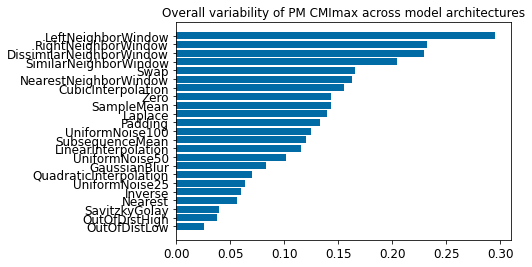

In [22]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# GENERATES FIGURES FOR SECTION: "Region Size Insights / Impact of region size on PM ranking for individual datasets"
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

pms = []
values = []

for pm in pm_cmi_differences:
    # print(f'{pm} : {np.array(pm_cmi_differences[pm]).mean():.3f}')
    print(f'{pm} : {abs(np.array(pm_cmi_differences[pm])).mean():.3f}')
    pms.append(pm)
    values.append(abs(np.array(pm_cmi_differences[pm])).mean())


sorted_data = sorted(zip(values, pms), reverse=False)

values = [x[0] for x in sorted_data]
pms = [x[1] for x in sorted_data]

plt.barh(pms,values)
plt.title('Overall variability of PM CMImax across model architectures')
plt.show()

### Impact of region size on CMI_max - model architectures

In [9]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# GENERATES FIGURES FOR SECTION: "Region Size Insights / Impact of region size on PM ranking for model architectures"
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

models = ['Inception', 'ResNet', 'LSTM', 'MLP', 'ViT' ]
datasets = ['FordA', 'FordB', 'NonInvasiveFetalECGThorax1', 'NonInvasiveFetalECGThorax2', 'Wafer']

ticks_fontsize = 15
axis_label_fontsize = 17
axs_title_fontsize = 20

pm_rank_differences = {}
pm_cmi_differences = {}
# across individual datasets
# for dataset in datasets:
save_dir = f'{results_dir}/pm_ranking_region_size_impact'

for model in models:
    print('**************************************************************************************************************************************************************')
    print('**************************************************************************************************************************************************************')
    print('**************************************************************************************************************************************************************')
    print()
    print(model)
    print()
    # NOTE: No pairwise significance tests since only 5 values used to compute mean
    

    ranking_s = compute_mean_cmi_max_pm_ranking_holm_bonferroni([model], datasets, [ 'smaller'], significance_tests = False, title='Mean PM CMI_max\nAll datasets | {} | smaller region size'.format(model), fname=f'rs/PM_CMI_max_all_datasets_{model}_smaller')
    ranking_l = compute_mean_cmi_max_pm_ranking_holm_bonferroni([model], datasets, [ 'larger' ], significance_tests = False, title='Mean PM CMI_max\nAll datasets | {} | larger region size'.format(model), fname=f'rs/PM_CMI_max_all_datasets_{model}_larger')

    rds = compute_rank_differences(ranking_s[::-1], ranking_l[::-1], savepath=os.path.join(save_dir, f'pm_ranking_{model}_rank_diff'))

    for rd in rds:
        if rd['pm'] not in pm_rank_differences:
            pm_rank_differences[rd['pm']] = []
        pm_rank_differences[rd['pm']].append(rd['rank_difference'])

    # Create table for paper
    ranking_s_dict = {}
    for r in ranking_s:
        ranking_s_dict[r['pm']] = r.copy()
        del ranking_s_dict[r['pm']]['pm']

    ranking_l_dict = {}
    for r in ranking_l:
        ranking_l_dict[r['pm']] = r.copy()
        del ranking_l_dict[r['pm']]['pm']

    combined = []
    all_pms_cmi_max_smaller = []
    all_pms_cmi_max_larger  = []
    for pm in ranking_s_dict:
        all_pms_cmi_max_smaller.append(ranking_s_dict[pm]['max-cmi (mean)'])
        all_pms_cmi_max_larger.append(ranking_l_dict[pm]['max-cmi (mean)'])
        combined.append({
            'perturbation method' : pm,
            'CMI_max - (difference: s - l)' :ranking_s_dict[pm]['max-cmi (mean)'] - ranking_l_dict[pm]['max-cmi (mean)'],  
            'smaller - CMI_max (mean)' : ranking_s_dict[pm]['max-cmi (mean)'],
            'smaller - CMI_max (std)' : ranking_s_dict[pm]['max-cmi (std)'],
            'larger - CMI_max (mean)' : ranking_l_dict[pm]['max-cmi (mean)'],
            'larger - CMI_max (std)' : ranking_l_dict[pm]['max-cmi (std)']
        })
        
        if pm not in pm_cmi_differences:
            pm_cmi_differences[pm] = []
        pm_cmi_differences[pm].append(ranking_s_dict[pm]['max-cmi (mean)'] - ranking_l_dict[pm]['max-cmi (mean)'])
        
    all_pms_cmi_max_smaller = np.array(all_pms_cmi_max_smaller)
    all_pms_cmi_max_larger  = np.array(all_pms_cmi_max_larger)
    print(f'smaller - max: {all_pms_cmi_max_smaller.max():.3f} | min: {all_pms_cmi_max_smaller.min():.3f} | mean: {all_pms_cmi_max_smaller.mean():.3f} | std: {all_pms_cmi_max_smaller.std():.3f}')
    print(f'larger  - max: {all_pms_cmi_max_larger.max():.3f} | min: {all_pms_cmi_max_larger.min():.3f} | mean: {all_pms_cmi_max_larger.mean():.3f} | std: {all_pms_cmi_max_larger.std():.3f}')
    print(f'diff  -   max: {all_pms_cmi_max_smaller.max()-all_pms_cmi_max_larger.max():.3f} | min: {all_pms_cmi_max_smaller.min()-all_pms_cmi_max_larger.min():.3f} | mean: {all_pms_cmi_max_smaller.mean()-all_pms_cmi_max_larger.mean():.3f} | std: {all_pms_cmi_max_smaller.std()-all_pms_cmi_max_larger.std():.3f}')

    rank_diff_df = pd.DataFrame(combined)

    ######################################## PLOT CMI_max DIFFERENCE ########################################
    rank_diff_df = rank_diff_df.sort_values(by='CMI_max - (difference: s - l)')
    fig, ax = plt.subplots(1,1, figsize=(8,7))
    bars = ax.barh(rank_diff_df['perturbation method'], rank_diff_df['CMI_max - (difference: s - l)'])
    ax.set_xlim(-1,1)
    ax.set_title(f'(smaller - larger) mean CMI_max per PM\nAll datasets | {model}', fontsize=axs_title_fontsize)
    ax.tick_params(axis='y', labelsize=ticks_fontsize)
    ax.tick_params(axis='x', labelsize=ticks_fontsize)
    fig.set_facecolor('white')    
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, '{:.2f}'.format(width), ha='left', va='center', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

    mean_cmimax_diff_over_all_pms = np.array(rank_diff_df['CMI_max - (difference: s - l)'])
    print(f'mean CMImax difference across all PMs: {mean_cmimax_diff_over_all_pms.mean():.3f}')
    

print()

OutOfDistHigh : 0.063
OutOfDistLow : 0.046
SavitzkyGolay : 0.033
CubicInterpolation : 0.078
UniformNoise25 : 0.064
QuadraticInterpolation : 0.044
GaussianBlur : 0.077
UniformNoise50 : 0.102
LinearInterpolation : 0.056
UniformNoise100 : 0.125
Nearest : 0.055
SubsequenceMean : 0.088
Inverse : 0.075
Padding : 0.069
Swap : 0.081
NearestNeighborWindow : 0.088
RightNeighborWindow : 0.157
SimilarNeighborWindow : 0.116
LeftNeighborWindow : 0.225
DissimilarNeighborWindow : 0.144
SampleMean : 0.143
Zero : 0.143
Laplace : 0.140


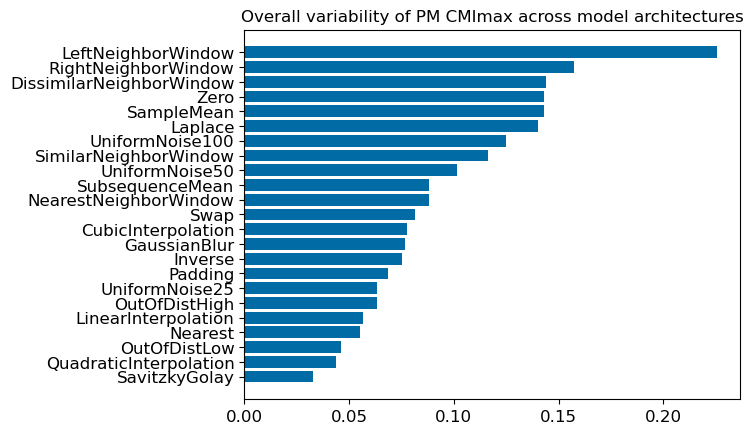

In [50]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# GENERATES FIGURES FOR SECTION: "Region Size Insights / Impact of region size on PM ranking for model architectures"
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
pms = []
values = []

for pm in pm_cmi_differences:
    # print(f'{pm} : {np.array(pm_cmi_differences[pm]).mean():.3f}')
    print(f'{pm} : {abs(np.array(pm_cmi_differences[pm])).mean():.3f}')
    pms.append(pm)
    values.append(abs(np.array(pm_cmi_differences[pm])).mean())

sorted_data = sorted(zip(values, pms), reverse=False)

values = [x[0] for x in sorted_data]
pms = [x[1] for x in sorted_data]

plt.barh(pms,values)
plt.title('Overall variability of PM CMImax across model architectures')
plt.show()

---
---
# Individual Custom Figures
---
---

## Comparisons of explanations from different AMs - same model and sample

Prediction and GT match!


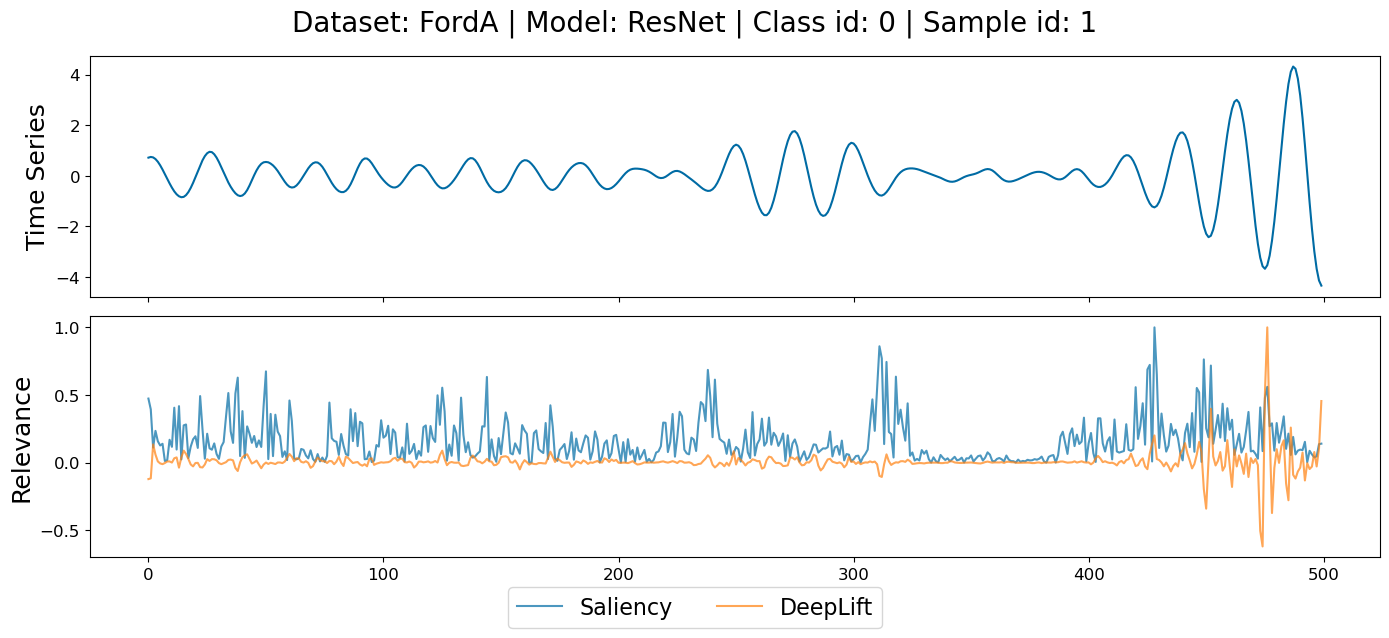

In [52]:
# FIGURE 1: DIFFERENT AMs producing different explanations
from utils.resnet import ResNet
from captum.attr import DeepLift, GuidedGradCam, InputXGradient, IntegratedGradients, KernelShap, Lime, Saliency, NoiseTunnel, GuidedBackprop, Deconvolution, FeatureAblation, Occlusion, ShapleyValueSampling, ShapleyValues

def fetch_explanations(dataset_name, class_id = None, sample_idx = 0):
    
    test_x, test_y, _ = load_univariate_UCR_dataset(dataset_name, is_testset=True)
    if class_id is not None:
        test_x = test_x[test_y == class_id]
    sample = test_x[sample_idx:sample_idx+1]
    
    model = ResNet(test_x.shape[-1], 1, 2)
    state_dict = torch.load("models/FordA/ResNet/seed_0/model.pt", map_location=torch.device('cpu')) 
    model.load_state_dict(state_dict)
    model.eval()

    sample_tensor = torch.Tensor(sample)
    ps = torch.exp(model(sample_tensor))

    if class_id == ps.argmax():
        print('Prediction and GT match!')

    ams = [
        Saliency,
        DeepLift,
    ]

    fig = plt.figure(facecolor='white', figsize=(14,6))
    axs = fig.subplots(nrows=2, ncols=1, sharex=True)
    plt.suptitle(f'Dataset: {dataset_name} | Model: ResNet | Class id: {class_id} | Sample id: {sample_idx}', fontsize=20)
    axs[0].plot(sample.reshape(-1))
    axs[0].set_ylabel('Time Series', fontsize=18)
    axs[1].set_ylabel('Relevance', fontsize=18)
    for am in ams:
        explainer = am(model)

        am_name = explainer.__class__.__name__
        explanation = explainer.attribute(sample_tensor, target=class_id).detach().numpy().reshape(-1)

        min_value = explanation.min()
        value_extent = abs(max(min_value, explanation.max()))
        explanation /= value_extent

        axs[1].plot(explanation.reshape(-1), label=am_name, alpha=0.7)


    # plt.legend(fontsize=16)
    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=16, bbox_to_anchor=(0.5, -0.07), ncol=3, loc='lower center')
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1)
    plt.tight_layout()
    plt.show()


# for i in range(10):
fetch_explanations('FordA', 0, 1)

